In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import date, datetime
from tqdm.notebook import tqdm, trange
import glob
from collections import Counter
import os

In [2]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
# from torchmetrics import MeanAbsolutePercentageError as torchMAPE

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import expon, norm, uniform

In [4]:
#device=torch.device("cpu")
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

cuda
True


In [5]:
max_N = 12
max_M = 12
T = 168
dt = 1
SEQ_LEN = 168

FEATURE_NUMBER = 3
OUTPUT_FEATURE = 1
EMBED_DIM1 = 4
EMBED_DIM2 = 4

In [6]:
n_samples = 100000
lam = np.loadtxt("arr1.csv", delimiter = ",")
N = np.loadtxt("doc1.csv", delimiter = ",")
st = 10*np.loadtxt("wt1.csv", delimiter = ",")
M=np.loadtxt("M1.csv",delimiter=",")

print(lam.shape)
print(N.shape)
print(st.shape)
print(M.shape)

(100000, 168)
(100000, 168)
(100000, 168)
(100000, 168)


In [7]:
# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, rate, target_size):
        super(LSTM, self).__init__()
        
        self.input_size = input_size # number of expected features in the input x
#         self.prelinear = nn.Linear(24, 24)
        self.embed = nn.Embedding(max_N + 1, EMBED_DIM1) # size of doctors: 12
        self.embed2=nn.Embedding(max_M+1,EMBED_DIM2)
        self.input_size = self.input_size + EMBED_DIM1+EMBED_DIM2 - 2
        
        self.lstm = nn.LSTM(self.input_size, self.input_size*rate, batch_first = True, num_layers = 1)
        self.fc = nn.Linear(self.input_size*rate, target_size)

    def forward(self, x):
        arr = x[:, :, 0].view(-1, SEQ_LEN, 1)
        cap = self.embed(x[:, :, 1].long())
        load = self.embed2(x[:,:,2].long())
        x = torch.cat((arr, cap,load), dim=2)
        
        lstm_out, hidden = self.lstm(x) # input: (L, H) / (N, L, H) = (batch size, 24, feature number)
        lstm_out, _ = self.lstm(x, hidden) # final hidden and cell state as init hidden and cell state
        output = self.fc(lstm_out)
        #output = F.relu(output)
        return output

In [8]:
# create Dataset class
class ClinicDataset(TensorDataset):
    def __init__(self, inputs, output, capacity = None):
        self.inputs = inputs
        self.output = output
#         self.capacity = capacity

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        inputs = self.inputs[idx, :]
        output = self.output[idx, :]
        # cap = self.capacity[idx, :]
        
#         capacity = self.capacity[idx, :]
        sample = {"inputs": inputs, "sojourn_time": output}
        return sample

In [9]:
input_features = np.hstack((lam, N, M))
# both_time = np.hstack((sum_wt, result_time))
print(input_features.shape)

(100000, 504)


In [10]:
TEST_SIZE = int(0.1 * n_samples)
X_train, X_test, y_train, y_test = train_test_split(input_features, st, test_size=TEST_SIZE, random_state=42)

print(X_train.shape)
print(y_test.shape)

(90000, 504)
(10000, 168)


In [11]:
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

train_set = ClinicDataset(X_train, y_train)
test_set = ClinicDataset(X_test, y_test)

In [12]:
BATCH_SIZE = 64 * 3
# dataloader
train_DL = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_DL = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
# Display text and label.
print('\nFirst iteration of data set: ', next(iter(train_set)), '\n')
# Print how many items are in the data set
print('Length of data set: ', len(train_set), len(test_set), '\n')


First iteration of data set:  {'inputs': tensor([12.9586, 15.5500, 14.9353, 14.1839, 11.5504,  7.5839, 11.4490, 11.5437,
        11.5841,  9.2960,  9.3051,  7.6486, 13.4220,  7.4398,  5.5488,  5.9240,
         6.0683,  3.3649,  2.3567,  1.7942,  1.4112,  0.9608,  3.5356, 11.7644,
         7.9106, 16.6491, 15.9860, 13.3038, 10.9730,  8.4683, 12.6094, 11.9929,
         8.3795, 10.7954, 10.1691, 10.7098, 12.9095,  7.5266,  6.8381,  5.6219,
         5.1132,  1.8607,  2.1112,  1.5524,  1.5062,  1.4502,  3.1449,  9.8812,
        13.1348, 11.2068, 17.1748, 15.9536, 15.7500, 11.0362,  9.5249,  9.7302,
        11.2168,  8.5221, 10.7551,  7.3464, 10.4239,  7.2319,  6.0846,  6.7730,
         3.3717,  4.1649,  2.3005,  1.7858,  1.2031,  1.6217,  4.8218,  9.0496,
        12.2897, 19.7691, 16.2205, 12.2469, 10.3993,  7.7943, 10.6525, 18.3041,
         9.2586, 13.7497,  7.4954,  5.2057,  6.4627,  8.0992,  8.9193,  5.5515,
         4.0353,  3.0119,  2.2320,  1.8641,  1.4717,  1.8469,  3.9404,  9.8656

In [14]:
loads = torch.rand((3,2))
a = loads * 3
b=torch.clamp(a, 1, 2)
print(loads, a / loads)
print(b)

tensor([[0.0434, 0.9225],
        [0.4648, 0.7072],
        [0.0653, 0.2987]]) tensor([[3.0000, 3.0000],
        [3.0000, 3.0000],
        [3.0000, 3.0000]])
tensor([[1.0000, 2.0000],
        [1.3945, 2.0000],
        [1.0000, 1.0000]])


In [16]:
# train function
def train(loader_train, loader_test, model, optimizer=None, learning_rate=0.001, epoch_num=100, checkpoint=True, suffix=""):
    model.train()
    if optimizer == None:
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    LOSS = 'MSE'
    if LOSS == 'MSE':
        criterion = nn.MSELoss(reduction='none') ## sample weight setting

    print('Training...')
    loss_rec = []
    flag=0
    bestloss=1e30
    bestmodel=None
    for epoch in trange(epoch_num, desc='Epoches'):
        #if epoch>epoch_num/2 and flag == 0:
            #optimizer = optim.SGD(model.parameters(), lr=learning_rate)
            #flag=1
        #if
        loss_temp = 0
        loss_count = 0
        
        for (step, batch) in enumerate(loader_train):
            batch_arrival = Variable(batch['inputs'])
            #print(batch_arrival.size())
            batch_qL = Variable(batch['sojourn_time'])
            #print(batch_qL.shape)
            #print(batch_arrival.view(-1, FEATURE_NUMBER, SEQ_LEN).shape)
            #print(batch_arrival.view(-1, FEATURE_NUMBER, SEQ_LEN).transpose(1, 2).shape)
            data_in = batch_arrival.view(-1, FEATURE_NUMBER, SEQ_LEN).transpose(1, 2)
            
            output = model(data_in)
            #print(output.size())
            #a=input()
            loss = criterion(output[:, :, 0], batch_qL)
            
            #loads = 1+torch.clamp(data_in[:, :, 0].view(-1, SEQ_LEN)/(data_in[:, :, 1]*5.9).long(),0,1)
            #loss *= loads
            loss = loss.sum() ## sample weight setting
            
#             sample_weight = []
#             if SAMPLE_WEIGHT == 1:
#                 for one_sample in batch_waiting:
#                     sample_weight.append([((batch_waiting.numpy().sum() - x)/batch_waiting.numpy().sum()) for x in one_sample.numpy()])
#             elif SAMPLE_WEIGHT == 2:
#                 for one_sample in batch_waiting:
#                     sample_weight.append([1-(x/np.max(batch_waiting.numpy()))**2 for x in one_sample.numpy()])
                
#             sample_weight = torch.Tensor(sample_weight)
#             if SAMPLE_WEIGHT > 0:
#                 loss = loss * sample_weight ## sample weight setting
#                 loss = loss.mean() ## sample weight setting
            # print('Epoch', epoch + 1, 'Step', step + 1, ':', loss.item())

            tqdm.write(str(f'Epoch {epoch + 1}, Step, {step + 1}, :, {loss.item()}'))

            loss_temp += loss.item()
            loss_count += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # scheduler.step()
        
        # predict on test set
        loss_test = batch_predict(loader_test, model)
        
        if loss_test<bestloss :
            bestloss=loss_test
            bestmodel=model
            torch.save(bestmodel,  "bestchecktwice_1114.pkl")
        tqdm.write(str(f'Epoch {epoch + 1}, test set loss: {loss_test}'))
        model.train()
        
        loss_temp /= loss_count
        loss_rec.append([loss_temp, loss_test])
        
    
    dt = datetime.now().strftime("%m%d_%H%M%S")
    
    # 训练完成后保存的文件路径
    path = "checktwice_1114.pkl"
    torch.save(model, path)
    if checkpoint == True:
        path = "checktwice_1114.tar"
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, path)

    return model, loss_rec

In [17]:
# batch predict function
def batch_predict(loader, model):
    
    model.eval()

    criterion = nn.MSELoss()
    # criterion = PercMSELoss()
    print('Predicting...')
    loss_temp = 0
    loss_count = 0
    for (step, batch) in enumerate(loader):
        batch_arrival = Variable(batch['inputs'])
        batch_qL = Variable(batch['sojourn_time'])
        output = model(batch_arrival.view(-1, FEATURE_NUMBER, SEQ_LEN).transpose(1, 2))
        output=output.clamp_(min=0)
        loss = criterion(output[:, :, 0], batch_qL)
        print('Step', step + 1, ':', loss.item())
        loss_temp += loss.item()
        loss_count += 1

    print("test on", step, output)
    loss_temp /= loss_count
    print(f"predict loss (MSE): {loss_temp}")
    
#     if MODEL_UNIT == 'minutes':
#         print(f"predict loss (RMSE): {loss_temp**0.5} mins")
#     elif MODEL_UNIT == 'hours':
#         print(f"predict loss (RMSE): {loss_temp**0.5*60} mins")
        
    return loss_temp

In [18]:
LEARNING_RATE = 1e-4
EPOCH_NUM = 100
model = LSTM(FEATURE_NUMBER, 100, OUTPUT_FEATURE).to(device)
model = torch.nn.DataParallel(model.to(device))#,device_ids=[0,1,2],output_device=2
m, loss = train(train_DL, test_DL, model, learning_rate=LEARNING_RATE, epoch_num=EPOCH_NUM)

Training...


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Epoch 1, Step, 1, :, 1287597056.0


C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch 1, Step, 2, :, 1328018432.0
Epoch 1, Step, 3, :, 1257056000.0
Epoch 1, Step, 4, :, 1354124544.0
Epoch 1, Step, 5, :, 1290771200.0
Epoch 1, Step, 6, :, 1206352896.0
Epoch 1, Step, 7, :, 1215577344.0
Epoch 1, Step, 8, :, 1270243072.0
Epoch 1, Step, 9, :, 1269776896.0
Epoch 1, Step, 10, :, 1250836736.0
Epoch 1, Step, 11, :, 1319254656.0
Epoch 1, Step, 12, :, 1301753088.0
Epoch 1, Step, 13, :, 1273056512.0
Epoch 1, Step, 14, :, 1345437952.0
Epoch 1, Step, 15, :, 1264876928.0
Epoch 1, Step, 16, :, 1269712640.0
Epoch 1, Step, 17, :, 1164194944.0
Epoch 1, Step, 18, :, 1216221312.0
Epoch 1, Step, 19, :, 1118053632.0
Epoch 1, Step, 20, :, 1308002816.0
Epoch 1, Step, 21, :, 1299745536.0
Epoch 1, Step, 22, :, 1220230144.0
Epoch 1, Step, 23, :, 1082999680.0
Epoch 1, Step, 24, :, 1124634624.0
Epoch 1, Step, 25, :, 1233836160.0
Epoch 1, Step, 26, :, 1161809920.0
Epoch 1, Step, 27, :, 1136099840.0
Epoch 1, Step, 28, :, 1264519424.0
Epoch 1, Step, 29, :, 1182427776.0
Epoch 1, Step, 30, :, 107453

Epoch 1, Step, 232, :, 1011221504.0
Epoch 1, Step, 233, :, 1142599168.0
Epoch 1, Step, 234, :, 1028675584.0
Epoch 1, Step, 235, :, 1022585088.0
Epoch 1, Step, 236, :, 1145738240.0
Epoch 1, Step, 237, :, 1016724544.0
Epoch 1, Step, 238, :, 1003994560.0
Epoch 1, Step, 239, :, 1213829120.0
Epoch 1, Step, 240, :, 1032671488.0
Epoch 1, Step, 241, :, 1076241152.0
Epoch 1, Step, 242, :, 1119335296.0
Epoch 1, Step, 243, :, 974405824.0
Epoch 1, Step, 244, :, 1047606272.0
Epoch 1, Step, 245, :, 1109198592.0
Epoch 1, Step, 246, :, 1083181568.0
Epoch 1, Step, 247, :, 1020698624.0
Epoch 1, Step, 248, :, 988559040.0
Epoch 1, Step, 249, :, 1064564288.0
Epoch 1, Step, 250, :, 1059781568.0
Epoch 1, Step, 251, :, 1019095936.0
Epoch 1, Step, 252, :, 1030470144.0
Epoch 1, Step, 253, :, 971304064.0
Epoch 1, Step, 254, :, 1056165888.0
Epoch 1, Step, 255, :, 1133772672.0
Epoch 1, Step, 256, :, 1105804928.0
Epoch 1, Step, 257, :, 982312704.0
Epoch 1, Step, 258, :, 1058228352.0
Epoch 1, Step, 259, :, 106020768

Epoch 1, Step, 461, :, 1032470528.0
Epoch 1, Step, 462, :, 1036939136.0
Epoch 1, Step, 463, :, 985244672.0
Epoch 1, Step, 464, :, 1014779520.0
Epoch 1, Step, 465, :, 1024986112.0
Epoch 1, Step, 466, :, 954779328.0
Epoch 1, Step, 467, :, 923438592.0
Epoch 1, Step, 468, :, 991554560.0
Epoch 1, Step, 469, :, 749607232.0
Predicting...
Step 1 : 31808.04296875
Step 2 : 33553.40234375
Step 3 : 31099.65625
Step 4 : 33164.109375
Step 5 : 29879.302734375
Step 6 : 29159.900390625
Step 7 : 31263.8828125
Step 8 : 31702.33203125
Step 9 : 31260.068359375
Step 10 : 31409.6015625
Step 11 : 30380.111328125
Step 12 : 33595.76953125
Step 13 : 30724.4609375
Step 14 : 29449.1796875
Step 15 : 30295.8984375
Step 16 : 31882.130859375
Step 17 : 32214.998046875
Step 18 : 30533.08203125
Step 19 : 29196.076171875
Step 20 : 29880.240234375
Step 21 : 30707.9375
Step 22 : 30124.994140625
Step 23 : 28935.939453125
Step 24 : 33485.5625
Step 25 : 31999.728515625
Step 26 : 30363.208984375
Step 27 : 30976.490234375
Step 2

Epoch 2, Step, 162, :, 971162368.0
Epoch 2, Step, 163, :, 1042232960.0
Epoch 2, Step, 164, :, 934037120.0
Epoch 2, Step, 165, :, 1008906368.0
Epoch 2, Step, 166, :, 986149632.0
Epoch 2, Step, 167, :, 905756928.0
Epoch 2, Step, 168, :, 1020026240.0
Epoch 2, Step, 169, :, 922881280.0
Epoch 2, Step, 170, :, 923795200.0
Epoch 2, Step, 171, :, 970248320.0
Epoch 2, Step, 172, :, 946047936.0
Epoch 2, Step, 173, :, 963449856.0
Epoch 2, Step, 174, :, 906889216.0
Epoch 2, Step, 175, :, 1000491456.0
Epoch 2, Step, 176, :, 932621696.0
Epoch 2, Step, 177, :, 874995200.0
Epoch 2, Step, 178, :, 950605760.0
Epoch 2, Step, 179, :, 949871232.0
Epoch 2, Step, 180, :, 947695744.0
Epoch 2, Step, 181, :, 972176000.0
Epoch 2, Step, 182, :, 919883008.0
Epoch 2, Step, 183, :, 1004912576.0
Epoch 2, Step, 184, :, 1004308544.0
Epoch 2, Step, 185, :, 1006765440.0
Epoch 2, Step, 186, :, 896512448.0
Epoch 2, Step, 187, :, 859667840.0
Epoch 2, Step, 188, :, 1025216512.0
Epoch 2, Step, 189, :, 918772480.0
Epoch 2, Ste

Epoch 2, Step, 395, :, 1002544704.0
Epoch 2, Step, 396, :, 867815168.0
Epoch 2, Step, 397, :, 889216000.0
Epoch 2, Step, 398, :, 903688896.0
Epoch 2, Step, 399, :, 964991104.0
Epoch 2, Step, 400, :, 937108480.0
Epoch 2, Step, 401, :, 985725568.0
Epoch 2, Step, 402, :, 942851968.0
Epoch 2, Step, 403, :, 1001761408.0
Epoch 2, Step, 404, :, 964756544.0
Epoch 2, Step, 405, :, 868305280.0
Epoch 2, Step, 406, :, 932553728.0
Epoch 2, Step, 407, :, 837893632.0
Epoch 2, Step, 408, :, 986639744.0
Epoch 2, Step, 409, :, 908589824.0
Epoch 2, Step, 410, :, 943841344.0
Epoch 2, Step, 411, :, 904205184.0
Epoch 2, Step, 412, :, 1010194176.0
Epoch 2, Step, 413, :, 946934464.0
Epoch 2, Step, 414, :, 849100992.0
Epoch 2, Step, 415, :, 912118976.0
Epoch 2, Step, 416, :, 836948096.0
Epoch 2, Step, 417, :, 931658176.0
Epoch 2, Step, 418, :, 898760896.0
Epoch 2, Step, 419, :, 920832512.0
Epoch 2, Step, 420, :, 917407488.0
Epoch 2, Step, 421, :, 1000640128.0
Epoch 2, Step, 422, :, 888135680.0
Epoch 2, Step, 4

Epoch 3, Step, 97, :, 859060480.0
Epoch 3, Step, 98, :, 816154112.0
Epoch 3, Step, 99, :, 849022592.0
Epoch 3, Step, 100, :, 970835904.0
Epoch 3, Step, 101, :, 950637056.0
Epoch 3, Step, 102, :, 954141952.0
Epoch 3, Step, 103, :, 872753280.0
Epoch 3, Step, 104, :, 920616256.0
Epoch 3, Step, 105, :, 862710656.0
Epoch 3, Step, 106, :, 938398464.0
Epoch 3, Step, 107, :, 810434432.0
Epoch 3, Step, 108, :, 897636736.0
Epoch 3, Step, 109, :, 861731200.0
Epoch 3, Step, 110, :, 908968064.0
Epoch 3, Step, 111, :, 919303296.0
Epoch 3, Step, 112, :, 966492544.0
Epoch 3, Step, 113, :, 882190528.0
Epoch 3, Step, 114, :, 942584064.0
Epoch 3, Step, 115, :, 918070528.0
Epoch 3, Step, 116, :, 904603712.0
Epoch 3, Step, 117, :, 835161344.0
Epoch 3, Step, 118, :, 930467968.0
Epoch 3, Step, 119, :, 892167552.0
Epoch 3, Step, 120, :, 856511488.0
Epoch 3, Step, 121, :, 888321280.0
Epoch 3, Step, 122, :, 947581952.0
Epoch 3, Step, 123, :, 891044736.0
Epoch 3, Step, 124, :, 869630080.0
Epoch 3, Step, 125, :, 

Epoch 3, Step, 331, :, 919969216.0
Epoch 3, Step, 332, :, 855020032.0
Epoch 3, Step, 333, :, 907556352.0
Epoch 3, Step, 334, :, 931123904.0
Epoch 3, Step, 335, :, 894857920.0
Epoch 3, Step, 336, :, 938720896.0
Epoch 3, Step, 337, :, 879228032.0
Epoch 3, Step, 338, :, 811940928.0
Epoch 3, Step, 339, :, 849013824.0
Epoch 3, Step, 340, :, 908397760.0
Epoch 3, Step, 341, :, 891285248.0
Epoch 3, Step, 342, :, 825043200.0
Epoch 3, Step, 343, :, 902291904.0
Epoch 3, Step, 344, :, 864205056.0
Epoch 3, Step, 345, :, 808904960.0
Epoch 3, Step, 346, :, 947893632.0
Epoch 3, Step, 347, :, 885015680.0
Epoch 3, Step, 348, :, 859710720.0
Epoch 3, Step, 349, :, 886330368.0
Epoch 3, Step, 350, :, 893125760.0
Epoch 3, Step, 351, :, 823733760.0
Epoch 3, Step, 352, :, 918661120.0
Epoch 3, Step, 353, :, 821570112.0
Epoch 3, Step, 354, :, 909449216.0
Epoch 3, Step, 355, :, 863511168.0
Epoch 3, Step, 356, :, 849918528.0
Epoch 3, Step, 357, :, 884173952.0
Epoch 3, Step, 358, :, 804767680.0
Epoch 3, Step, 359, 

Epoch 4, Step, 31, :, 769812096.0
Epoch 4, Step, 32, :, 813889664.0
Epoch 4, Step, 33, :, 826823808.0
Epoch 4, Step, 34, :, 822698496.0
Epoch 4, Step, 35, :, 773234944.0
Epoch 4, Step, 36, :, 743365568.0
Epoch 4, Step, 37, :, 752976320.0
Epoch 4, Step, 38, :, 750146368.0
Epoch 4, Step, 39, :, 760191360.0
Epoch 4, Step, 40, :, 771337344.0
Epoch 4, Step, 41, :, 846911360.0
Epoch 4, Step, 42, :, 824000256.0
Epoch 4, Step, 43, :, 819464768.0
Epoch 4, Step, 44, :, 819368320.0
Epoch 4, Step, 45, :, 807615744.0
Epoch 4, Step, 46, :, 766194496.0
Epoch 4, Step, 47, :, 765992192.0
Epoch 4, Step, 48, :, 765765632.0
Epoch 4, Step, 49, :, 823466304.0
Epoch 4, Step, 50, :, 806836736.0
Epoch 4, Step, 51, :, 732249792.0
Epoch 4, Step, 52, :, 772548160.0
Epoch 4, Step, 53, :, 893776576.0
Epoch 4, Step, 54, :, 825745280.0
Epoch 4, Step, 55, :, 905794688.0
Epoch 4, Step, 56, :, 795403904.0
Epoch 4, Step, 57, :, 752834944.0
Epoch 4, Step, 58, :, 780902080.0
Epoch 4, Step, 59, :, 754776576.0
Epoch 4, Step,

Epoch 4, Step, 267, :, 692155904.0
Epoch 4, Step, 268, :, 655707712.0
Epoch 4, Step, 269, :, 767324352.0
Epoch 4, Step, 270, :, 755869184.0
Epoch 4, Step, 271, :, 740536960.0
Epoch 4, Step, 272, :, 698530688.0
Epoch 4, Step, 273, :, 755246464.0
Epoch 4, Step, 274, :, 709209344.0
Epoch 4, Step, 275, :, 688902784.0
Epoch 4, Step, 276, :, 690692160.0
Epoch 4, Step, 277, :, 721657920.0
Epoch 4, Step, 278, :, 652342400.0
Epoch 4, Step, 279, :, 653416960.0
Epoch 4, Step, 280, :, 672636416.0
Epoch 4, Step, 281, :, 771696256.0
Epoch 4, Step, 282, :, 718742080.0
Epoch 4, Step, 283, :, 738294784.0
Epoch 4, Step, 284, :, 708878080.0
Epoch 4, Step, 285, :, 706322560.0
Epoch 4, Step, 286, :, 742691072.0
Epoch 4, Step, 287, :, 752550336.0
Epoch 4, Step, 288, :, 660931072.0
Epoch 4, Step, 289, :, 738774464.0
Epoch 4, Step, 290, :, 765140224.0
Epoch 4, Step, 291, :, 731561280.0
Epoch 4, Step, 292, :, 801943936.0
Epoch 4, Step, 293, :, 668963712.0
Epoch 4, Step, 294, :, 699988096.0
Epoch 4, Step, 295, 

Step 44 : 22497.796875
Step 45 : 22050.240234375
Step 46 : 21897.283203125
Step 47 : 20723.521484375
Step 48 : 20964.255859375
Step 49 : 21528.283203125
Step 50 : 19982.294921875
Step 51 : 21649.828125
Step 52 : 20280.43359375
Step 53 : 16509.833984375
test on 52 tensor([[[ 98.3587],
         [133.2858],
         [139.2330],
         ...,
         [  1.6960],
         [  7.4152],
         [ 34.5451]],

        [[136.6015],
         [139.2717],
         [139.9952],
         ...,
         [ 19.3751],
         [ 61.4287],
         [123.4002]],

        [[ 63.7419],
         [125.4067],
         [138.6862],
         ...,
         [  0.0000],
         [  0.0000],
         [ 15.0345]],

        ...,

        [[134.4647],
         [136.4168],
         [135.0755],
         ...,
         [ 10.6787],
         [ 38.6852],
         [105.9803]],

        [[124.2758],
         [136.0742],
         [140.0982],
         ...,
         [  5.0427],
         [ 21.2590],
         [ 67.2420]],

        [[ 6

Epoch 5, Step, 202, :, 614310336.0
Epoch 5, Step, 203, :, 649619456.0
Epoch 5, Step, 204, :, 652661440.0
Epoch 5, Step, 205, :, 640393728.0
Epoch 5, Step, 206, :, 595342976.0
Epoch 5, Step, 207, :, 646886656.0
Epoch 5, Step, 208, :, 639871936.0
Epoch 5, Step, 209, :, 611109504.0
Epoch 5, Step, 210, :, 596318464.0
Epoch 5, Step, 211, :, 544704704.0
Epoch 5, Step, 212, :, 547089472.0
Epoch 5, Step, 213, :, 599428544.0
Epoch 5, Step, 214, :, 596302720.0
Epoch 5, Step, 215, :, 593609280.0
Epoch 5, Step, 216, :, 556977280.0
Epoch 5, Step, 217, :, 655917952.0
Epoch 5, Step, 218, :, 556642688.0
Epoch 5, Step, 219, :, 596918144.0
Epoch 5, Step, 220, :, 573818496.0
Epoch 5, Step, 221, :, 575735424.0
Epoch 5, Step, 222, :, 564896832.0
Epoch 5, Step, 223, :, 612904576.0
Epoch 5, Step, 224, :, 584100096.0
Epoch 5, Step, 225, :, 671466368.0
Epoch 5, Step, 226, :, 598998528.0
Epoch 5, Step, 227, :, 619545152.0
Epoch 5, Step, 228, :, 568242112.0
Epoch 5, Step, 229, :, 588795200.0
Epoch 5, Step, 230, 

Epoch 5, Step, 436, :, 508813440.0
Epoch 5, Step, 437, :, 531405312.0
Epoch 5, Step, 438, :, 489434176.0
Epoch 5, Step, 439, :, 577075264.0
Epoch 5, Step, 440, :, 524436608.0
Epoch 5, Step, 441, :, 565321792.0
Epoch 5, Step, 442, :, 564452992.0
Epoch 5, Step, 443, :, 624339072.0
Epoch 5, Step, 444, :, 544283776.0
Epoch 5, Step, 445, :, 544085376.0
Epoch 5, Step, 446, :, 560078976.0
Epoch 5, Step, 447, :, 598238848.0
Epoch 5, Step, 448, :, 543827456.0
Epoch 5, Step, 449, :, 536000160.0
Epoch 5, Step, 450, :, 517906752.0
Epoch 5, Step, 451, :, 589312000.0
Epoch 5, Step, 452, :, 594608576.0
Epoch 5, Step, 453, :, 535203904.0
Epoch 5, Step, 454, :, 555266176.0
Epoch 5, Step, 455, :, 534037568.0
Epoch 5, Step, 456, :, 561610368.0
Epoch 5, Step, 457, :, 527247040.0
Epoch 5, Step, 458, :, 445211008.0
Epoch 5, Step, 459, :, 585539072.0
Epoch 5, Step, 460, :, 609111040.0
Epoch 5, Step, 461, :, 550241984.0
Epoch 5, Step, 462, :, 512835328.0
Epoch 5, Step, 463, :, 568050304.0
Epoch 5, Step, 464, 

Epoch 6, Step, 137, :, 566028736.0
Epoch 6, Step, 138, :, 560800000.0
Epoch 6, Step, 139, :, 527102848.0
Epoch 6, Step, 140, :, 449275648.0
Epoch 6, Step, 141, :, 548524096.0
Epoch 6, Step, 142, :, 535391744.0
Epoch 6, Step, 143, :, 499333568.0
Epoch 6, Step, 144, :, 468048352.0
Epoch 6, Step, 145, :, 550935232.0
Epoch 6, Step, 146, :, 555752768.0
Epoch 6, Step, 147, :, 512700608.0
Epoch 6, Step, 148, :, 496330880.0
Epoch 6, Step, 149, :, 545337216.0
Epoch 6, Step, 150, :, 602122752.0
Epoch 6, Step, 151, :, 534315936.0
Epoch 6, Step, 152, :, 543259136.0
Epoch 6, Step, 153, :, 549553280.0
Epoch 6, Step, 154, :, 481738240.0
Epoch 6, Step, 155, :, 478411008.0
Epoch 6, Step, 156, :, 501941088.0
Epoch 6, Step, 157, :, 497844288.0
Epoch 6, Step, 158, :, 494033472.0
Epoch 6, Step, 159, :, 523913280.0
Epoch 6, Step, 160, :, 512838144.0
Epoch 6, Step, 161, :, 568101120.0
Epoch 6, Step, 162, :, 528918048.0
Epoch 6, Step, 163, :, 485771456.0
Epoch 6, Step, 164, :, 554308224.0
Epoch 6, Step, 165, 

Epoch 6, Step, 371, :, 505155264.0
Epoch 6, Step, 372, :, 487857120.0
Epoch 6, Step, 373, :, 496005888.0
Epoch 6, Step, 374, :, 525333504.0
Epoch 6, Step, 375, :, 479229856.0
Epoch 6, Step, 376, :, 457654336.0
Epoch 6, Step, 377, :, 507044032.0
Epoch 6, Step, 378, :, 567217856.0
Epoch 6, Step, 379, :, 467518240.0
Epoch 6, Step, 380, :, 516919904.0
Epoch 6, Step, 381, :, 504138560.0
Epoch 6, Step, 382, :, 527685600.0
Epoch 6, Step, 383, :, 416109760.0
Epoch 6, Step, 384, :, 479788992.0
Epoch 6, Step, 385, :, 534050592.0
Epoch 6, Step, 386, :, 435163520.0
Epoch 6, Step, 387, :, 527358432.0
Epoch 6, Step, 388, :, 538629696.0
Epoch 6, Step, 389, :, 479193728.0
Epoch 6, Step, 390, :, 449018624.0
Epoch 6, Step, 391, :, 480986464.0
Epoch 6, Step, 392, :, 483122752.0
Epoch 6, Step, 393, :, 532789984.0
Epoch 6, Step, 394, :, 477204800.0
Epoch 6, Step, 395, :, 483718528.0
Epoch 6, Step, 396, :, 448106112.0
Epoch 6, Step, 397, :, 492016448.0
Epoch 6, Step, 398, :, 475648224.0
Epoch 6, Step, 399, 

Epoch 7, Step, 69, :, 494850944.0
Epoch 7, Step, 70, :, 482082400.0
Epoch 7, Step, 71, :, 472106304.0
Epoch 7, Step, 72, :, 442456960.0
Epoch 7, Step, 73, :, 478758368.0
Epoch 7, Step, 74, :, 504732704.0
Epoch 7, Step, 75, :, 493380064.0
Epoch 7, Step, 76, :, 435945216.0
Epoch 7, Step, 77, :, 474226528.0
Epoch 7, Step, 78, :, 474281856.0
Epoch 7, Step, 79, :, 466522176.0
Epoch 7, Step, 80, :, 492750528.0
Epoch 7, Step, 81, :, 463916416.0
Epoch 7, Step, 82, :, 438409152.0
Epoch 7, Step, 83, :, 449736256.0
Epoch 7, Step, 84, :, 511498880.0
Epoch 7, Step, 85, :, 441258432.0
Epoch 7, Step, 86, :, 429506496.0
Epoch 7, Step, 87, :, 483578368.0
Epoch 7, Step, 88, :, 395627872.0
Epoch 7, Step, 89, :, 514720192.0
Epoch 7, Step, 90, :, 442927040.0
Epoch 7, Step, 91, :, 476503904.0
Epoch 7, Step, 92, :, 513301120.0
Epoch 7, Step, 93, :, 430025248.0
Epoch 7, Step, 94, :, 495056576.0
Epoch 7, Step, 95, :, 454033536.0
Epoch 7, Step, 96, :, 412467200.0
Epoch 7, Step, 97, :, 480764000.0
Epoch 7, Step,

Epoch 7, Step, 303, :, 436764096.0
Epoch 7, Step, 304, :, 427798112.0
Epoch 7, Step, 305, :, 390556224.0
Epoch 7, Step, 306, :, 418614912.0
Epoch 7, Step, 307, :, 417526400.0
Epoch 7, Step, 308, :, 459956672.0
Epoch 7, Step, 309, :, 387492448.0
Epoch 7, Step, 310, :, 475250848.0
Epoch 7, Step, 311, :, 379946528.0
Epoch 7, Step, 312, :, 481879552.0
Epoch 7, Step, 313, :, 414696000.0
Epoch 7, Step, 314, :, 450620160.0
Epoch 7, Step, 315, :, 487489152.0
Epoch 7, Step, 316, :, 414214816.0
Epoch 7, Step, 317, :, 440836288.0
Epoch 7, Step, 318, :, 430922752.0
Epoch 7, Step, 319, :, 431002752.0
Epoch 7, Step, 320, :, 377563936.0
Epoch 7, Step, 321, :, 458277088.0
Epoch 7, Step, 322, :, 466896512.0
Epoch 7, Step, 323, :, 437736416.0
Epoch 7, Step, 324, :, 411946368.0
Epoch 7, Step, 325, :, 415448224.0
Epoch 7, Step, 326, :, 454331648.0
Epoch 7, Step, 327, :, 431016352.0
Epoch 7, Step, 328, :, 437545120.0
Epoch 7, Step, 329, :, 450880768.0
Epoch 7, Step, 330, :, 436462336.0
Epoch 7, Step, 331, 

Epoch 7, test set loss: 12754.851470371463
Epoch 8, Step, 1, :, 430802848.0
Epoch 8, Step, 2, :, 407234208.0
Epoch 8, Step, 3, :, 361106368.0
Epoch 8, Step, 4, :, 369783552.0
Epoch 8, Step, 5, :, 386434432.0
Epoch 8, Step, 6, :, 360544640.0
Epoch 8, Step, 7, :, 418408192.0
Epoch 8, Step, 8, :, 465374080.0
Epoch 8, Step, 9, :, 388058912.0
Epoch 8, Step, 10, :, 374519104.0
Epoch 8, Step, 11, :, 367492416.0
Epoch 8, Step, 12, :, 431739840.0
Epoch 8, Step, 13, :, 399980288.0
Epoch 8, Step, 14, :, 353795584.0
Epoch 8, Step, 15, :, 364277120.0
Epoch 8, Step, 16, :, 373495200.0
Epoch 8, Step, 17, :, 375542336.0
Epoch 8, Step, 18, :, 402635680.0
Epoch 8, Step, 19, :, 369832128.0
Epoch 8, Step, 20, :, 369432576.0
Epoch 8, Step, 21, :, 390089024.0
Epoch 8, Step, 22, :, 400814496.0
Epoch 8, Step, 23, :, 418440704.0
Epoch 8, Step, 24, :, 425871168.0
Epoch 8, Step, 25, :, 412840576.0
Epoch 8, Step, 26, :, 346979072.0
Epoch 8, Step, 27, :, 412027808.0
Epoch 8, Step, 28, :, 432301376.0
Epoch 8, Step,

Epoch 8, Step, 236, :, 449792608.0
Epoch 8, Step, 237, :, 403179008.0
Epoch 8, Step, 238, :, 383712736.0
Epoch 8, Step, 239, :, 400178944.0
Epoch 8, Step, 240, :, 341987968.0
Epoch 8, Step, 241, :, 396315200.0
Epoch 8, Step, 242, :, 420584640.0
Epoch 8, Step, 243, :, 415122048.0
Epoch 8, Step, 244, :, 390506304.0
Epoch 8, Step, 245, :, 365593856.0
Epoch 8, Step, 246, :, 325048064.0
Epoch 8, Step, 247, :, 365706592.0
Epoch 8, Step, 248, :, 380681536.0
Epoch 8, Step, 249, :, 397328320.0
Epoch 8, Step, 250, :, 447279424.0
Epoch 8, Step, 251, :, 411403552.0
Epoch 8, Step, 252, :, 345758592.0
Epoch 8, Step, 253, :, 352256128.0
Epoch 8, Step, 254, :, 409261120.0
Epoch 8, Step, 255, :, 352585728.0
Epoch 8, Step, 256, :, 389532448.0
Epoch 8, Step, 257, :, 395197888.0
Epoch 8, Step, 258, :, 375931840.0
Epoch 8, Step, 259, :, 405530976.0
Epoch 8, Step, 260, :, 361632768.0
Epoch 8, Step, 261, :, 370292672.0
Epoch 8, Step, 262, :, 353827712.0
Epoch 8, Step, 263, :, 377992480.0
Epoch 8, Step, 264, 

Predicting...
Step 1 : 10869.0693359375
Step 2 : 10019.787109375
Step 3 : 11083.0693359375
Step 4 : 10644.7431640625
Step 5 : 10784.3505859375
Step 6 : 10653.5654296875
Step 7 : 9449.951171875
Step 8 : 8391.4345703125
Step 9 : 10963.595703125
Step 10 : 10336.2119140625
Step 11 : 12189.845703125
Step 12 : 12126.8134765625
Step 13 : 10895.162109375
Step 14 : 9237.4814453125
Step 15 : 11445.8173828125
Step 16 : 10907.28125
Step 17 : 12143.3603515625
Step 18 : 12265.5048828125
Step 19 : 10891.1298828125
Step 20 : 11223.5859375
Step 21 : 10270.5712890625
Step 22 : 11976.341796875
Step 23 : 10906.3564453125
Step 24 : 9997.490234375
Step 25 : 12188.7666015625
Step 26 : 11486.236328125
Step 27 : 9951.2421875
Step 28 : 9852.107421875
Step 29 : 11735.814453125
Step 30 : 9887.765625
Step 31 : 11288.337890625
Step 32 : 10723.1650390625
Step 33 : 11796.65625
Step 34 : 9851.9130859375
Step 35 : 10180.380859375
Step 36 : 10502.3798828125
Step 37 : 10058.9482421875
Step 38 : 11151.619140625
Step 39 : 

Epoch 9, Step, 170, :, 337923936.0
Epoch 9, Step, 171, :, 311938336.0
Epoch 9, Step, 172, :, 315601024.0
Epoch 9, Step, 173, :, 322749440.0
Epoch 9, Step, 174, :, 311967104.0
Epoch 9, Step, 175, :, 336298176.0
Epoch 9, Step, 176, :, 284951424.0
Epoch 9, Step, 177, :, 301417280.0
Epoch 9, Step, 178, :, 295182880.0
Epoch 9, Step, 179, :, 306569536.0
Epoch 9, Step, 180, :, 342442016.0
Epoch 9, Step, 181, :, 365273344.0
Epoch 9, Step, 182, :, 299595392.0
Epoch 9, Step, 183, :, 348766528.0
Epoch 9, Step, 184, :, 333434624.0
Epoch 9, Step, 185, :, 370432960.0
Epoch 9, Step, 186, :, 299262912.0
Epoch 9, Step, 187, :, 321071840.0
Epoch 9, Step, 188, :, 378095488.0
Epoch 9, Step, 189, :, 359113152.0
Epoch 9, Step, 190, :, 394555392.0
Epoch 9, Step, 191, :, 328930368.0
Epoch 9, Step, 192, :, 362527872.0
Epoch 9, Step, 193, :, 338969600.0
Epoch 9, Step, 194, :, 366546240.0
Epoch 9, Step, 195, :, 287580864.0
Epoch 9, Step, 196, :, 325235008.0
Epoch 9, Step, 197, :, 327442304.0
Epoch 9, Step, 198, 

Epoch 9, Step, 404, :, 315355232.0
Epoch 9, Step, 405, :, 318578752.0
Epoch 9, Step, 406, :, 299268256.0
Epoch 9, Step, 407, :, 305521376.0
Epoch 9, Step, 408, :, 356903680.0
Epoch 9, Step, 409, :, 352906080.0
Epoch 9, Step, 410, :, 308554528.0
Epoch 9, Step, 411, :, 323924576.0
Epoch 9, Step, 412, :, 330859616.0
Epoch 9, Step, 413, :, 308602720.0
Epoch 9, Step, 414, :, 289077440.0
Epoch 9, Step, 415, :, 316340864.0
Epoch 9, Step, 416, :, 310593216.0
Epoch 9, Step, 417, :, 325823776.0
Epoch 9, Step, 418, :, 330244736.0
Epoch 9, Step, 419, :, 295624704.0
Epoch 9, Step, 420, :, 310905184.0
Epoch 9, Step, 421, :, 315193888.0
Epoch 9, Step, 422, :, 322454400.0
Epoch 9, Step, 423, :, 289231680.0
Epoch 9, Step, 424, :, 321618240.0
Epoch 9, Step, 425, :, 347305408.0
Epoch 9, Step, 426, :, 289374144.0
Epoch 9, Step, 427, :, 334589952.0
Epoch 9, Step, 428, :, 318418176.0
Epoch 9, Step, 429, :, 297453536.0
Epoch 9, Step, 430, :, 315041440.0
Epoch 9, Step, 431, :, 307245760.0
Epoch 9, Step, 432, 

Epoch 10, Step, 102, :, 316008192.0
Epoch 10, Step, 103, :, 278342976.0
Epoch 10, Step, 104, :, 255013184.0
Epoch 10, Step, 105, :, 309640928.0
Epoch 10, Step, 106, :, 295501056.0
Epoch 10, Step, 107, :, 316512960.0
Epoch 10, Step, 108, :, 283842304.0
Epoch 10, Step, 109, :, 265035392.0
Epoch 10, Step, 110, :, 316678944.0
Epoch 10, Step, 111, :, 324148448.0
Epoch 10, Step, 112, :, 285117536.0
Epoch 10, Step, 113, :, 259593824.0
Epoch 10, Step, 114, :, 322133952.0
Epoch 10, Step, 115, :, 290674560.0
Epoch 10, Step, 116, :, 332687936.0
Epoch 10, Step, 117, :, 296006336.0
Epoch 10, Step, 118, :, 286081472.0
Epoch 10, Step, 119, :, 292775200.0
Epoch 10, Step, 120, :, 289613312.0
Epoch 10, Step, 121, :, 296313312.0
Epoch 10, Step, 122, :, 288462976.0
Epoch 10, Step, 123, :, 300312096.0
Epoch 10, Step, 124, :, 294822976.0
Epoch 10, Step, 125, :, 301207936.0
Epoch 10, Step, 126, :, 309124352.0
Epoch 10, Step, 127, :, 299437952.0
Epoch 10, Step, 128, :, 291588512.0
Epoch 10, Step, 129, :, 2965

Epoch 10, Step, 329, :, 285676608.0
Epoch 10, Step, 330, :, 247398416.0
Epoch 10, Step, 331, :, 285466848.0
Epoch 10, Step, 332, :, 300812000.0
Epoch 10, Step, 333, :, 293103904.0
Epoch 10, Step, 334, :, 319328768.0
Epoch 10, Step, 335, :, 238751008.0
Epoch 10, Step, 336, :, 288673088.0
Epoch 10, Step, 337, :, 319432128.0
Epoch 10, Step, 338, :, 277691840.0
Epoch 10, Step, 339, :, 314627968.0
Epoch 10, Step, 340, :, 238510544.0
Epoch 10, Step, 341, :, 282475584.0
Epoch 10, Step, 342, :, 249604352.0
Epoch 10, Step, 343, :, 271813408.0
Epoch 10, Step, 344, :, 284873920.0
Epoch 10, Step, 345, :, 324560992.0
Epoch 10, Step, 346, :, 308171968.0
Epoch 10, Step, 347, :, 256532832.0
Epoch 10, Step, 348, :, 288273408.0
Epoch 10, Step, 349, :, 294483392.0
Epoch 10, Step, 350, :, 262672096.0
Epoch 10, Step, 351, :, 264244080.0
Epoch 10, Step, 352, :, 276232288.0
Epoch 10, Step, 353, :, 307035840.0
Epoch 10, Step, 354, :, 278807360.0
Epoch 10, Step, 355, :, 299522656.0
Epoch 10, Step, 356, :, 3120

Epoch 11, Step, 22, :, 302828000.0
Epoch 11, Step, 23, :, 267998416.0
Epoch 11, Step, 24, :, 325367360.0
Epoch 11, Step, 25, :, 234955392.0
Epoch 11, Step, 26, :, 267312752.0
Epoch 11, Step, 27, :, 290710048.0
Epoch 11, Step, 28, :, 304201024.0
Epoch 11, Step, 29, :, 314374112.0
Epoch 11, Step, 30, :, 216551840.0
Epoch 11, Step, 31, :, 245373200.0
Epoch 11, Step, 32, :, 291014496.0
Epoch 11, Step, 33, :, 273354400.0
Epoch 11, Step, 34, :, 262140768.0
Epoch 11, Step, 35, :, 280373184.0
Epoch 11, Step, 36, :, 252235824.0
Epoch 11, Step, 37, :, 287929824.0
Epoch 11, Step, 38, :, 262120320.0
Epoch 11, Step, 39, :, 261213456.0
Epoch 11, Step, 40, :, 274822336.0
Epoch 11, Step, 41, :, 260145808.0
Epoch 11, Step, 42, :, 316209600.0
Epoch 11, Step, 43, :, 267627456.0
Epoch 11, Step, 44, :, 275610432.0
Epoch 11, Step, 45, :, 247015488.0
Epoch 11, Step, 46, :, 296717344.0
Epoch 11, Step, 47, :, 291145024.0
Epoch 11, Step, 48, :, 291854112.0
Epoch 11, Step, 49, :, 271598432.0
Epoch 11, Step, 50, 

Epoch 11, Step, 251, :, 246652224.0
Epoch 11, Step, 252, :, 281559424.0
Epoch 11, Step, 253, :, 268436992.0
Epoch 11, Step, 254, :, 286527552.0
Epoch 11, Step, 255, :, 253960592.0
Epoch 11, Step, 256, :, 246844640.0
Epoch 11, Step, 257, :, 219856352.0
Epoch 11, Step, 258, :, 248564928.0
Epoch 11, Step, 259, :, 272951744.0
Epoch 11, Step, 260, :, 275580608.0
Epoch 11, Step, 261, :, 275558976.0
Epoch 11, Step, 262, :, 270273920.0
Epoch 11, Step, 263, :, 250120848.0
Epoch 11, Step, 264, :, 242325600.0
Epoch 11, Step, 265, :, 211429216.0
Epoch 11, Step, 266, :, 257085184.0
Epoch 11, Step, 267, :, 265719136.0
Epoch 11, Step, 268, :, 241908832.0
Epoch 11, Step, 269, :, 250674048.0
Epoch 11, Step, 270, :, 231194288.0
Epoch 11, Step, 271, :, 260210880.0
Epoch 11, Step, 272, :, 268762880.0
Epoch 11, Step, 273, :, 261739568.0
Epoch 11, Step, 274, :, 227875472.0
Epoch 11, Step, 275, :, 216681984.0
Epoch 11, Step, 276, :, 263344880.0
Epoch 11, Step, 277, :, 251433776.0
Epoch 11, Step, 278, :, 2625

Step 12 : 7269.171875
Step 13 : 7830.27783203125
Step 14 : 7997.828125
Step 15 : 7001.013671875
Step 16 : 6617.21337890625
Step 17 : 8128.908203125
Step 18 : 6508.06787109375
Step 19 : 7327.958984375
Step 20 : 8073.4609375
Step 21 : 8264.73046875
Step 22 : 7623.12060546875
Step 23 : 7840.09619140625
Step 24 : 6961.98828125
Step 25 : 6574.33447265625
Step 26 : 7466.06640625
Step 27 : 6595.30126953125
Step 28 : 8910.353515625
Step 29 : 7229.7138671875
Step 30 : 7608.794921875
Step 31 : 7341.95361328125
Step 32 : 7734.6708984375
Step 33 : 7764.54443359375
Step 34 : 7295.626953125
Step 35 : 6776.5205078125
Step 36 : 7741.7109375
Step 37 : 7566.90185546875
Step 38 : 7408.45263671875
Step 39 : 7837.9501953125
Step 40 : 7765.91748046875
Step 41 : 8186.02783203125
Step 42 : 7313.345703125
Step 43 : 8094.35986328125
Step 44 : 9738.4306640625
Step 45 : 7291.46484375
Step 46 : 8216.060546875
Step 47 : 6466.40087890625
Step 48 : 6708.318359375
Step 49 : 7205.72119140625
Step 50 : 7343.55322265625


Epoch 12, Step, 173, :, 238426048.0
Epoch 12, Step, 174, :, 242199408.0
Epoch 12, Step, 175, :, 248560288.0
Epoch 12, Step, 176, :, 246886432.0
Epoch 12, Step, 177, :, 231568096.0
Epoch 12, Step, 178, :, 236583744.0
Epoch 12, Step, 179, :, 281609024.0
Epoch 12, Step, 180, :, 217704592.0
Epoch 12, Step, 181, :, 239349744.0
Epoch 12, Step, 182, :, 210538080.0
Epoch 12, Step, 183, :, 232012960.0
Epoch 12, Step, 184, :, 219205696.0
Epoch 12, Step, 185, :, 226764832.0
Epoch 12, Step, 186, :, 247045952.0
Epoch 12, Step, 187, :, 242612432.0
Epoch 12, Step, 188, :, 254308576.0
Epoch 12, Step, 189, :, 211535776.0
Epoch 12, Step, 190, :, 208268992.0
Epoch 12, Step, 191, :, 225679424.0
Epoch 12, Step, 192, :, 205233088.0
Epoch 12, Step, 193, :, 208740576.0
Epoch 12, Step, 194, :, 241795552.0
Epoch 12, Step, 195, :, 227605888.0
Epoch 12, Step, 196, :, 221088992.0
Epoch 12, Step, 197, :, 226913040.0
Epoch 12, Step, 198, :, 213652816.0
Epoch 12, Step, 199, :, 235568400.0
Epoch 12, Step, 200, :, 2494

Epoch 12, Step, 400, :, 180915296.0
Epoch 12, Step, 401, :, 222870208.0
Epoch 12, Step, 402, :, 210396512.0
Epoch 12, Step, 403, :, 238959872.0
Epoch 12, Step, 404, :, 251780960.0
Epoch 12, Step, 405, :, 210351424.0
Epoch 12, Step, 406, :, 246784224.0
Epoch 12, Step, 407, :, 207181872.0
Epoch 12, Step, 408, :, 236972016.0
Epoch 12, Step, 409, :, 227043888.0
Epoch 12, Step, 410, :, 191353984.0
Epoch 12, Step, 411, :, 236150240.0
Epoch 12, Step, 412, :, 249785184.0
Epoch 12, Step, 413, :, 194236608.0
Epoch 12, Step, 414, :, 215510112.0
Epoch 12, Step, 415, :, 194494464.0
Epoch 12, Step, 416, :, 250099488.0
Epoch 12, Step, 417, :, 208068064.0
Epoch 12, Step, 418, :, 209559008.0
Epoch 12, Step, 419, :, 223792432.0
Epoch 12, Step, 420, :, 208772128.0
Epoch 12, Step, 421, :, 249748288.0
Epoch 12, Step, 422, :, 237730464.0
Epoch 12, Step, 423, :, 202724832.0
Epoch 12, Step, 424, :, 247708800.0
Epoch 12, Step, 425, :, 247273472.0
Epoch 12, Step, 426, :, 210422016.0
Epoch 12, Step, 427, :, 2107

Epoch 13, Step, 94, :, 206181824.0
Epoch 13, Step, 95, :, 194093024.0
Epoch 13, Step, 96, :, 195758432.0
Epoch 13, Step, 97, :, 189510176.0
Epoch 13, Step, 98, :, 217658752.0
Epoch 13, Step, 99, :, 163230304.0
Epoch 13, Step, 100, :, 192804016.0
Epoch 13, Step, 101, :, 223391312.0
Epoch 13, Step, 102, :, 211426176.0
Epoch 13, Step, 103, :, 204934624.0
Epoch 13, Step, 104, :, 202636736.0
Epoch 13, Step, 105, :, 191956000.0
Epoch 13, Step, 106, :, 194677600.0
Epoch 13, Step, 107, :, 208654192.0
Epoch 13, Step, 108, :, 192869264.0
Epoch 13, Step, 109, :, 184747696.0
Epoch 13, Step, 110, :, 190608480.0
Epoch 13, Step, 111, :, 225886352.0
Epoch 13, Step, 112, :, 216937760.0
Epoch 13, Step, 113, :, 214967520.0
Epoch 13, Step, 114, :, 177508800.0
Epoch 13, Step, 115, :, 200753072.0
Epoch 13, Step, 116, :, 177273376.0
Epoch 13, Step, 117, :, 169112096.0
Epoch 13, Step, 118, :, 206783296.0
Epoch 13, Step, 119, :, 216810064.0
Epoch 13, Step, 120, :, 195768304.0
Epoch 13, Step, 121, :, 185821056.

Epoch 13, Step, 321, :, 196160336.0
Epoch 13, Step, 322, :, 195450544.0
Epoch 13, Step, 323, :, 198622720.0
Epoch 13, Step, 324, :, 180029696.0
Epoch 13, Step, 325, :, 214276064.0
Epoch 13, Step, 326, :, 232887008.0
Epoch 13, Step, 327, :, 201884704.0
Epoch 13, Step, 328, :, 214541600.0
Epoch 13, Step, 329, :, 232713840.0
Epoch 13, Step, 330, :, 216867168.0
Epoch 13, Step, 331, :, 210781248.0
Epoch 13, Step, 332, :, 189029120.0
Epoch 13, Step, 333, :, 226186656.0
Epoch 13, Step, 334, :, 211480000.0
Epoch 13, Step, 335, :, 193547200.0
Epoch 13, Step, 336, :, 189167264.0
Epoch 13, Step, 337, :, 195972784.0
Epoch 13, Step, 338, :, 207160320.0
Epoch 13, Step, 339, :, 165687248.0
Epoch 13, Step, 340, :, 220711824.0
Epoch 13, Step, 341, :, 185572192.0
Epoch 13, Step, 342, :, 175316288.0
Epoch 13, Step, 343, :, 210901264.0
Epoch 13, Step, 344, :, 208932832.0
Epoch 13, Step, 345, :, 192046016.0
Epoch 13, Step, 346, :, 186753056.0
Epoch 13, Step, 347, :, 190543456.0
Epoch 13, Step, 348, :, 2449

Epoch 14, Step, 13, :, 193962544.0
Epoch 14, Step, 14, :, 204264192.0
Epoch 14, Step, 15, :, 216688832.0
Epoch 14, Step, 16, :, 173288864.0
Epoch 14, Step, 17, :, 213597760.0
Epoch 14, Step, 18, :, 162266112.0
Epoch 14, Step, 19, :, 175938416.0
Epoch 14, Step, 20, :, 188305408.0
Epoch 14, Step, 21, :, 185688848.0
Epoch 14, Step, 22, :, 204046496.0
Epoch 14, Step, 23, :, 188892928.0
Epoch 14, Step, 24, :, 169044928.0
Epoch 14, Step, 25, :, 172301776.0
Epoch 14, Step, 26, :, 182179664.0
Epoch 14, Step, 27, :, 203144240.0
Epoch 14, Step, 28, :, 203202528.0
Epoch 14, Step, 29, :, 166456720.0
Epoch 14, Step, 30, :, 195985664.0
Epoch 14, Step, 31, :, 197058816.0
Epoch 14, Step, 32, :, 219969856.0
Epoch 14, Step, 33, :, 196042912.0
Epoch 14, Step, 34, :, 221882784.0
Epoch 14, Step, 35, :, 233048368.0
Epoch 14, Step, 36, :, 192775184.0
Epoch 14, Step, 37, :, 197312560.0
Epoch 14, Step, 38, :, 171411440.0
Epoch 14, Step, 39, :, 227270464.0
Epoch 14, Step, 40, :, 193022848.0
Epoch 14, Step, 41, 

Epoch 14, Step, 243, :, 193507360.0
Epoch 14, Step, 244, :, 175793872.0
Epoch 14, Step, 245, :, 190889312.0
Epoch 14, Step, 246, :, 161231056.0
Epoch 14, Step, 247, :, 186308448.0
Epoch 14, Step, 248, :, 224317152.0
Epoch 14, Step, 249, :, 197979584.0
Epoch 14, Step, 250, :, 167579472.0
Epoch 14, Step, 251, :, 202221664.0
Epoch 14, Step, 252, :, 187880160.0
Epoch 14, Step, 253, :, 164232400.0
Epoch 14, Step, 254, :, 183725008.0
Epoch 14, Step, 255, :, 186966896.0
Epoch 14, Step, 256, :, 173086304.0
Epoch 14, Step, 257, :, 179052768.0
Epoch 14, Step, 258, :, 190050816.0
Epoch 14, Step, 259, :, 183307200.0
Epoch 14, Step, 260, :, 197688208.0
Epoch 14, Step, 261, :, 194721200.0
Epoch 14, Step, 262, :, 196444048.0
Epoch 14, Step, 263, :, 173125536.0
Epoch 14, Step, 264, :, 165872672.0
Epoch 14, Step, 265, :, 192336928.0
Epoch 14, Step, 266, :, 172622368.0
Epoch 14, Step, 267, :, 181704064.0
Epoch 14, Step, 268, :, 158818304.0
Epoch 14, Step, 269, :, 164395792.0
Epoch 14, Step, 270, :, 2225

Step 1 : 5520.08447265625
Step 2 : 5620.29150390625
Step 3 : 5369.9560546875
Step 4 : 5618.16748046875
Step 5 : 5717.9833984375
Step 6 : 5230.44384765625
Step 7 : 4996.13623046875
Step 8 : 6565.2275390625
Step 9 : 4982.7392578125
Step 10 : 5716.900390625
Step 11 : 5620.1767578125
Step 12 : 4741.4892578125
Step 13 : 4995.009765625
Step 14 : 5415.236328125
Step 15 : 6364.4990234375
Step 16 : 5109.65625
Step 17 : 5269.935546875
Step 18 : 4949.8095703125
Step 19 : 5578.9912109375
Step 20 : 4958.97998046875
Step 21 : 5339.08935546875
Step 22 : 5372.61962890625
Step 23 : 5412.970703125
Step 24 : 6161.970703125
Step 25 : 4719.69970703125
Step 26 : 5830.07470703125
Step 27 : 5909.060546875
Step 28 : 5056.65478515625
Step 29 : 5672.45263671875
Step 30 : 6119.2197265625
Step 31 : 5372.58447265625
Step 32 : 4940.048828125
Step 33 : 5969.99072265625
Step 34 : 5821.20458984375
Step 35 : 5513.50244140625
Step 36 : 5549.3955078125
Step 37 : 6012.0224609375
Step 38 : 5386.404296875
Step 39 : 5576.0913

Epoch 15, Step, 165, :, 166822000.0
Epoch 15, Step, 166, :, 158170752.0
Epoch 15, Step, 167, :, 143785024.0
Epoch 15, Step, 168, :, 172541760.0
Epoch 15, Step, 169, :, 171627168.0
Epoch 15, Step, 170, :, 144626848.0
Epoch 15, Step, 171, :, 144591408.0
Epoch 15, Step, 172, :, 176268352.0
Epoch 15, Step, 173, :, 193606272.0
Epoch 15, Step, 174, :, 177419184.0
Epoch 15, Step, 175, :, 169447456.0
Epoch 15, Step, 176, :, 147773488.0
Epoch 15, Step, 177, :, 175711808.0
Epoch 15, Step, 178, :, 177879216.0
Epoch 15, Step, 179, :, 165141344.0
Epoch 15, Step, 180, :, 186782944.0
Epoch 15, Step, 181, :, 203703552.0
Epoch 15, Step, 182, :, 162549344.0
Epoch 15, Step, 183, :, 142282272.0
Epoch 15, Step, 184, :, 161897232.0
Epoch 15, Step, 185, :, 153866704.0
Epoch 15, Step, 186, :, 186545504.0
Epoch 15, Step, 187, :, 177745232.0
Epoch 15, Step, 188, :, 147415776.0
Epoch 15, Step, 189, :, 191381008.0
Epoch 15, Step, 190, :, 173973216.0
Epoch 15, Step, 191, :, 171844592.0
Epoch 15, Step, 192, :, 1542

Epoch 15, Step, 392, :, 163053104.0
Epoch 15, Step, 393, :, 182492528.0
Epoch 15, Step, 394, :, 143905872.0
Epoch 15, Step, 395, :, 160736736.0
Epoch 15, Step, 396, :, 179244704.0
Epoch 15, Step, 397, :, 146643840.0
Epoch 15, Step, 398, :, 200837760.0
Epoch 15, Step, 399, :, 177694720.0
Epoch 15, Step, 400, :, 168418480.0
Epoch 15, Step, 401, :, 165726176.0
Epoch 15, Step, 402, :, 179783200.0
Epoch 15, Step, 403, :, 170225280.0
Epoch 15, Step, 404, :, 174496880.0
Epoch 15, Step, 405, :, 167025952.0
Epoch 15, Step, 406, :, 173291824.0
Epoch 15, Step, 407, :, 189143232.0
Epoch 15, Step, 408, :, 185254624.0
Epoch 15, Step, 409, :, 141958464.0
Epoch 15, Step, 410, :, 151039360.0
Epoch 15, Step, 411, :, 144215968.0
Epoch 15, Step, 412, :, 160844128.0
Epoch 15, Step, 413, :, 142700960.0
Epoch 15, Step, 414, :, 153386624.0
Epoch 15, Step, 415, :, 149924608.0
Epoch 15, Step, 416, :, 157024688.0
Epoch 15, Step, 417, :, 198131808.0
Epoch 15, Step, 418, :, 167937920.0
Epoch 15, Step, 419, :, 1684

Epoch 16, Step, 86, :, 146197472.0
Epoch 16, Step, 87, :, 149403408.0
Epoch 16, Step, 88, :, 148138112.0
Epoch 16, Step, 89, :, 166351600.0
Epoch 16, Step, 90, :, 174788416.0
Epoch 16, Step, 91, :, 144213328.0
Epoch 16, Step, 92, :, 179130240.0
Epoch 16, Step, 93, :, 151633600.0
Epoch 16, Step, 94, :, 150514672.0
Epoch 16, Step, 95, :, 170136288.0
Epoch 16, Step, 96, :, 164062080.0
Epoch 16, Step, 97, :, 154108064.0
Epoch 16, Step, 98, :, 125416176.0
Epoch 16, Step, 99, :, 160188352.0
Epoch 16, Step, 100, :, 155934496.0
Epoch 16, Step, 101, :, 174684880.0
Epoch 16, Step, 102, :, 142409152.0
Epoch 16, Step, 103, :, 164299840.0
Epoch 16, Step, 104, :, 189589488.0
Epoch 16, Step, 105, :, 180607488.0
Epoch 16, Step, 106, :, 150194336.0
Epoch 16, Step, 107, :, 184009472.0
Epoch 16, Step, 108, :, 159470128.0
Epoch 16, Step, 109, :, 129137112.0
Epoch 16, Step, 110, :, 163685632.0
Epoch 16, Step, 111, :, 145952800.0
Epoch 16, Step, 112, :, 165328112.0
Epoch 16, Step, 113, :, 154327600.0
Epoch 

Epoch 16, Step, 313, :, 163161552.0
Epoch 16, Step, 314, :, 119770224.0
Epoch 16, Step, 315, :, 149447408.0
Epoch 16, Step, 316, :, 135930432.0
Epoch 16, Step, 317, :, 162784256.0
Epoch 16, Step, 318, :, 144805088.0
Epoch 16, Step, 319, :, 141087472.0
Epoch 16, Step, 320, :, 131327616.0
Epoch 16, Step, 321, :, 152393616.0
Epoch 16, Step, 322, :, 147229888.0
Epoch 16, Step, 323, :, 135170880.0
Epoch 16, Step, 324, :, 150953472.0
Epoch 16, Step, 325, :, 124986096.0
Epoch 16, Step, 326, :, 142731040.0
Epoch 16, Step, 327, :, 160155872.0
Epoch 16, Step, 328, :, 136132544.0
Epoch 16, Step, 329, :, 129046464.0
Epoch 16, Step, 330, :, 156228000.0
Epoch 16, Step, 331, :, 155130048.0
Epoch 16, Step, 332, :, 159003904.0
Epoch 16, Step, 333, :, 159160224.0
Epoch 16, Step, 334, :, 148304320.0
Epoch 16, Step, 335, :, 141455312.0
Epoch 16, Step, 336, :, 143596096.0
Epoch 16, Step, 337, :, 159177152.0
Epoch 16, Step, 338, :, 138107200.0
Epoch 16, Step, 339, :, 148311728.0
Epoch 16, Step, 340, :, 1375

Epoch 17, Step, 5, :, 154249856.0
Epoch 17, Step, 6, :, 154662800.0
Epoch 17, Step, 7, :, 118341064.0
Epoch 17, Step, 8, :, 130948704.0
Epoch 17, Step, 9, :, 149477184.0
Epoch 17, Step, 10, :, 148888368.0
Epoch 17, Step, 11, :, 131116624.0
Epoch 17, Step, 12, :, 161218192.0
Epoch 17, Step, 13, :, 153810816.0
Epoch 17, Step, 14, :, 136600864.0
Epoch 17, Step, 15, :, 146510448.0
Epoch 17, Step, 16, :, 133911792.0
Epoch 17, Step, 17, :, 136341408.0
Epoch 17, Step, 18, :, 124548320.0
Epoch 17, Step, 19, :, 131030608.0
Epoch 17, Step, 20, :, 137022432.0
Epoch 17, Step, 21, :, 114929920.0
Epoch 17, Step, 22, :, 133709392.0
Epoch 17, Step, 23, :, 142511024.0
Epoch 17, Step, 24, :, 122850688.0
Epoch 17, Step, 25, :, 161557824.0
Epoch 17, Step, 26, :, 129563248.0
Epoch 17, Step, 27, :, 124315200.0
Epoch 17, Step, 28, :, 143040224.0
Epoch 17, Step, 29, :, 143538624.0
Epoch 17, Step, 30, :, 160917168.0
Epoch 17, Step, 31, :, 131695384.0
Epoch 17, Step, 32, :, 161120416.0
Epoch 17, Step, 33, :, 15

Epoch 17, Step, 235, :, 138683872.0
Epoch 17, Step, 236, :, 139906496.0
Epoch 17, Step, 237, :, 150698400.0
Epoch 17, Step, 238, :, 125825400.0
Epoch 17, Step, 239, :, 150190528.0
Epoch 17, Step, 240, :, 132096584.0
Epoch 17, Step, 241, :, 124318304.0
Epoch 17, Step, 242, :, 118265280.0
Epoch 17, Step, 243, :, 126064448.0
Epoch 17, Step, 244, :, 140761280.0
Epoch 17, Step, 245, :, 121040144.0
Epoch 17, Step, 246, :, 122137760.0
Epoch 17, Step, 247, :, 103857376.0
Epoch 17, Step, 248, :, 109297136.0
Epoch 17, Step, 249, :, 113211480.0
Epoch 17, Step, 250, :, 154008304.0
Epoch 17, Step, 251, :, 115575552.0
Epoch 17, Step, 252, :, 132242312.0
Epoch 17, Step, 253, :, 171536080.0
Epoch 17, Step, 254, :, 131647280.0
Epoch 17, Step, 255, :, 119511664.0
Epoch 17, Step, 256, :, 122541744.0
Epoch 17, Step, 257, :, 138295904.0
Epoch 17, Step, 258, :, 161149632.0
Epoch 17, Step, 259, :, 151789920.0
Epoch 17, Step, 260, :, 128953440.0
Epoch 17, Step, 261, :, 131265704.0
Epoch 17, Step, 262, :, 1356

Epoch 17, Step, 462, :, 116945152.0
Epoch 17, Step, 463, :, 113265512.0
Epoch 17, Step, 464, :, 140141568.0
Epoch 17, Step, 465, :, 132015880.0
Epoch 17, Step, 466, :, 110877088.0
Epoch 17, Step, 467, :, 127054824.0
Epoch 17, Step, 468, :, 148068224.0
Epoch 17, Step, 469, :, 96504176.0
Predicting...
Step 1 : 3695.604736328125
Step 2 : 4335.4306640625
Step 3 : 3641.81494140625
Step 4 : 4071.943359375
Step 5 : 3156.602783203125
Step 6 : 5415.572265625
Step 7 : 4035.844970703125
Step 8 : 3958.851806640625
Step 9 : 4823.27197265625
Step 10 : 3923.8544921875
Step 11 : 3721.32470703125
Step 12 : 3559.072509765625
Step 13 : 4306.4892578125
Step 14 : 3626.385009765625
Step 15 : 4021.628173828125
Step 16 : 3794.61083984375
Step 17 : 3172.80126953125
Step 18 : 3791.30029296875
Step 19 : 4352.15576171875
Step 20 : 4279.26318359375
Step 21 : 4103.94384765625
Step 22 : 4420.33349609375
Step 23 : 3687.875732421875
Step 24 : 3678.51953125
Step 25 : 3781.1416015625
Step 26 : 4091.609375
Step 27 : 3559

Epoch 18, Step, 156, :, 145193024.0
Epoch 18, Step, 157, :, 127550248.0
Epoch 18, Step, 158, :, 109169896.0
Epoch 18, Step, 159, :, 120222464.0
Epoch 18, Step, 160, :, 103119552.0
Epoch 18, Step, 161, :, 116506312.0
Epoch 18, Step, 162, :, 145244544.0
Epoch 18, Step, 163, :, 117364768.0
Epoch 18, Step, 164, :, 127819184.0
Epoch 18, Step, 165, :, 114492944.0
Epoch 18, Step, 166, :, 133262160.0
Epoch 18, Step, 167, :, 129754080.0
Epoch 18, Step, 168, :, 114348104.0
Epoch 18, Step, 169, :, 117759840.0
Epoch 18, Step, 170, :, 127261632.0
Epoch 18, Step, 171, :, 114912176.0
Epoch 18, Step, 172, :, 123341976.0
Epoch 18, Step, 173, :, 126384840.0
Epoch 18, Step, 174, :, 146698432.0
Epoch 18, Step, 175, :, 126898184.0
Epoch 18, Step, 176, :, 122933424.0
Epoch 18, Step, 177, :, 162104224.0
Epoch 18, Step, 178, :, 115839088.0
Epoch 18, Step, 179, :, 133014960.0
Epoch 18, Step, 180, :, 131024576.0
Epoch 18, Step, 181, :, 110651032.0
Epoch 18, Step, 182, :, 143388768.0
Epoch 18, Step, 183, :, 1157

Epoch 18, Step, 383, :, 125417440.0
Epoch 18, Step, 384, :, 114787616.0
Epoch 18, Step, 385, :, 129721168.0
Epoch 18, Step, 386, :, 107679296.0
Epoch 18, Step, 387, :, 120693352.0
Epoch 18, Step, 388, :, 118162560.0
Epoch 18, Step, 389, :, 106174592.0
Epoch 18, Step, 390, :, 109571584.0
Epoch 18, Step, 391, :, 147701696.0
Epoch 18, Step, 392, :, 111693264.0
Epoch 18, Step, 393, :, 108297952.0
Epoch 18, Step, 394, :, 91689120.0
Epoch 18, Step, 395, :, 123032088.0
Epoch 18, Step, 396, :, 132962872.0
Epoch 18, Step, 397, :, 99263376.0
Epoch 18, Step, 398, :, 116613136.0
Epoch 18, Step, 399, :, 142277984.0
Epoch 18, Step, 400, :, 127093216.0
Epoch 18, Step, 401, :, 103236048.0
Epoch 18, Step, 402, :, 127573736.0
Epoch 18, Step, 403, :, 119011728.0
Epoch 18, Step, 404, :, 111077336.0
Epoch 18, Step, 405, :, 135625328.0
Epoch 18, Step, 406, :, 119878464.0
Epoch 18, Step, 407, :, 116488968.0
Epoch 18, Step, 408, :, 126241752.0
Epoch 18, Step, 409, :, 123205376.0
Epoch 18, Step, 410, :, 115639

Epoch 19, Step, 76, :, 128451712.0
Epoch 19, Step, 77, :, 128259000.0
Epoch 19, Step, 78, :, 144995328.0
Epoch 19, Step, 79, :, 91924704.0
Epoch 19, Step, 80, :, 109325848.0
Epoch 19, Step, 81, :, 96872392.0
Epoch 19, Step, 82, :, 131770288.0
Epoch 19, Step, 83, :, 112087744.0
Epoch 19, Step, 84, :, 114296928.0
Epoch 19, Step, 85, :, 112348536.0
Epoch 19, Step, 86, :, 138217632.0
Epoch 19, Step, 87, :, 126720768.0
Epoch 19, Step, 88, :, 130389240.0
Epoch 19, Step, 89, :, 109529440.0
Epoch 19, Step, 90, :, 133324072.0
Epoch 19, Step, 91, :, 132376192.0
Epoch 19, Step, 92, :, 104653136.0
Epoch 19, Step, 93, :, 105196736.0
Epoch 19, Step, 94, :, 102761864.0
Epoch 19, Step, 95, :, 116406912.0
Epoch 19, Step, 96, :, 108103776.0
Epoch 19, Step, 97, :, 103039008.0
Epoch 19, Step, 98, :, 130330144.0
Epoch 19, Step, 99, :, 91716032.0
Epoch 19, Step, 100, :, 116246608.0
Epoch 19, Step, 101, :, 118885680.0
Epoch 19, Step, 102, :, 110141888.0
Epoch 19, Step, 103, :, 104523856.0
Epoch 19, Step, 104

Epoch 19, Step, 304, :, 123347000.0
Epoch 19, Step, 305, :, 89070768.0
Epoch 19, Step, 306, :, 120129376.0
Epoch 19, Step, 307, :, 111843712.0
Epoch 19, Step, 308, :, 114494832.0
Epoch 19, Step, 309, :, 125710720.0
Epoch 19, Step, 310, :, 101563408.0
Epoch 19, Step, 311, :, 110574816.0
Epoch 19, Step, 312, :, 103398592.0
Epoch 19, Step, 313, :, 110821960.0
Epoch 19, Step, 314, :, 95954736.0
Epoch 19, Step, 315, :, 104630432.0
Epoch 19, Step, 316, :, 98462552.0
Epoch 19, Step, 317, :, 98193648.0
Epoch 19, Step, 318, :, 112266848.0
Epoch 19, Step, 319, :, 100572224.0
Epoch 19, Step, 320, :, 98426720.0
Epoch 19, Step, 321, :, 128190720.0
Epoch 19, Step, 322, :, 110673856.0
Epoch 19, Step, 323, :, 106174800.0
Epoch 19, Step, 324, :, 100610432.0
Epoch 19, Step, 325, :, 98226248.0
Epoch 19, Step, 326, :, 104882720.0
Epoch 19, Step, 327, :, 107104224.0
Epoch 19, Step, 328, :, 100871200.0
Epoch 19, Step, 329, :, 122262352.0
Epoch 19, Step, 330, :, 115222480.0
Epoch 19, Step, 331, :, 123002240.

         [2.8943e+01]]], device='cuda:0', grad_fn=<ClampBackward>)
predict loss (MSE): 3366.101576319281
Epoch 19, test set loss: 3366.101576319281
Epoch 20, Step, 1, :, 105138416.0
Epoch 20, Step, 2, :, 106249776.0
Epoch 20, Step, 3, :, 105082224.0
Epoch 20, Step, 4, :, 109985232.0
Epoch 20, Step, 5, :, 107765352.0
Epoch 20, Step, 6, :, 103486336.0
Epoch 20, Step, 7, :, 102283272.0
Epoch 20, Step, 8, :, 98409304.0
Epoch 20, Step, 9, :, 105361816.0
Epoch 20, Step, 10, :, 113456616.0
Epoch 20, Step, 11, :, 96438192.0
Epoch 20, Step, 12, :, 118478848.0
Epoch 20, Step, 13, :, 98282704.0
Epoch 20, Step, 14, :, 106552288.0
Epoch 20, Step, 15, :, 119683200.0
Epoch 20, Step, 16, :, 87602288.0
Epoch 20, Step, 17, :, 112187648.0
Epoch 20, Step, 18, :, 89551384.0
Epoch 20, Step, 19, :, 114969376.0
Epoch 20, Step, 20, :, 108997936.0
Epoch 20, Step, 21, :, 119398656.0
Epoch 20, Step, 22, :, 130035936.0
Epoch 20, Step, 23, :, 106475232.0
Epoch 20, Step, 24, :, 116086880.0
Epoch 20, Step, 25, :, 101

Epoch 20, Step, 229, :, 100850032.0
Epoch 20, Step, 230, :, 102430240.0
Epoch 20, Step, 231, :, 97394064.0
Epoch 20, Step, 232, :, 105922200.0
Epoch 20, Step, 233, :, 107576880.0
Epoch 20, Step, 234, :, 114596552.0
Epoch 20, Step, 235, :, 92514960.0
Epoch 20, Step, 236, :, 92352592.0
Epoch 20, Step, 237, :, 97100192.0
Epoch 20, Step, 238, :, 80257096.0
Epoch 20, Step, 239, :, 92775408.0
Epoch 20, Step, 240, :, 85055568.0
Epoch 20, Step, 241, :, 114038712.0
Epoch 20, Step, 242, :, 88745984.0
Epoch 20, Step, 243, :, 108021360.0
Epoch 20, Step, 244, :, 92950440.0
Epoch 20, Step, 245, :, 109726144.0
Epoch 20, Step, 246, :, 95196696.0
Epoch 20, Step, 247, :, 99340688.0
Epoch 20, Step, 248, :, 101880096.0
Epoch 20, Step, 249, :, 84815936.0
Epoch 20, Step, 250, :, 96539408.0
Epoch 20, Step, 251, :, 98555112.0
Epoch 20, Step, 252, :, 110765912.0
Epoch 20, Step, 253, :, 115797704.0
Epoch 20, Step, 254, :, 88665176.0
Epoch 20, Step, 255, :, 105988152.0
Epoch 20, Step, 256, :, 107197712.0
Epoch 2

Epoch 20, Step, 459, :, 88335344.0
Epoch 20, Step, 460, :, 98577056.0
Epoch 20, Step, 461, :, 105423072.0
Epoch 20, Step, 462, :, 104116496.0
Epoch 20, Step, 463, :, 103595744.0
Epoch 20, Step, 464, :, 82307792.0
Epoch 20, Step, 465, :, 89058048.0
Epoch 20, Step, 466, :, 91972752.0
Epoch 20, Step, 467, :, 113973160.0
Epoch 20, Step, 468, :, 106775056.0
Epoch 20, Step, 469, :, 62880648.0
Predicting...
Step 1 : 3114.288818359375
Step 2 : 3478.05517578125
Step 3 : 3493.0458984375
Step 4 : 3113.24267578125
Step 5 : 3066.615234375
Step 6 : 3083.476806640625
Step 7 : 2857.598388671875
Step 8 : 2800.30615234375
Step 9 : 2918.39990234375
Step 10 : 2740.549072265625
Step 11 : 2785.686767578125
Step 12 : 2956.66943359375
Step 13 : 2869.562744140625
Step 14 : 2612.296875
Step 15 : 3216.873291015625
Step 16 : 3251.26806640625
Step 17 : 2908.535400390625
Step 18 : 2842.5166015625
Step 19 : 3017.75146484375
Step 20 : 3186.98681640625
Step 21 : 2350.5537109375
Step 22 : 3757.263671875
Step 23 : 3124.

Epoch 21, Step, 155, :, 91080272.0
Epoch 21, Step, 156, :, 79614608.0
Epoch 21, Step, 157, :, 96602304.0
Epoch 21, Step, 158, :, 106849496.0
Epoch 21, Step, 159, :, 94557928.0
Epoch 21, Step, 160, :, 87513568.0
Epoch 21, Step, 161, :, 106521328.0
Epoch 21, Step, 162, :, 83085248.0
Epoch 21, Step, 163, :, 103947520.0
Epoch 21, Step, 164, :, 96292584.0
Epoch 21, Step, 165, :, 107421952.0
Epoch 21, Step, 166, :, 92280368.0
Epoch 21, Step, 167, :, 74402224.0
Epoch 21, Step, 168, :, 107589600.0
Epoch 21, Step, 169, :, 118003416.0
Epoch 21, Step, 170, :, 86700592.0
Epoch 21, Step, 171, :, 117689008.0
Epoch 21, Step, 172, :, 86585456.0
Epoch 21, Step, 173, :, 82855560.0
Epoch 21, Step, 174, :, 92202120.0
Epoch 21, Step, 175, :, 92592424.0
Epoch 21, Step, 176, :, 84947136.0
Epoch 21, Step, 177, :, 97600992.0
Epoch 21, Step, 178, :, 99166160.0
Epoch 21, Step, 179, :, 127122640.0
Epoch 21, Step, 180, :, 109351320.0
Epoch 21, Step, 181, :, 83646712.0
Epoch 21, Step, 182, :, 88137216.0
Epoch 21, S

Epoch 21, Step, 387, :, 81576736.0
Epoch 21, Step, 388, :, 81080176.0
Epoch 21, Step, 389, :, 86482480.0
Epoch 21, Step, 390, :, 77071208.0
Epoch 21, Step, 391, :, 98265792.0
Epoch 21, Step, 392, :, 103138400.0
Epoch 21, Step, 393, :, 98395048.0
Epoch 21, Step, 394, :, 77637376.0
Epoch 21, Step, 395, :, 84925152.0
Epoch 21, Step, 396, :, 73473040.0
Epoch 21, Step, 397, :, 97463952.0
Epoch 21, Step, 398, :, 87349032.0
Epoch 21, Step, 399, :, 84863176.0
Epoch 21, Step, 400, :, 102704720.0
Epoch 21, Step, 401, :, 102594352.0
Epoch 21, Step, 402, :, 103219312.0
Epoch 21, Step, 403, :, 92873552.0
Epoch 21, Step, 404, :, 83344784.0
Epoch 21, Step, 405, :, 83006248.0
Epoch 21, Step, 406, :, 106519584.0
Epoch 21, Step, 407, :, 98428048.0
Epoch 21, Step, 408, :, 94364352.0
Epoch 21, Step, 409, :, 81785032.0
Epoch 21, Step, 410, :, 89674192.0
Epoch 21, Step, 411, :, 79458008.0
Epoch 21, Step, 412, :, 73078704.0
Epoch 21, Step, 413, :, 88633320.0
Epoch 21, Step, 414, :, 93129744.0
Epoch 21, Step,

Epoch 22, Step, 82, :, 76718816.0
Epoch 22, Step, 83, :, 108787680.0
Epoch 22, Step, 84, :, 85027208.0
Epoch 22, Step, 85, :, 92065696.0
Epoch 22, Step, 86, :, 88887360.0
Epoch 22, Step, 87, :, 102286000.0
Epoch 22, Step, 88, :, 95583024.0
Epoch 22, Step, 89, :, 95965384.0
Epoch 22, Step, 90, :, 82840912.0
Epoch 22, Step, 91, :, 77579392.0
Epoch 22, Step, 92, :, 109010520.0
Epoch 22, Step, 93, :, 86069384.0
Epoch 22, Step, 94, :, 100494080.0
Epoch 22, Step, 95, :, 98294088.0
Epoch 22, Step, 96, :, 89351680.0
Epoch 22, Step, 97, :, 95006408.0
Epoch 22, Step, 98, :, 90252728.0
Epoch 22, Step, 99, :, 86264552.0
Epoch 22, Step, 100, :, 82826416.0
Epoch 22, Step, 101, :, 108654800.0
Epoch 22, Step, 102, :, 93671696.0
Epoch 22, Step, 103, :, 77490400.0
Epoch 22, Step, 104, :, 85600160.0
Epoch 22, Step, 105, :, 81526736.0
Epoch 22, Step, 106, :, 89234416.0
Epoch 22, Step, 107, :, 94125208.0
Epoch 22, Step, 108, :, 73315960.0
Epoch 22, Step, 109, :, 101064896.0
Epoch 22, Step, 110, :, 78674144

Epoch 22, Step, 316, :, 92459600.0
Epoch 22, Step, 317, :, 103049728.0
Epoch 22, Step, 318, :, 87837808.0
Epoch 22, Step, 319, :, 113808376.0
Epoch 22, Step, 320, :, 101850880.0
Epoch 22, Step, 321, :, 76654224.0
Epoch 22, Step, 322, :, 86249072.0
Epoch 22, Step, 323, :, 82348336.0
Epoch 22, Step, 324, :, 81218112.0
Epoch 22, Step, 325, :, 80750512.0
Epoch 22, Step, 326, :, 81903200.0
Epoch 22, Step, 327, :, 81681536.0
Epoch 22, Step, 328, :, 78560512.0
Epoch 22, Step, 329, :, 82821232.0
Epoch 22, Step, 330, :, 79682992.0
Epoch 22, Step, 331, :, 95086016.0
Epoch 22, Step, 332, :, 85031280.0
Epoch 22, Step, 333, :, 82080368.0
Epoch 22, Step, 334, :, 97522368.0
Epoch 22, Step, 335, :, 86634016.0
Epoch 22, Step, 336, :, 92362480.0
Epoch 22, Step, 337, :, 74521240.0
Epoch 22, Step, 338, :, 80484776.0
Epoch 22, Step, 339, :, 85280336.0
Epoch 22, Step, 340, :, 80373680.0
Epoch 22, Step, 341, :, 107357952.0
Epoch 22, Step, 342, :, 76240128.0
Epoch 22, Step, 343, :, 87801144.0
Epoch 22, Step, 

Epoch 23, Step, 9, :, 71945584.0
Epoch 23, Step, 10, :, 83112592.0
Epoch 23, Step, 11, :, 93216232.0
Epoch 23, Step, 12, :, 88039672.0
Epoch 23, Step, 13, :, 85160144.0
Epoch 23, Step, 14, :, 79044552.0
Epoch 23, Step, 15, :, 79804064.0
Epoch 23, Step, 16, :, 77593232.0
Epoch 23, Step, 17, :, 69576640.0
Epoch 23, Step, 18, :, 77597120.0
Epoch 23, Step, 19, :, 102131184.0
Epoch 23, Step, 20, :, 71013928.0
Epoch 23, Step, 21, :, 69355960.0
Epoch 23, Step, 22, :, 80764368.0
Epoch 23, Step, 23, :, 98409968.0
Epoch 23, Step, 24, :, 84918264.0
Epoch 23, Step, 25, :, 81413480.0
Epoch 23, Step, 26, :, 74822416.0
Epoch 23, Step, 27, :, 93085808.0
Epoch 23, Step, 28, :, 80503712.0
Epoch 23, Step, 29, :, 91474984.0
Epoch 23, Step, 30, :, 80877792.0
Epoch 23, Step, 31, :, 86204784.0
Epoch 23, Step, 32, :, 81467712.0
Epoch 23, Step, 33, :, 77748992.0
Epoch 23, Step, 34, :, 71794144.0
Epoch 23, Step, 35, :, 78976984.0
Epoch 23, Step, 36, :, 84740368.0
Epoch 23, Step, 37, :, 88634608.0
Epoch 23, Step

Epoch 23, Step, 245, :, 82156616.0
Epoch 23, Step, 246, :, 75627744.0
Epoch 23, Step, 247, :, 80915416.0
Epoch 23, Step, 248, :, 77349248.0
Epoch 23, Step, 249, :, 74795560.0
Epoch 23, Step, 250, :, 81889664.0
Epoch 23, Step, 251, :, 68455472.0
Epoch 23, Step, 252, :, 92996000.0
Epoch 23, Step, 253, :, 76324688.0
Epoch 23, Step, 254, :, 65416580.0
Epoch 23, Step, 255, :, 74788368.0
Epoch 23, Step, 256, :, 76645616.0
Epoch 23, Step, 257, :, 74885656.0
Epoch 23, Step, 258, :, 79388976.0
Epoch 23, Step, 259, :, 93336848.0
Epoch 23, Step, 260, :, 73676280.0
Epoch 23, Step, 261, :, 71285440.0
Epoch 23, Step, 262, :, 76761008.0
Epoch 23, Step, 263, :, 84881944.0
Epoch 23, Step, 264, :, 77756912.0
Epoch 23, Step, 265, :, 78349536.0
Epoch 23, Step, 266, :, 79738728.0
Epoch 23, Step, 267, :, 94655008.0
Epoch 23, Step, 268, :, 87719200.0
Epoch 23, Step, 269, :, 73782848.0
Epoch 23, Step, 270, :, 82457792.0
Epoch 23, Step, 271, :, 79062104.0
Epoch 23, Step, 272, :, 81002752.0
Epoch 23, Step, 273,

Step 12 : 2339.667724609375
Step 13 : 2302.96484375
Step 14 : 2531.707275390625
Step 15 : 2190.74267578125
Step 16 : 2399.19580078125
Step 17 : 2989.885986328125
Step 18 : 2412.843017578125
Step 19 : 1999.0789794921875
Step 20 : 2666.109619140625
Step 21 : 2481.818115234375
Step 22 : 2505.277587890625
Step 23 : 2144.112548828125
Step 24 : 2681.498779296875
Step 25 : 2514.015625
Step 26 : 2454.3984375
Step 27 : 2051.021484375
Step 28 : 2221.314208984375
Step 29 : 2497.414794921875
Step 30 : 2427.1787109375
Step 31 : 2463.587158203125
Step 32 : 2201.857666015625
Step 33 : 3115.96630859375
Step 34 : 2335.917236328125
Step 35 : 2582.134521484375
Step 36 : 3332.221435546875
Step 37 : 2158.668212890625
Step 38 : 2588.193603515625
Step 39 : 1990.53857421875
Step 40 : 2246.0283203125
Step 41 : 2645.50634765625
Step 42 : 2159.834228515625
Step 43 : 2269.921142578125
Step 44 : 2540.5791015625
Step 45 : 2556.356689453125
Step 46 : 2434.931884765625
Step 47 : 2477.724365234375
Step 48 : 2376.77929

Epoch 24, Step, 176, :, 64746372.0
Epoch 24, Step, 177, :, 87785936.0
Epoch 24, Step, 178, :, 87523504.0
Epoch 24, Step, 179, :, 78593968.0
Epoch 24, Step, 180, :, 75412056.0
Epoch 24, Step, 181, :, 71399312.0
Epoch 24, Step, 182, :, 77550264.0
Epoch 24, Step, 183, :, 71393632.0
Epoch 24, Step, 184, :, 80341760.0
Epoch 24, Step, 185, :, 75907632.0
Epoch 24, Step, 186, :, 75379056.0
Epoch 24, Step, 187, :, 66833740.0
Epoch 24, Step, 188, :, 64421984.0
Epoch 24, Step, 189, :, 75908384.0
Epoch 24, Step, 190, :, 81996704.0
Epoch 24, Step, 191, :, 72696352.0
Epoch 24, Step, 192, :, 79777848.0
Epoch 24, Step, 193, :, 66238964.0
Epoch 24, Step, 194, :, 68784016.0
Epoch 24, Step, 195, :, 86309936.0
Epoch 24, Step, 196, :, 80028928.0
Epoch 24, Step, 197, :, 65099300.0
Epoch 24, Step, 198, :, 79460936.0
Epoch 24, Step, 199, :, 80109688.0
Epoch 24, Step, 200, :, 74868536.0
Epoch 24, Step, 201, :, 66829432.0
Epoch 24, Step, 202, :, 78780968.0
Epoch 24, Step, 203, :, 62754704.0
Epoch 24, Step, 204,

Epoch 24, Step, 410, :, 70700512.0
Epoch 24, Step, 411, :, 55093724.0
Epoch 24, Step, 412, :, 73692752.0
Epoch 24, Step, 413, :, 61803168.0
Epoch 24, Step, 414, :, 69099536.0
Epoch 24, Step, 415, :, 78542112.0
Epoch 24, Step, 416, :, 82511040.0
Epoch 24, Step, 417, :, 66018200.0
Epoch 24, Step, 418, :, 74478832.0
Epoch 24, Step, 419, :, 76208536.0
Epoch 24, Step, 420, :, 71634032.0
Epoch 24, Step, 421, :, 71733664.0
Epoch 24, Step, 422, :, 75848752.0
Epoch 24, Step, 423, :, 53988660.0
Epoch 24, Step, 424, :, 64869928.0
Epoch 24, Step, 425, :, 65443112.0
Epoch 24, Step, 426, :, 70496264.0
Epoch 24, Step, 427, :, 67121008.0
Epoch 24, Step, 428, :, 69354344.0
Epoch 24, Step, 429, :, 77617216.0
Epoch 24, Step, 430, :, 81963792.0
Epoch 24, Step, 431, :, 82824112.0
Epoch 24, Step, 432, :, 75466416.0
Epoch 24, Step, 433, :, 67483488.0
Epoch 24, Step, 434, :, 52051468.0
Epoch 24, Step, 435, :, 69105592.0
Epoch 24, Step, 436, :, 78518656.0
Epoch 24, Step, 437, :, 77316816.0
Epoch 24, Step, 438,

Epoch 25, Step, 108, :, 58572876.0
Epoch 25, Step, 109, :, 63404708.0
Epoch 25, Step, 110, :, 65949040.0
Epoch 25, Step, 111, :, 70711864.0
Epoch 25, Step, 112, :, 65043972.0
Epoch 25, Step, 113, :, 64199684.0
Epoch 25, Step, 114, :, 79178800.0
Epoch 25, Step, 115, :, 76707552.0
Epoch 25, Step, 116, :, 65565852.0
Epoch 25, Step, 117, :, 71516304.0
Epoch 25, Step, 118, :, 69344960.0
Epoch 25, Step, 119, :, 61214792.0
Epoch 25, Step, 120, :, 74699264.0
Epoch 25, Step, 121, :, 61059464.0
Epoch 25, Step, 122, :, 67468616.0
Epoch 25, Step, 123, :, 68943664.0
Epoch 25, Step, 124, :, 70635040.0
Epoch 25, Step, 125, :, 69513320.0
Epoch 25, Step, 126, :, 77932320.0
Epoch 25, Step, 127, :, 64775452.0
Epoch 25, Step, 128, :, 73675768.0
Epoch 25, Step, 129, :, 69205528.0
Epoch 25, Step, 130, :, 61818400.0
Epoch 25, Step, 131, :, 78108312.0
Epoch 25, Step, 132, :, 64374216.0
Epoch 25, Step, 133, :, 77271808.0
Epoch 25, Step, 134, :, 84250376.0
Epoch 25, Step, 135, :, 85906976.0
Epoch 25, Step, 136,

Epoch 25, Step, 342, :, 50683180.0
Epoch 25, Step, 343, :, 61183716.0
Epoch 25, Step, 344, :, 63299488.0
Epoch 25, Step, 345, :, 64706188.0
Epoch 25, Step, 346, :, 66632084.0
Epoch 25, Step, 347, :, 62484520.0
Epoch 25, Step, 348, :, 63253144.0
Epoch 25, Step, 349, :, 72608448.0
Epoch 25, Step, 350, :, 70627040.0
Epoch 25, Step, 351, :, 70690136.0
Epoch 25, Step, 352, :, 66076696.0
Epoch 25, Step, 353, :, 61866504.0
Epoch 25, Step, 354, :, 60236048.0
Epoch 25, Step, 355, :, 63091880.0
Epoch 25, Step, 356, :, 81828192.0
Epoch 25, Step, 357, :, 63078400.0
Epoch 25, Step, 358, :, 68784784.0
Epoch 25, Step, 359, :, 68119552.0
Epoch 25, Step, 360, :, 71437248.0
Epoch 25, Step, 361, :, 63090072.0
Epoch 25, Step, 362, :, 62997184.0
Epoch 25, Step, 363, :, 50928040.0
Epoch 25, Step, 364, :, 71996800.0
Epoch 25, Step, 365, :, 62258080.0
Epoch 25, Step, 366, :, 59330628.0
Epoch 25, Step, 367, :, 54018308.0
Epoch 25, Step, 368, :, 61170660.0
Epoch 25, Step, 369, :, 57007952.0
Epoch 25, Step, 370,

Epoch 26, Step, 38, :, 64440428.0
Epoch 26, Step, 39, :, 67354736.0
Epoch 26, Step, 40, :, 68769664.0
Epoch 26, Step, 41, :, 66023348.0
Epoch 26, Step, 42, :, 61520192.0
Epoch 26, Step, 43, :, 64977764.0
Epoch 26, Step, 44, :, 66566244.0
Epoch 26, Step, 45, :, 53981224.0
Epoch 26, Step, 46, :, 67134168.0
Epoch 26, Step, 47, :, 56197392.0
Epoch 26, Step, 48, :, 61253392.0
Epoch 26, Step, 49, :, 76044272.0
Epoch 26, Step, 50, :, 66727060.0
Epoch 26, Step, 51, :, 58983316.0
Epoch 26, Step, 52, :, 56835456.0
Epoch 26, Step, 53, :, 65091844.0
Epoch 26, Step, 54, :, 60118236.0
Epoch 26, Step, 55, :, 63195184.0
Epoch 26, Step, 56, :, 47903624.0
Epoch 26, Step, 57, :, 68354816.0
Epoch 26, Step, 58, :, 55424016.0
Epoch 26, Step, 59, :, 67535600.0
Epoch 26, Step, 60, :, 72901808.0
Epoch 26, Step, 61, :, 71799968.0
Epoch 26, Step, 62, :, 63962052.0
Epoch 26, Step, 63, :, 68838072.0
Epoch 26, Step, 64, :, 66541992.0
Epoch 26, Step, 65, :, 72980992.0
Epoch 26, Step, 66, :, 71471888.0
Epoch 26, Step

Epoch 26, Step, 273, :, 58063440.0
Epoch 26, Step, 274, :, 67244688.0
Epoch 26, Step, 275, :, 64914560.0
Epoch 26, Step, 276, :, 55570632.0
Epoch 26, Step, 277, :, 62908820.0
Epoch 26, Step, 278, :, 53989080.0
Epoch 26, Step, 279, :, 69500552.0
Epoch 26, Step, 280, :, 66260584.0
Epoch 26, Step, 281, :, 70841424.0
Epoch 26, Step, 282, :, 78975888.0
Epoch 26, Step, 283, :, 66456624.0
Epoch 26, Step, 284, :, 61832168.0
Epoch 26, Step, 285, :, 53895104.0
Epoch 26, Step, 286, :, 61403836.0
Epoch 26, Step, 287, :, 62710252.0
Epoch 26, Step, 288, :, 69298000.0
Epoch 26, Step, 289, :, 60478052.0
Epoch 26, Step, 290, :, 64022424.0
Epoch 26, Step, 291, :, 58039808.0
Epoch 26, Step, 292, :, 61356540.0
Epoch 26, Step, 293, :, 61242460.0
Epoch 26, Step, 294, :, 56719448.0
Epoch 26, Step, 295, :, 65198888.0
Epoch 26, Step, 296, :, 54268340.0
Epoch 26, Step, 297, :, 53815600.0
Epoch 26, Step, 298, :, 75278416.0
Epoch 26, Step, 299, :, 60242760.0
Epoch 26, Step, 300, :, 65154752.0
Epoch 26, Step, 301,

Step 47 : 2068.388427734375
Step 48 : 1981.8720703125
Step 49 : 1623.6087646484375
Step 50 : 1764.213623046875
Step 51 : 1989.5128173828125
Step 52 : 1709.8831787109375
Step 53 : 1407.407958984375
test on 52 tensor([[[ 38.6645],
         [179.8641],
         [235.7173],
         ...,
         [  2.9567],
         [  0.0000],
         [ 30.9187]],

        [[215.1607],
         [226.7921],
         [323.7087],
         ...,
         [  5.3185],
         [ 12.0695],
         [ 80.4620]],

        [[ 19.2169],
         [ 54.8509],
         [ 56.5674],
         ...,
         [  5.3764],
         [  0.0000],
         [ 35.0065]],

        ...,

        [[279.1957],
         [280.0384],
         [355.7014],
         ...,
         [  3.8166],
         [ 11.5609],
         [115.1220]],

        [[110.0809],
         [280.9827],
         [268.4132],
         ...,
         [  2.2075],
         [  3.3568],
         [ 50.0368]],

        [[156.9428],
         [500.7287],
         [736.0864],
     

Epoch 27, Step, 203, :, 50950088.0
Epoch 27, Step, 204, :, 51135272.0
Epoch 27, Step, 205, :, 54361056.0
Epoch 27, Step, 206, :, 52277264.0
Epoch 27, Step, 207, :, 65273996.0
Epoch 27, Step, 208, :, 79680432.0
Epoch 27, Step, 209, :, 71453752.0
Epoch 27, Step, 210, :, 47851908.0
Epoch 27, Step, 211, :, 47922712.0
Epoch 27, Step, 212, :, 57989256.0
Epoch 27, Step, 213, :, 62862324.0
Epoch 27, Step, 214, :, 57876204.0
Epoch 27, Step, 215, :, 69275024.0
Epoch 27, Step, 216, :, 60509720.0
Epoch 27, Step, 217, :, 70753344.0
Epoch 27, Step, 218, :, 53698908.0
Epoch 27, Step, 219, :, 61628608.0
Epoch 27, Step, 220, :, 57237260.0
Epoch 27, Step, 221, :, 66039344.0
Epoch 27, Step, 222, :, 68358440.0
Epoch 27, Step, 223, :, 49562480.0
Epoch 27, Step, 224, :, 65518792.0
Epoch 27, Step, 225, :, 60086792.0
Epoch 27, Step, 226, :, 62827292.0
Epoch 27, Step, 227, :, 67301280.0
Epoch 27, Step, 228, :, 60326448.0
Epoch 27, Step, 229, :, 59399396.0
Epoch 27, Step, 230, :, 63229224.0
Epoch 27, Step, 231,

Epoch 27, Step, 437, :, 48158004.0
Epoch 27, Step, 438, :, 51215820.0
Epoch 27, Step, 439, :, 50107400.0
Epoch 27, Step, 440, :, 56036188.0
Epoch 27, Step, 441, :, 56747416.0
Epoch 27, Step, 442, :, 53642792.0
Epoch 27, Step, 443, :, 48552264.0
Epoch 27, Step, 444, :, 58639840.0
Epoch 27, Step, 445, :, 72284816.0
Epoch 27, Step, 446, :, 46629320.0
Epoch 27, Step, 447, :, 61782292.0
Epoch 27, Step, 448, :, 51717856.0
Epoch 27, Step, 449, :, 54634504.0
Epoch 27, Step, 450, :, 77265728.0
Epoch 27, Step, 451, :, 58186664.0
Epoch 27, Step, 452, :, 69299144.0
Epoch 27, Step, 453, :, 52371008.0
Epoch 27, Step, 454, :, 64552412.0
Epoch 27, Step, 455, :, 49069744.0
Epoch 27, Step, 456, :, 54824592.0
Epoch 27, Step, 457, :, 58276848.0
Epoch 27, Step, 458, :, 59566304.0
Epoch 27, Step, 459, :, 47250056.0
Epoch 27, Step, 460, :, 55394776.0
Epoch 27, Step, 461, :, 53763996.0
Epoch 27, Step, 462, :, 65105840.0
Epoch 27, Step, 463, :, 49674708.0
Epoch 27, Step, 464, :, 52720232.0
Epoch 27, Step, 465,

Epoch 28, Step, 131, :, 54089188.0
Epoch 28, Step, 132, :, 58499848.0
Epoch 28, Step, 133, :, 53706936.0
Epoch 28, Step, 134, :, 55354240.0
Epoch 28, Step, 135, :, 51257160.0
Epoch 28, Step, 136, :, 49735220.0
Epoch 28, Step, 137, :, 49352832.0
Epoch 28, Step, 138, :, 65657048.0
Epoch 28, Step, 139, :, 50739456.0
Epoch 28, Step, 140, :, 57728672.0
Epoch 28, Step, 141, :, 53656268.0
Epoch 28, Step, 142, :, 48511856.0
Epoch 28, Step, 143, :, 59425208.0
Epoch 28, Step, 144, :, 70560616.0
Epoch 28, Step, 145, :, 55015108.0
Epoch 28, Step, 146, :, 56195024.0
Epoch 28, Step, 147, :, 53742276.0
Epoch 28, Step, 148, :, 53183028.0
Epoch 28, Step, 149, :, 51439512.0
Epoch 28, Step, 150, :, 61881560.0
Epoch 28, Step, 151, :, 67049696.0
Epoch 28, Step, 152, :, 59625204.0
Epoch 28, Step, 153, :, 56779696.0
Epoch 28, Step, 154, :, 69104264.0
Epoch 28, Step, 155, :, 53058308.0
Epoch 28, Step, 156, :, 47409700.0
Epoch 28, Step, 157, :, 44821264.0
Epoch 28, Step, 158, :, 55304664.0
Epoch 28, Step, 159,

Epoch 28, Step, 365, :, 57874232.0
Epoch 28, Step, 366, :, 56583832.0
Epoch 28, Step, 367, :, 53162856.0
Epoch 28, Step, 368, :, 56026700.0
Epoch 28, Step, 369, :, 66805392.0
Epoch 28, Step, 370, :, 57073556.0
Epoch 28, Step, 371, :, 54842968.0
Epoch 28, Step, 372, :, 46109292.0
Epoch 28, Step, 373, :, 54609432.0
Epoch 28, Step, 374, :, 55322536.0
Epoch 28, Step, 375, :, 54491676.0
Epoch 28, Step, 376, :, 53204968.0
Epoch 28, Step, 377, :, 41625360.0
Epoch 28, Step, 378, :, 48257504.0
Epoch 28, Step, 379, :, 51045096.0
Epoch 28, Step, 380, :, 58949004.0
Epoch 28, Step, 381, :, 46728696.0
Epoch 28, Step, 382, :, 58281832.0
Epoch 28, Step, 383, :, 49803224.0
Epoch 28, Step, 384, :, 53724544.0
Epoch 28, Step, 385, :, 58297108.0
Epoch 28, Step, 386, :, 59172480.0
Epoch 28, Step, 387, :, 50232404.0
Epoch 28, Step, 388, :, 47041080.0
Epoch 28, Step, 389, :, 53683824.0
Epoch 28, Step, 390, :, 59184968.0
Epoch 28, Step, 391, :, 46350760.0
Epoch 28, Step, 392, :, 48700656.0
Epoch 28, Step, 393,

Epoch 29, Step, 58, :, 54563040.0
Epoch 29, Step, 59, :, 45651896.0
Epoch 29, Step, 60, :, 44881212.0
Epoch 29, Step, 61, :, 48317104.0
Epoch 29, Step, 62, :, 62668996.0
Epoch 29, Step, 63, :, 43832016.0
Epoch 29, Step, 64, :, 55319048.0
Epoch 29, Step, 65, :, 52106280.0
Epoch 29, Step, 66, :, 49374952.0
Epoch 29, Step, 67, :, 52518672.0
Epoch 29, Step, 68, :, 51908296.0
Epoch 29, Step, 69, :, 53911916.0
Epoch 29, Step, 70, :, 52748896.0
Epoch 29, Step, 71, :, 54659524.0
Epoch 29, Step, 72, :, 49612768.0
Epoch 29, Step, 73, :, 44267808.0
Epoch 29, Step, 74, :, 41884500.0
Epoch 29, Step, 75, :, 45823200.0
Epoch 29, Step, 76, :, 51111000.0
Epoch 29, Step, 77, :, 53276296.0
Epoch 29, Step, 78, :, 63464480.0
Epoch 29, Step, 79, :, 49474428.0
Epoch 29, Step, 80, :, 63912236.0
Epoch 29, Step, 81, :, 54038264.0
Epoch 29, Step, 82, :, 46843024.0
Epoch 29, Step, 83, :, 54127848.0
Epoch 29, Step, 84, :, 59436760.0
Epoch 29, Step, 85, :, 65146372.0
Epoch 29, Step, 86, :, 49010392.0
Epoch 29, Step

Epoch 29, Step, 293, :, 45049640.0
Epoch 29, Step, 294, :, 59139704.0
Epoch 29, Step, 295, :, 47310960.0
Epoch 29, Step, 296, :, 48602616.0
Epoch 29, Step, 297, :, 61601888.0
Epoch 29, Step, 298, :, 44695456.0
Epoch 29, Step, 299, :, 58028556.0
Epoch 29, Step, 300, :, 55922472.0
Epoch 29, Step, 301, :, 55709424.0
Epoch 29, Step, 302, :, 54495828.0
Epoch 29, Step, 303, :, 58715252.0
Epoch 29, Step, 304, :, 55997240.0
Epoch 29, Step, 305, :, 57629984.0
Epoch 29, Step, 306, :, 54433568.0
Epoch 29, Step, 307, :, 64729040.0
Epoch 29, Step, 308, :, 54945420.0
Epoch 29, Step, 309, :, 53814608.0
Epoch 29, Step, 310, :, 60697620.0
Epoch 29, Step, 311, :, 56884464.0
Epoch 29, Step, 312, :, 56077656.0
Epoch 29, Step, 313, :, 52223760.0
Epoch 29, Step, 314, :, 52106212.0
Epoch 29, Step, 315, :, 47369740.0
Epoch 29, Step, 316, :, 52733456.0
Epoch 29, Step, 317, :, 55760256.0
Epoch 29, Step, 318, :, 54241000.0
Epoch 29, Step, 319, :, 51298144.0
Epoch 29, Step, 320, :, 50736052.0
Epoch 29, Step, 321,

         [1.0425e+02]]], device='cuda:0', grad_fn=<ClampBackward>)
predict loss (MSE): 1560.0818999668338
Epoch 29, test set loss: 1560.0818999668338
Epoch 30, Step, 1, :, 57974664.0
Epoch 30, Step, 2, :, 44889696.0
Epoch 30, Step, 3, :, 42065700.0
Epoch 30, Step, 4, :, 47928016.0
Epoch 30, Step, 5, :, 45786852.0
Epoch 30, Step, 6, :, 54684864.0
Epoch 30, Step, 7, :, 51094992.0
Epoch 30, Step, 8, :, 45163216.0
Epoch 30, Step, 9, :, 46306032.0
Epoch 30, Step, 10, :, 50007136.0
Epoch 30, Step, 11, :, 68354960.0
Epoch 30, Step, 12, :, 49508088.0
Epoch 30, Step, 13, :, 50938800.0
Epoch 30, Step, 14, :, 53760416.0
Epoch 30, Step, 15, :, 45321240.0
Epoch 30, Step, 16, :, 48118872.0
Epoch 30, Step, 17, :, 43184440.0
Epoch 30, Step, 18, :, 46401628.0
Epoch 30, Step, 19, :, 46986004.0
Epoch 30, Step, 20, :, 31047434.0
Epoch 30, Step, 21, :, 40186464.0
Epoch 30, Step, 22, :, 47834588.0
Epoch 30, Step, 23, :, 47978400.0
Epoch 30, Step, 24, :, 56810096.0
Epoch 30, Step, 25, :, 50970564.0
Epoch 30,

Epoch 30, Step, 233, :, 41939256.0
Epoch 30, Step, 234, :, 48657112.0
Epoch 30, Step, 235, :, 40801248.0
Epoch 30, Step, 236, :, 47754720.0
Epoch 30, Step, 237, :, 49170260.0
Epoch 30, Step, 238, :, 58410268.0
Epoch 30, Step, 239, :, 45434496.0
Epoch 30, Step, 240, :, 56190952.0
Epoch 30, Step, 241, :, 55953384.0
Epoch 30, Step, 242, :, 57253296.0
Epoch 30, Step, 243, :, 38610312.0
Epoch 30, Step, 244, :, 56832280.0
Epoch 30, Step, 245, :, 53778348.0
Epoch 30, Step, 246, :, 52902056.0
Epoch 30, Step, 247, :, 51786516.0
Epoch 30, Step, 248, :, 46363800.0
Epoch 30, Step, 249, :, 43325824.0
Epoch 30, Step, 250, :, 51557736.0
Epoch 30, Step, 251, :, 44186204.0
Epoch 30, Step, 252, :, 42180032.0
Epoch 30, Step, 253, :, 47161648.0
Epoch 30, Step, 254, :, 44291608.0
Epoch 30, Step, 255, :, 40707200.0
Epoch 30, Step, 256, :, 45770416.0
Epoch 30, Step, 257, :, 56695816.0
Epoch 30, Step, 258, :, 38481776.0
Epoch 30, Step, 259, :, 43710096.0
Epoch 30, Step, 260, :, 59148256.0
Epoch 30, Step, 261,

Epoch 30, Step, 467, :, 53552448.0
Epoch 30, Step, 468, :, 40337800.0
Epoch 30, Step, 469, :, 36334860.0
Predicting...
Step 1 : 1554.2470703125
Step 2 : 1484.234619140625
Step 3 : 1185.7115478515625
Step 4 : 1445.3270263671875
Step 5 : 1323.33349609375
Step 6 : 1601.948974609375
Step 7 : 1462.623291015625
Step 8 : 1412.621826171875
Step 9 : 1295.9796142578125
Step 10 : 1314.555419921875
Step 11 : 1460.0238037109375
Step 12 : 1318.9371337890625
Step 13 : 1358.399658203125
Step 14 : 1530.609130859375
Step 15 : 1492.9215087890625
Step 16 : 1414.97900390625
Step 17 : 1489.39990234375
Step 18 : 1186.2523193359375
Step 19 : 1503.4249267578125
Step 20 : 1551.6561279296875
Step 21 : 1335.8226318359375
Step 22 : 1433.205322265625
Step 23 : 1457.9619140625
Step 24 : 1490.0501708984375
Step 25 : 1357.7183837890625
Step 26 : 1817.8033447265625
Step 27 : 1467.013916015625
Step 28 : 1506.407470703125
Step 29 : 1693.99462890625
Step 30 : 1542.423828125
Step 31 : 1612.619140625
Step 32 : 1518.68713378

Epoch 31, Step, 162, :, 45434608.0
Epoch 31, Step, 163, :, 48781440.0
Epoch 31, Step, 164, :, 40610616.0
Epoch 31, Step, 165, :, 40847928.0
Epoch 31, Step, 166, :, 49246532.0
Epoch 31, Step, 167, :, 42739008.0
Epoch 31, Step, 168, :, 48817492.0
Epoch 31, Step, 169, :, 40112648.0
Epoch 31, Step, 170, :, 41889076.0
Epoch 31, Step, 171, :, 42287892.0
Epoch 31, Step, 172, :, 50930064.0
Epoch 31, Step, 173, :, 40753244.0
Epoch 31, Step, 174, :, 46167344.0
Epoch 31, Step, 175, :, 44299388.0
Epoch 31, Step, 176, :, 38630872.0
Epoch 31, Step, 177, :, 48675504.0
Epoch 31, Step, 178, :, 50720412.0
Epoch 31, Step, 179, :, 48029380.0
Epoch 31, Step, 180, :, 43414408.0
Epoch 31, Step, 181, :, 46683688.0
Epoch 31, Step, 182, :, 49057776.0
Epoch 31, Step, 183, :, 43693176.0
Epoch 31, Step, 184, :, 43793360.0
Epoch 31, Step, 185, :, 41078008.0
Epoch 31, Step, 186, :, 61316568.0
Epoch 31, Step, 187, :, 43379616.0
Epoch 31, Step, 188, :, 45782440.0
Epoch 31, Step, 189, :, 57069484.0
Epoch 31, Step, 190,

Epoch 31, Step, 396, :, 39242948.0
Epoch 31, Step, 397, :, 48138728.0
Epoch 31, Step, 398, :, 48230352.0
Epoch 31, Step, 399, :, 40995236.0
Epoch 31, Step, 400, :, 42161812.0
Epoch 31, Step, 401, :, 42767652.0
Epoch 31, Step, 402, :, 41473344.0
Epoch 31, Step, 403, :, 41408380.0
Epoch 31, Step, 404, :, 42145728.0
Epoch 31, Step, 405, :, 39107296.0
Epoch 31, Step, 406, :, 42511296.0
Epoch 31, Step, 407, :, 51274424.0
Epoch 31, Step, 408, :, 39358920.0
Epoch 31, Step, 409, :, 43050760.0
Epoch 31, Step, 410, :, 50213316.0
Epoch 31, Step, 411, :, 44758172.0
Epoch 31, Step, 412, :, 38212320.0
Epoch 31, Step, 413, :, 43674256.0
Epoch 31, Step, 414, :, 43784400.0
Epoch 31, Step, 415, :, 43025804.0
Epoch 31, Step, 416, :, 48720868.0
Epoch 31, Step, 417, :, 50037328.0
Epoch 31, Step, 418, :, 36734608.0
Epoch 31, Step, 419, :, 42145132.0
Epoch 31, Step, 420, :, 42058840.0
Epoch 31, Step, 421, :, 50527172.0
Epoch 31, Step, 422, :, 37716436.0
Epoch 31, Step, 423, :, 50772332.0
Epoch 31, Step, 424,

Epoch 32, Step, 92, :, 37605928.0
Epoch 32, Step, 93, :, 54288352.0
Epoch 32, Step, 94, :, 39364192.0
Epoch 32, Step, 95, :, 47403652.0
Epoch 32, Step, 96, :, 49260352.0
Epoch 32, Step, 97, :, 39937080.0
Epoch 32, Step, 98, :, 41153096.0
Epoch 32, Step, 99, :, 40709184.0
Epoch 32, Step, 100, :, 37041840.0
Epoch 32, Step, 101, :, 41841440.0
Epoch 32, Step, 102, :, 42151504.0
Epoch 32, Step, 103, :, 41389376.0
Epoch 32, Step, 104, :, 40034412.0
Epoch 32, Step, 105, :, 45303376.0
Epoch 32, Step, 106, :, 36684544.0
Epoch 32, Step, 107, :, 38226476.0
Epoch 32, Step, 108, :, 40745512.0
Epoch 32, Step, 109, :, 45830960.0
Epoch 32, Step, 110, :, 42241132.0
Epoch 32, Step, 111, :, 43250876.0
Epoch 32, Step, 112, :, 43752360.0
Epoch 32, Step, 113, :, 39782820.0
Epoch 32, Step, 114, :, 43235220.0
Epoch 32, Step, 115, :, 49003688.0
Epoch 32, Step, 116, :, 43197600.0
Epoch 32, Step, 117, :, 37653228.0
Epoch 32, Step, 118, :, 44694000.0
Epoch 32, Step, 119, :, 45059164.0
Epoch 32, Step, 120, :, 4438

Epoch 32, Step, 326, :, 38715764.0
Epoch 32, Step, 327, :, 37938020.0
Epoch 32, Step, 328, :, 40789824.0
Epoch 32, Step, 329, :, 45550232.0
Epoch 32, Step, 330, :, 38682060.0
Epoch 32, Step, 331, :, 38775784.0
Epoch 32, Step, 332, :, 36382432.0
Epoch 32, Step, 333, :, 35796416.0
Epoch 32, Step, 334, :, 49504112.0
Epoch 32, Step, 335, :, 41825692.0
Epoch 32, Step, 336, :, 41552272.0
Epoch 32, Step, 337, :, 40253704.0
Epoch 32, Step, 338, :, 52709432.0
Epoch 32, Step, 339, :, 31996724.0
Epoch 32, Step, 340, :, 33992232.0
Epoch 32, Step, 341, :, 47703912.0
Epoch 32, Step, 342, :, 48450064.0
Epoch 32, Step, 343, :, 37956492.0
Epoch 32, Step, 344, :, 34051680.0
Epoch 32, Step, 345, :, 36948224.0
Epoch 32, Step, 346, :, 42198440.0
Epoch 32, Step, 347, :, 34194212.0
Epoch 32, Step, 348, :, 35750064.0
Epoch 32, Step, 349, :, 52977984.0
Epoch 32, Step, 350, :, 48841376.0
Epoch 32, Step, 351, :, 37060600.0
Epoch 32, Step, 352, :, 46528592.0
Epoch 32, Step, 353, :, 40598336.0
Epoch 32, Step, 354,

Epoch 33, Step, 18, :, 43687412.0
Epoch 33, Step, 19, :, 46417604.0
Epoch 33, Step, 20, :, 39363048.0
Epoch 33, Step, 21, :, 39053052.0
Epoch 33, Step, 22, :, 35491316.0
Epoch 33, Step, 23, :, 29937276.0
Epoch 33, Step, 24, :, 40940560.0
Epoch 33, Step, 25, :, 35836924.0
Epoch 33, Step, 26, :, 39633316.0
Epoch 33, Step, 27, :, 35807608.0
Epoch 33, Step, 28, :, 39643048.0
Epoch 33, Step, 29, :, 34140216.0
Epoch 33, Step, 30, :, 42836176.0
Epoch 33, Step, 31, :, 46860404.0
Epoch 33, Step, 32, :, 42234572.0
Epoch 33, Step, 33, :, 45203828.0
Epoch 33, Step, 34, :, 35338128.0
Epoch 33, Step, 35, :, 42033864.0
Epoch 33, Step, 36, :, 37805980.0
Epoch 33, Step, 37, :, 40348312.0
Epoch 33, Step, 38, :, 35215472.0
Epoch 33, Step, 39, :, 40550860.0
Epoch 33, Step, 40, :, 39029040.0
Epoch 33, Step, 41, :, 54795360.0
Epoch 33, Step, 42, :, 34037312.0
Epoch 33, Step, 43, :, 47616312.0
Epoch 33, Step, 44, :, 49122792.0
Epoch 33, Step, 45, :, 34879460.0
Epoch 33, Step, 46, :, 41614712.0
Epoch 33, Step

Epoch 33, Step, 254, :, 38410128.0
Epoch 33, Step, 255, :, 32844426.0
Epoch 33, Step, 256, :, 45608096.0
Epoch 33, Step, 257, :, 35741776.0
Epoch 33, Step, 258, :, 30973350.0
Epoch 33, Step, 259, :, 41659436.0
Epoch 33, Step, 260, :, 40992672.0
Epoch 33, Step, 261, :, 42124992.0
Epoch 33, Step, 262, :, 40483144.0
Epoch 33, Step, 263, :, 42036928.0
Epoch 33, Step, 264, :, 34588648.0
Epoch 33, Step, 265, :, 31888852.0
Epoch 33, Step, 266, :, 39830344.0
Epoch 33, Step, 267, :, 42468720.0
Epoch 33, Step, 268, :, 45820248.0
Epoch 33, Step, 269, :, 39215424.0
Epoch 33, Step, 270, :, 42204856.0
Epoch 33, Step, 271, :, 36872648.0
Epoch 33, Step, 272, :, 33772916.0
Epoch 33, Step, 273, :, 35825984.0
Epoch 33, Step, 274, :, 40286188.0
Epoch 33, Step, 275, :, 42821180.0
Epoch 33, Step, 276, :, 43217480.0
Epoch 33, Step, 277, :, 38405192.0
Epoch 33, Step, 278, :, 34870960.0
Epoch 33, Step, 279, :, 35782312.0
Epoch 33, Step, 280, :, 38356032.0
Epoch 33, Step, 281, :, 42283216.0
Epoch 33, Step, 282,

Step 23 : 1365.6181640625
Step 24 : 1299.6953125
Step 25 : 1034.6973876953125
Step 26 : 1084.496337890625
Step 27 : 1490.3092041015625
Step 28 : 1129.4522705078125
Step 29 : 1257.6976318359375
Step 30 : 1145.914306640625
Step 31 : 1247.99609375
Step 32 : 1258.3968505859375
Step 33 : 1210.8958740234375
Step 34 : 1263.2315673828125
Step 35 : 1346.511962890625
Step 36 : 1199.545654296875
Step 37 : 1051.428466796875
Step 38 : 1161.758056640625
Step 39 : 1296.263916015625
Step 40 : 1185.7379150390625
Step 41 : 1209.1533203125
Step 42 : 1207.123046875
Step 43 : 1293.2738037109375
Step 44 : 1234.301025390625
Step 45 : 1191.6885986328125
Step 46 : 1265.241943359375
Step 47 : 1036.2457275390625
Step 48 : 1092.7320556640625
Step 49 : 1288.00634765625
Step 50 : 1185.7198486328125
Step 51 : 1149.9898681640625
Step 52 : 1136.97705078125
Step 53 : 1127.81103515625
test on 52 tensor([[[  0.0000],
         [ 11.6026],
         [ 17.9501],
         ...,
         [  0.0000],
         [  3.7678],
       

Epoch 34, Step, 184, :, 31323450.0
Epoch 34, Step, 185, :, 40832072.0
Epoch 34, Step, 186, :, 37712944.0
Epoch 34, Step, 187, :, 38220232.0
Epoch 34, Step, 188, :, 44193744.0
Epoch 34, Step, 189, :, 32940552.0
Epoch 34, Step, 190, :, 30706260.0
Epoch 34, Step, 191, :, 35395216.0
Epoch 34, Step, 192, :, 33524748.0
Epoch 34, Step, 193, :, 39818744.0
Epoch 34, Step, 194, :, 35098204.0
Epoch 34, Step, 195, :, 37952912.0
Epoch 34, Step, 196, :, 38773644.0
Epoch 34, Step, 197, :, 33182972.0
Epoch 34, Step, 198, :, 41333768.0
Epoch 34, Step, 199, :, 37833896.0
Epoch 34, Step, 200, :, 35538860.0
Epoch 34, Step, 201, :, 36593120.0
Epoch 34, Step, 202, :, 33317860.0
Epoch 34, Step, 203, :, 43887736.0
Epoch 34, Step, 204, :, 36891908.0
Epoch 34, Step, 205, :, 40329424.0
Epoch 34, Step, 206, :, 37621968.0
Epoch 34, Step, 207, :, 48094424.0
Epoch 34, Step, 208, :, 42635752.0
Epoch 34, Step, 209, :, 36284264.0
Epoch 34, Step, 210, :, 46712856.0
Epoch 34, Step, 211, :, 33862364.0
Epoch 34, Step, 212,

Epoch 34, Step, 418, :, 39852576.0
Epoch 34, Step, 419, :, 34018720.0
Epoch 34, Step, 420, :, 46406240.0
Epoch 34, Step, 421, :, 36888508.0
Epoch 34, Step, 422, :, 34879696.0
Epoch 34, Step, 423, :, 38909024.0
Epoch 34, Step, 424, :, 35420624.0
Epoch 34, Step, 425, :, 35344616.0
Epoch 34, Step, 426, :, 35572528.0
Epoch 34, Step, 427, :, 42677892.0
Epoch 34, Step, 428, :, 35379244.0
Epoch 34, Step, 429, :, 31787068.0
Epoch 34, Step, 430, :, 36943960.0
Epoch 34, Step, 431, :, 32039558.0
Epoch 34, Step, 432, :, 37064664.0
Epoch 34, Step, 433, :, 33692400.0
Epoch 34, Step, 434, :, 36588596.0
Epoch 34, Step, 435, :, 33753388.0
Epoch 34, Step, 436, :, 36921992.0
Epoch 34, Step, 437, :, 34815480.0
Epoch 34, Step, 438, :, 33163284.0
Epoch 34, Step, 439, :, 31911644.0
Epoch 34, Step, 440, :, 31571720.0
Epoch 34, Step, 441, :, 33317952.0
Epoch 34, Step, 442, :, 40467968.0
Epoch 34, Step, 443, :, 34340512.0
Epoch 34, Step, 444, :, 32596250.0
Epoch 34, Step, 445, :, 34532248.0
Epoch 34, Step, 446,

Epoch 35, Step, 114, :, 41104008.0
Epoch 35, Step, 115, :, 35779340.0
Epoch 35, Step, 116, :, 34882096.0
Epoch 35, Step, 117, :, 31726852.0
Epoch 35, Step, 118, :, 41588696.0
Epoch 35, Step, 119, :, 46789416.0
Epoch 35, Step, 120, :, 30874844.0
Epoch 35, Step, 121, :, 37320988.0
Epoch 35, Step, 122, :, 34993104.0
Epoch 35, Step, 123, :, 35519132.0
Epoch 35, Step, 124, :, 43719112.0
Epoch 35, Step, 125, :, 38893760.0
Epoch 35, Step, 126, :, 35091184.0
Epoch 35, Step, 127, :, 46565372.0
Epoch 35, Step, 128, :, 33832504.0
Epoch 35, Step, 129, :, 40733768.0
Epoch 35, Step, 130, :, 31979406.0
Epoch 35, Step, 131, :, 32752704.0
Epoch 35, Step, 132, :, 28461112.0
Epoch 35, Step, 133, :, 37598948.0
Epoch 35, Step, 134, :, 39990712.0
Epoch 35, Step, 135, :, 36606856.0
Epoch 35, Step, 136, :, 40739992.0
Epoch 35, Step, 137, :, 36093720.0
Epoch 35, Step, 138, :, 41548200.0
Epoch 35, Step, 139, :, 29596820.0
Epoch 35, Step, 140, :, 33317076.0
Epoch 35, Step, 141, :, 35022468.0
Epoch 35, Step, 142,

Epoch 35, Step, 348, :, 31388984.0
Epoch 35, Step, 349, :, 30931416.0
Epoch 35, Step, 350, :, 38578772.0
Epoch 35, Step, 351, :, 34218180.0
Epoch 35, Step, 352, :, 35455144.0
Epoch 35, Step, 353, :, 29817056.0
Epoch 35, Step, 354, :, 35548676.0
Epoch 35, Step, 355, :, 34867424.0
Epoch 35, Step, 356, :, 34438444.0
Epoch 35, Step, 357, :, 36117916.0
Epoch 35, Step, 358, :, 31681820.0
Epoch 35, Step, 359, :, 33841312.0
Epoch 35, Step, 360, :, 29731064.0
Epoch 35, Step, 361, :, 36189104.0
Epoch 35, Step, 362, :, 32900674.0
Epoch 35, Step, 363, :, 32108906.0
Epoch 35, Step, 364, :, 28918480.0
Epoch 35, Step, 365, :, 33317624.0
Epoch 35, Step, 366, :, 38195468.0
Epoch 35, Step, 367, :, 33516148.0
Epoch 35, Step, 368, :, 29357684.0
Epoch 35, Step, 369, :, 28416032.0
Epoch 35, Step, 370, :, 31233368.0
Epoch 35, Step, 371, :, 30078864.0
Epoch 35, Step, 372, :, 35193692.0
Epoch 35, Step, 373, :, 32578528.0
Epoch 35, Step, 374, :, 29994186.0
Epoch 35, Step, 375, :, 32115124.0
Epoch 35, Step, 376,

Epoch 36, Step, 41, :, 36050668.0
Epoch 36, Step, 42, :, 32370004.0
Epoch 36, Step, 43, :, 36359368.0
Epoch 36, Step, 44, :, 31299336.0
Epoch 36, Step, 45, :, 35182684.0
Epoch 36, Step, 46, :, 33390382.0
Epoch 36, Step, 47, :, 35716004.0
Epoch 36, Step, 48, :, 34248976.0
Epoch 36, Step, 49, :, 32163708.0
Epoch 36, Step, 50, :, 32888296.0
Epoch 36, Step, 51, :, 35619852.0
Epoch 36, Step, 52, :, 38706856.0
Epoch 36, Step, 53, :, 29944704.0
Epoch 36, Step, 54, :, 28220006.0
Epoch 36, Step, 55, :, 38829520.0
Epoch 36, Step, 56, :, 37188496.0
Epoch 36, Step, 57, :, 35909712.0
Epoch 36, Step, 58, :, 30964560.0
Epoch 36, Step, 59, :, 28095100.0
Epoch 36, Step, 60, :, 34285912.0
Epoch 36, Step, 61, :, 34282648.0
Epoch 36, Step, 62, :, 32872088.0
Epoch 36, Step, 63, :, 28508068.0
Epoch 36, Step, 64, :, 38385256.0
Epoch 36, Step, 65, :, 37627964.0
Epoch 36, Step, 66, :, 42081944.0
Epoch 36, Step, 67, :, 35100560.0
Epoch 36, Step, 68, :, 32014372.0
Epoch 36, Step, 69, :, 37109696.0
Epoch 36, Step

Epoch 36, Step, 276, :, 30267244.0
Epoch 36, Step, 277, :, 36109448.0
Epoch 36, Step, 278, :, 33095644.0
Epoch 36, Step, 279, :, 31375488.0
Epoch 36, Step, 280, :, 34087800.0
Epoch 36, Step, 281, :, 33768476.0
Epoch 36, Step, 282, :, 26271234.0
Epoch 36, Step, 283, :, 30040974.0
Epoch 36, Step, 284, :, 30510342.0
Epoch 36, Step, 285, :, 29917896.0
Epoch 36, Step, 286, :, 30113464.0
Epoch 36, Step, 287, :, 29978428.0
Epoch 36, Step, 288, :, 36032564.0
Epoch 36, Step, 289, :, 32744736.0
Epoch 36, Step, 290, :, 30315360.0
Epoch 36, Step, 291, :, 35318036.0
Epoch 36, Step, 292, :, 34691420.0
Epoch 36, Step, 293, :, 30036128.0
Epoch 36, Step, 294, :, 28372870.0
Epoch 36, Step, 295, :, 32157114.0
Epoch 36, Step, 296, :, 32505558.0
Epoch 36, Step, 297, :, 32471836.0
Epoch 36, Step, 298, :, 31633640.0
Epoch 36, Step, 299, :, 31906168.0
Epoch 36, Step, 300, :, 29285554.0
Epoch 36, Step, 301, :, 31496212.0
Epoch 36, Step, 302, :, 32773966.0
Epoch 36, Step, 303, :, 36688416.0
Epoch 36, Step, 304,

Step 51 : 1060.341064453125
Step 52 : 978.544189453125
Step 53 : 600.8046875
test on 52 tensor([[[1.3153e+02],
         [4.2823e+02],
         [7.8891e+02],
         ...,
         [4.8092e+00],
         [1.9511e+00],
         [2.2250e+01]],

        [[3.7844e+01],
         [9.8616e+01],
         [9.8346e+01],
         ...,
         [2.5385e+00],
         [1.6189e-01],
         [4.1601e+01]],

        [[8.2491e+01],
         [4.0983e+01],
         [1.0051e+02],
         ...,
         [1.4724e+01],
         [1.6973e+01],
         [1.0982e+02]],

        ...,

        [[4.9456e+01],
         [1.1033e+02],
         [7.6676e+01],
         ...,
         [0.0000e+00],
         [1.1187e+00],
         [4.4739e+00]],

        [[1.3020e+02],
         [1.3745e+02],
         [1.3296e+02],
         ...,
         [5.1713e+00],
         [6.8754e+00],
         [5.1371e+01]],

        [[2.4812e+02],
         [2.6160e+02],
         [2.2070e+02],
         ...,
         [1.1204e+01],
         [1.8152e+01],

Epoch 37, Step, 205, :, 30140400.0
Epoch 37, Step, 206, :, 31510154.0
Epoch 37, Step, 207, :, 31879332.0
Epoch 37, Step, 208, :, 30892938.0
Epoch 37, Step, 209, :, 33733808.0
Epoch 37, Step, 210, :, 34898840.0
Epoch 37, Step, 211, :, 30551328.0
Epoch 37, Step, 212, :, 30870110.0
Epoch 37, Step, 213, :, 34012392.0
Epoch 37, Step, 214, :, 33716712.0
Epoch 37, Step, 215, :, 30662636.0
Epoch 37, Step, 216, :, 27346916.0
Epoch 37, Step, 217, :, 31090648.0
Epoch 37, Step, 218, :, 27683000.0
Epoch 37, Step, 219, :, 30748828.0
Epoch 37, Step, 220, :, 34954296.0
Epoch 37, Step, 221, :, 26648938.0
Epoch 37, Step, 222, :, 30911000.0
Epoch 37, Step, 223, :, 33242624.0
Epoch 37, Step, 224, :, 32299178.0
Epoch 37, Step, 225, :, 26702804.0
Epoch 37, Step, 226, :, 35021316.0
Epoch 37, Step, 227, :, 34835556.0
Epoch 37, Step, 228, :, 29760136.0
Epoch 37, Step, 229, :, 35191520.0
Epoch 37, Step, 230, :, 26253760.0
Epoch 37, Step, 231, :, 29662656.0
Epoch 37, Step, 232, :, 37798960.0
Epoch 37, Step, 233,

Epoch 37, Step, 439, :, 36130936.0
Epoch 37, Step, 440, :, 31705892.0
Epoch 37, Step, 441, :, 30839052.0
Epoch 37, Step, 442, :, 35102724.0
Epoch 37, Step, 443, :, 34452848.0
Epoch 37, Step, 444, :, 28408208.0
Epoch 37, Step, 445, :, 27331678.0
Epoch 37, Step, 446, :, 27598088.0
Epoch 37, Step, 447, :, 29128268.0
Epoch 37, Step, 448, :, 32106752.0
Epoch 37, Step, 449, :, 30555156.0
Epoch 37, Step, 450, :, 29242360.0
Epoch 37, Step, 451, :, 27539312.0
Epoch 37, Step, 452, :, 28831716.0
Epoch 37, Step, 453, :, 29636524.0
Epoch 37, Step, 454, :, 29097412.0
Epoch 37, Step, 455, :, 28119364.0
Epoch 37, Step, 456, :, 25722748.0
Epoch 37, Step, 457, :, 26181332.0
Epoch 37, Step, 458, :, 28371680.0
Epoch 37, Step, 459, :, 33278502.0
Epoch 37, Step, 460, :, 32475004.0
Epoch 37, Step, 461, :, 31694504.0
Epoch 37, Step, 462, :, 29594360.0
Epoch 37, Step, 463, :, 34967820.0
Epoch 37, Step, 464, :, 29943064.0
Epoch 37, Step, 465, :, 29985346.0
Epoch 37, Step, 466, :, 24232632.0
Epoch 37, Step, 467,

Epoch 38, Step, 134, :, 33096512.0
Epoch 38, Step, 135, :, 32062006.0
Epoch 38, Step, 136, :, 31384030.0
Epoch 38, Step, 137, :, 29251614.0
Epoch 38, Step, 138, :, 32624454.0
Epoch 38, Step, 139, :, 29359036.0
Epoch 38, Step, 140, :, 32275072.0
Epoch 38, Step, 141, :, 25232384.0
Epoch 38, Step, 142, :, 28947014.0
Epoch 38, Step, 143, :, 35421328.0
Epoch 38, Step, 144, :, 28117108.0
Epoch 38, Step, 145, :, 27812848.0
Epoch 38, Step, 146, :, 30673794.0
Epoch 38, Step, 147, :, 31204854.0
Epoch 38, Step, 148, :, 28172096.0
Epoch 38, Step, 149, :, 31577572.0
Epoch 38, Step, 150, :, 24957424.0
Epoch 38, Step, 151, :, 33435246.0
Epoch 38, Step, 152, :, 27329378.0
Epoch 38, Step, 153, :, 28566280.0
Epoch 38, Step, 154, :, 29785686.0
Epoch 38, Step, 155, :, 31426032.0
Epoch 38, Step, 156, :, 33379612.0
Epoch 38, Step, 157, :, 35258360.0
Epoch 38, Step, 158, :, 32261656.0
Epoch 38, Step, 159, :, 37078576.0
Epoch 38, Step, 160, :, 30067984.0
Epoch 38, Step, 161, :, 23936332.0
Epoch 38, Step, 162,

Epoch 38, Step, 368, :, 27269254.0
Epoch 38, Step, 369, :, 26309730.0
Epoch 38, Step, 370, :, 34785660.0
Epoch 38, Step, 371, :, 30434398.0
Epoch 38, Step, 372, :, 25755056.0
Epoch 38, Step, 373, :, 32792706.0
Epoch 38, Step, 374, :, 28829788.0
Epoch 38, Step, 375, :, 31020932.0
Epoch 38, Step, 376, :, 29025024.0
Epoch 38, Step, 377, :, 32326290.0
Epoch 38, Step, 378, :, 28148122.0
Epoch 38, Step, 379, :, 29482498.0
Epoch 38, Step, 380, :, 25208780.0
Epoch 38, Step, 381, :, 30843432.0
Epoch 38, Step, 382, :, 38391136.0
Epoch 38, Step, 383, :, 28506160.0
Epoch 38, Step, 384, :, 25741608.0
Epoch 38, Step, 385, :, 33621608.0
Epoch 38, Step, 386, :, 27443018.0
Epoch 38, Step, 387, :, 32525742.0
Epoch 38, Step, 388, :, 27011740.0
Epoch 38, Step, 389, :, 31277426.0
Epoch 38, Step, 390, :, 32300414.0
Epoch 38, Step, 391, :, 28126382.0
Epoch 38, Step, 392, :, 29746204.0
Epoch 38, Step, 393, :, 28652652.0
Epoch 38, Step, 394, :, 28450192.0
Epoch 38, Step, 395, :, 28280698.0
Epoch 38, Step, 396,

Epoch 39, Step, 61, :, 26487568.0
Epoch 39, Step, 62, :, 28115582.0
Epoch 39, Step, 63, :, 32540568.0
Epoch 39, Step, 64, :, 25145216.0
Epoch 39, Step, 65, :, 32421524.0
Epoch 39, Step, 66, :, 26959408.0
Epoch 39, Step, 67, :, 36232208.0
Epoch 39, Step, 68, :, 29613044.0
Epoch 39, Step, 69, :, 30189142.0
Epoch 39, Step, 70, :, 30407022.0
Epoch 39, Step, 71, :, 30344940.0
Epoch 39, Step, 72, :, 22280924.0
Epoch 39, Step, 73, :, 26259104.0
Epoch 39, Step, 74, :, 27606464.0
Epoch 39, Step, 75, :, 25431452.0
Epoch 39, Step, 76, :, 29586124.0
Epoch 39, Step, 77, :, 35707436.0
Epoch 39, Step, 78, :, 31065696.0
Epoch 39, Step, 79, :, 26974574.0
Epoch 39, Step, 80, :, 29863504.0
Epoch 39, Step, 81, :, 29951920.0
Epoch 39, Step, 82, :, 27495784.0
Epoch 39, Step, 83, :, 34235664.0
Epoch 39, Step, 84, :, 30458034.0
Epoch 39, Step, 85, :, 25912504.0
Epoch 39, Step, 86, :, 25965300.0
Epoch 39, Step, 87, :, 31938076.0
Epoch 39, Step, 88, :, 30096468.0
Epoch 39, Step, 89, :, 30360014.0
Epoch 39, Step

Epoch 39, Step, 296, :, 24447980.0
Epoch 39, Step, 297, :, 33585832.0
Epoch 39, Step, 298, :, 29633730.0
Epoch 39, Step, 299, :, 33059124.0
Epoch 39, Step, 300, :, 32739962.0
Epoch 39, Step, 301, :, 30013974.0
Epoch 39, Step, 302, :, 31587590.0
Epoch 39, Step, 303, :, 22932160.0
Epoch 39, Step, 304, :, 23797938.0
Epoch 39, Step, 305, :, 29235670.0
Epoch 39, Step, 306, :, 25803258.0
Epoch 39, Step, 307, :, 29689416.0
Epoch 39, Step, 308, :, 33450568.0
Epoch 39, Step, 309, :, 34151176.0
Epoch 39, Step, 310, :, 25247852.0
Epoch 39, Step, 311, :, 27295614.0
Epoch 39, Step, 312, :, 28653326.0
Epoch 39, Step, 313, :, 26679690.0
Epoch 39, Step, 314, :, 26738392.0
Epoch 39, Step, 315, :, 30736058.0
Epoch 39, Step, 316, :, 29563672.0
Epoch 39, Step, 317, :, 29809916.0
Epoch 39, Step, 318, :, 30216292.0
Epoch 39, Step, 319, :, 23804044.0
Epoch 39, Step, 320, :, 29755380.0
Epoch 39, Step, 321, :, 26004744.0
Epoch 39, Step, 322, :, 27695836.0
Epoch 39, Step, 323, :, 25024110.0
Epoch 39, Step, 324,

         [8.7518e+01]]], device='cuda:0', grad_fn=<ClampBackward>)
predict loss (MSE): 905.5794528025501
Epoch 39, test set loss: 905.5794528025501
Epoch 40, Step, 1, :, 27929548.0
Epoch 40, Step, 2, :, 35756288.0
Epoch 40, Step, 3, :, 26116076.0
Epoch 40, Step, 4, :, 30831704.0
Epoch 40, Step, 5, :, 31869950.0
Epoch 40, Step, 6, :, 29704128.0
Epoch 40, Step, 7, :, 31364790.0
Epoch 40, Step, 8, :, 34882648.0
Epoch 40, Step, 9, :, 24715850.0
Epoch 40, Step, 10, :, 25493138.0
Epoch 40, Step, 11, :, 28513084.0
Epoch 40, Step, 12, :, 28416768.0
Epoch 40, Step, 13, :, 32528576.0
Epoch 40, Step, 14, :, 28208848.0
Epoch 40, Step, 15, :, 27419168.0
Epoch 40, Step, 16, :, 24298194.0
Epoch 40, Step, 17, :, 27392454.0
Epoch 40, Step, 18, :, 26680750.0
Epoch 40, Step, 19, :, 28547908.0
Epoch 40, Step, 20, :, 30564308.0
Epoch 40, Step, 21, :, 29177044.0
Epoch 40, Step, 22, :, 28418262.0
Epoch 40, Step, 23, :, 29013412.0
Epoch 40, Step, 24, :, 32725372.0
Epoch 40, Step, 25, :, 26533936.0
Epoch 40, S

Epoch 40, Step, 233, :, 28253802.0
Epoch 40, Step, 234, :, 34102340.0
Epoch 40, Step, 235, :, 25368022.0
Epoch 40, Step, 236, :, 28196196.0
Epoch 40, Step, 237, :, 30556970.0
Epoch 40, Step, 238, :, 30165848.0
Epoch 40, Step, 239, :, 31100108.0
Epoch 40, Step, 240, :, 28803746.0
Epoch 40, Step, 241, :, 26267806.0
Epoch 40, Step, 242, :, 25398274.0
Epoch 40, Step, 243, :, 25137080.0
Epoch 40, Step, 244, :, 30527996.0
Epoch 40, Step, 245, :, 25991642.0
Epoch 40, Step, 246, :, 35827808.0
Epoch 40, Step, 247, :, 24785844.0
Epoch 40, Step, 248, :, 31038604.0
Epoch 40, Step, 249, :, 27012062.0
Epoch 40, Step, 250, :, 29521636.0
Epoch 40, Step, 251, :, 34557020.0
Epoch 40, Step, 252, :, 31002394.0
Epoch 40, Step, 253, :, 27725006.0
Epoch 40, Step, 254, :, 30831466.0
Epoch 40, Step, 255, :, 25257364.0
Epoch 40, Step, 256, :, 31102080.0
Epoch 40, Step, 257, :, 35817736.0
Epoch 40, Step, 258, :, 29478430.0
Epoch 40, Step, 259, :, 26057072.0
Epoch 40, Step, 260, :, 28343080.0
Epoch 40, Step, 261,

Epoch 40, Step, 467, :, 26946576.0
Epoch 40, Step, 468, :, 25806248.0
Epoch 40, Step, 469, :, 16217398.0
Predicting...
Step 1 : 814.9761352539062
Step 2 : 675.0722045898438
Step 3 : 838.4161987304688
Step 4 : 993.2251586914062
Step 5 : 826.774169921875
Step 6 : 898.4345703125
Step 7 : 1121.126708984375
Step 8 : 880.8069458007812
Step 9 : 860.4962158203125
Step 10 : 871.5256958007812
Step 11 : 895.496337890625
Step 12 : 812.6671142578125
Step 13 : 855.6881103515625
Step 14 : 727.488525390625
Step 15 : 940.7461547851562
Step 16 : 691.578125
Step 17 : 783.635009765625
Step 18 : 1065.3948974609375
Step 19 : 749.0839233398438
Step 20 : 715.0826416015625
Step 21 : 1006.0810546875
Step 22 : 752.7026977539062
Step 23 : 899.1910400390625
Step 24 : 745.364501953125
Step 25 : 775.5216064453125
Step 26 : 816.2698364257812
Step 27 : 896.7073974609375
Step 28 : 798.841796875
Step 29 : 798.64404296875
Step 30 : 805.9119873046875
Step 31 : 699.378662109375
Step 32 : 844.6241455078125
Step 33 : 819.030

Epoch 41, Step, 165, :, 25675854.0
Epoch 41, Step, 166, :, 22484220.0
Epoch 41, Step, 167, :, 29300000.0
Epoch 41, Step, 168, :, 22762108.0
Epoch 41, Step, 169, :, 25891304.0
Epoch 41, Step, 170, :, 26946738.0
Epoch 41, Step, 171, :, 21979982.0
Epoch 41, Step, 172, :, 22336018.0
Epoch 41, Step, 173, :, 22893540.0
Epoch 41, Step, 174, :, 23893700.0
Epoch 41, Step, 175, :, 23474400.0
Epoch 41, Step, 176, :, 26160164.0
Epoch 41, Step, 177, :, 19909882.0
Epoch 41, Step, 178, :, 26319324.0
Epoch 41, Step, 179, :, 36930552.0
Epoch 41, Step, 180, :, 24440442.0
Epoch 41, Step, 181, :, 25251140.0
Epoch 41, Step, 182, :, 26597396.0
Epoch 41, Step, 183, :, 27785884.0
Epoch 41, Step, 184, :, 23413840.0
Epoch 41, Step, 185, :, 23365286.0
Epoch 41, Step, 186, :, 29615140.0
Epoch 41, Step, 187, :, 22729512.0
Epoch 41, Step, 188, :, 28042838.0
Epoch 41, Step, 189, :, 21641592.0
Epoch 41, Step, 190, :, 28144660.0
Epoch 41, Step, 191, :, 28258972.0
Epoch 41, Step, 192, :, 30343536.0
Epoch 41, Step, 193,

Epoch 41, Step, 399, :, 26903544.0
Epoch 41, Step, 400, :, 21577270.0
Epoch 41, Step, 401, :, 24135122.0
Epoch 41, Step, 402, :, 26397730.0
Epoch 41, Step, 403, :, 25386136.0
Epoch 41, Step, 404, :, 27365012.0
Epoch 41, Step, 405, :, 22829888.0
Epoch 41, Step, 406, :, 25149516.0
Epoch 41, Step, 407, :, 25950836.0
Epoch 41, Step, 408, :, 24305560.0
Epoch 41, Step, 409, :, 24657148.0
Epoch 41, Step, 410, :, 25269054.0
Epoch 41, Step, 411, :, 26456152.0
Epoch 41, Step, 412, :, 28843396.0
Epoch 41, Step, 413, :, 27875932.0
Epoch 41, Step, 414, :, 27082144.0
Epoch 41, Step, 415, :, 31584416.0
Epoch 41, Step, 416, :, 23085420.0
Epoch 41, Step, 417, :, 24708128.0
Epoch 41, Step, 418, :, 26034480.0
Epoch 41, Step, 419, :, 31295292.0
Epoch 41, Step, 420, :, 28390968.0
Epoch 41, Step, 421, :, 27066754.0
Epoch 41, Step, 422, :, 33156352.0
Epoch 41, Step, 423, :, 29201652.0
Epoch 41, Step, 424, :, 22577856.0
Epoch 41, Step, 425, :, 26735000.0
Epoch 41, Step, 426, :, 28760752.0
Epoch 41, Step, 427,

Epoch 42, Step, 94, :, 25321528.0
Epoch 42, Step, 95, :, 31133680.0
Epoch 42, Step, 96, :, 25901952.0
Epoch 42, Step, 97, :, 26863368.0
Epoch 42, Step, 98, :, 34076108.0
Epoch 42, Step, 99, :, 19192824.0
Epoch 42, Step, 100, :, 21971566.0
Epoch 42, Step, 101, :, 26375042.0
Epoch 42, Step, 102, :, 22740970.0
Epoch 42, Step, 103, :, 23868132.0
Epoch 42, Step, 104, :, 25258794.0
Epoch 42, Step, 105, :, 24789804.0
Epoch 42, Step, 106, :, 22125562.0
Epoch 42, Step, 107, :, 26422476.0
Epoch 42, Step, 108, :, 20500240.0
Epoch 42, Step, 109, :, 22312060.0
Epoch 42, Step, 110, :, 23177816.0
Epoch 42, Step, 111, :, 23284944.0
Epoch 42, Step, 112, :, 22036056.0
Epoch 42, Step, 113, :, 33378810.0
Epoch 42, Step, 114, :, 21641988.0
Epoch 42, Step, 115, :, 22877538.0
Epoch 42, Step, 116, :, 24138284.0
Epoch 42, Step, 117, :, 28193108.0
Epoch 42, Step, 118, :, 25863102.0
Epoch 42, Step, 119, :, 24218180.0
Epoch 42, Step, 120, :, 27594172.0
Epoch 42, Step, 121, :, 21815500.0
Epoch 42, Step, 122, :, 29

Epoch 42, Step, 328, :, 27345368.0
Epoch 42, Step, 329, :, 20323558.0
Epoch 42, Step, 330, :, 24459564.0
Epoch 42, Step, 331, :, 26867840.0
Epoch 42, Step, 332, :, 26567328.0
Epoch 42, Step, 333, :, 22357854.0
Epoch 42, Step, 334, :, 26620024.0
Epoch 42, Step, 335, :, 20875012.0
Epoch 42, Step, 336, :, 21640688.0
Epoch 42, Step, 337, :, 24417320.0
Epoch 42, Step, 338, :, 25136292.0
Epoch 42, Step, 339, :, 25195432.0
Epoch 42, Step, 340, :, 27581540.0
Epoch 42, Step, 341, :, 26050880.0
Epoch 42, Step, 342, :, 26274724.0
Epoch 42, Step, 343, :, 23786684.0
Epoch 42, Step, 344, :, 21571136.0
Epoch 42, Step, 345, :, 26032740.0
Epoch 42, Step, 346, :, 24295636.0
Epoch 42, Step, 347, :, 24397404.0
Epoch 42, Step, 348, :, 25179398.0
Epoch 42, Step, 349, :, 24815634.0
Epoch 42, Step, 350, :, 22186276.0
Epoch 42, Step, 351, :, 28542592.0
Epoch 42, Step, 352, :, 20441696.0
Epoch 42, Step, 353, :, 23864822.0
Epoch 42, Step, 354, :, 28724338.0
Epoch 42, Step, 355, :, 25849560.0
Epoch 42, Step, 356,

Epoch 43, Step, 21, :, 25157654.0
Epoch 43, Step, 22, :, 22139944.0
Epoch 43, Step, 23, :, 20666600.0
Epoch 43, Step, 24, :, 21204784.0
Epoch 43, Step, 25, :, 29778708.0
Epoch 43, Step, 26, :, 22484052.0
Epoch 43, Step, 27, :, 28534956.0
Epoch 43, Step, 28, :, 25431124.0
Epoch 43, Step, 29, :, 24485568.0
Epoch 43, Step, 30, :, 23681376.0
Epoch 43, Step, 31, :, 24901668.0
Epoch 43, Step, 32, :, 22587414.0
Epoch 43, Step, 33, :, 23735122.0
Epoch 43, Step, 34, :, 21072424.0
Epoch 43, Step, 35, :, 22780052.0
Epoch 43, Step, 36, :, 19754300.0
Epoch 43, Step, 37, :, 24082174.0
Epoch 43, Step, 38, :, 22563920.0
Epoch 43, Step, 39, :, 27978960.0
Epoch 43, Step, 40, :, 25911550.0
Epoch 43, Step, 41, :, 22636166.0
Epoch 43, Step, 42, :, 22179564.0
Epoch 43, Step, 43, :, 30625080.0
Epoch 43, Step, 44, :, 24833738.0
Epoch 43, Step, 45, :, 22811634.0
Epoch 43, Step, 46, :, 29639780.0
Epoch 43, Step, 47, :, 25387096.0
Epoch 43, Step, 48, :, 27891144.0
Epoch 43, Step, 49, :, 23782486.0
Epoch 43, Step

Epoch 43, Step, 257, :, 22989504.0
Epoch 43, Step, 258, :, 25775488.0
Epoch 43, Step, 259, :, 21832528.0
Epoch 43, Step, 260, :, 21723678.0
Epoch 43, Step, 261, :, 21310790.0
Epoch 43, Step, 262, :, 22788664.0
Epoch 43, Step, 263, :, 26501224.0
Epoch 43, Step, 264, :, 21858372.0
Epoch 43, Step, 265, :, 21426756.0
Epoch 43, Step, 266, :, 22997848.0
Epoch 43, Step, 267, :, 30863536.0
Epoch 43, Step, 268, :, 19488928.0
Epoch 43, Step, 269, :, 21228256.0
Epoch 43, Step, 270, :, 24735690.0
Epoch 43, Step, 271, :, 25499084.0
Epoch 43, Step, 272, :, 23607778.0
Epoch 43, Step, 273, :, 23111856.0
Epoch 43, Step, 274, :, 23536576.0
Epoch 43, Step, 275, :, 22510444.0
Epoch 43, Step, 276, :, 23901136.0
Epoch 43, Step, 277, :, 24710352.0
Epoch 43, Step, 278, :, 22670580.0
Epoch 43, Step, 279, :, 24295170.0
Epoch 43, Step, 280, :, 21417228.0
Epoch 43, Step, 281, :, 21836684.0
Epoch 43, Step, 282, :, 25345984.0
Epoch 43, Step, 283, :, 20885456.0
Epoch 43, Step, 284, :, 20997956.0
Epoch 43, Step, 285,

Step 27 : 813.4730834960938
Step 28 : 675.603271484375
Step 29 : 746.7313842773438
Step 30 : 852.776123046875
Step 31 : 769.9044189453125
Step 32 : 681.7631225585938
Step 33 : 652.4534912109375
Step 34 : 941.769287109375
Step 35 : 707.9727783203125
Step 36 : 769.5414428710938
Step 37 : 721.817138671875
Step 38 : 727.5046997070312
Step 39 : 882.0216064453125
Step 40 : 717.8704833984375
Step 41 : 673.900634765625
Step 42 : 622.7591552734375
Step 43 : 710.0861206054688
Step 44 : 891.3004760742188
Step 45 : 738.1689453125
Step 46 : 725.4713134765625
Step 47 : 708.587890625
Step 48 : 742.3076171875
Step 49 : 633.36572265625
Step 50 : 706.134765625
Step 51 : 682.9295043945312
Step 52 : 725.589599609375
Step 53 : 919.1492919921875
test on 52 tensor([[[ 18.5195],
         [ 50.8711],
         [ 95.3327],
         ...,
         [  4.9019],
         [  4.7323],
         [ 30.5140]],

        [[213.3171],
         [336.2172],
         [307.6623],
         ...,
         [  4.2104],
         [ 18.6

Epoch 44, Step, 188, :, 23435072.0
Epoch 44, Step, 189, :, 24278912.0
Epoch 44, Step, 190, :, 23881712.0
Epoch 44, Step, 191, :, 23963256.0
Epoch 44, Step, 192, :, 19031200.0
Epoch 44, Step, 193, :, 24465020.0
Epoch 44, Step, 194, :, 24347710.0
Epoch 44, Step, 195, :, 21886008.0
Epoch 44, Step, 196, :, 24583912.0
Epoch 44, Step, 197, :, 21490082.0
Epoch 44, Step, 198, :, 25903092.0
Epoch 44, Step, 199, :, 22349482.0
Epoch 44, Step, 200, :, 20847538.0
Epoch 44, Step, 201, :, 20825356.0
Epoch 44, Step, 202, :, 23264224.0
Epoch 44, Step, 203, :, 20995356.0
Epoch 44, Step, 204, :, 21515314.0
Epoch 44, Step, 205, :, 21518334.0
Epoch 44, Step, 206, :, 27414732.0
Epoch 44, Step, 207, :, 20175666.0
Epoch 44, Step, 208, :, 22562330.0
Epoch 44, Step, 209, :, 23095468.0
Epoch 44, Step, 210, :, 24351420.0
Epoch 44, Step, 211, :, 22740158.0
Epoch 44, Step, 212, :, 27299026.0
Epoch 44, Step, 213, :, 21643156.0
Epoch 44, Step, 214, :, 19156604.0
Epoch 44, Step, 215, :, 20831972.0
Epoch 44, Step, 216,

Epoch 44, Step, 422, :, 23596860.0
Epoch 44, Step, 423, :, 20405044.0
Epoch 44, Step, 424, :, 24353696.0
Epoch 44, Step, 425, :, 23478140.0
Epoch 44, Step, 426, :, 21539088.0
Epoch 44, Step, 427, :, 20182138.0
Epoch 44, Step, 428, :, 21504668.0
Epoch 44, Step, 429, :, 18899110.0
Epoch 44, Step, 430, :, 21025614.0
Epoch 44, Step, 431, :, 24657456.0
Epoch 44, Step, 432, :, 21929892.0
Epoch 44, Step, 433, :, 27912054.0
Epoch 44, Step, 434, :, 32293918.0
Epoch 44, Step, 435, :, 22654808.0
Epoch 44, Step, 436, :, 20995412.0
Epoch 44, Step, 437, :, 23141376.0
Epoch 44, Step, 438, :, 18156736.0
Epoch 44, Step, 439, :, 25557282.0
Epoch 44, Step, 440, :, 23584990.0
Epoch 44, Step, 441, :, 22862996.0
Epoch 44, Step, 442, :, 24906968.0
Epoch 44, Step, 443, :, 23744656.0
Epoch 44, Step, 444, :, 26901424.0
Epoch 44, Step, 445, :, 21536584.0
Epoch 44, Step, 446, :, 18336702.0
Epoch 44, Step, 447, :, 20588464.0
Epoch 44, Step, 448, :, 17995396.0
Epoch 44, Step, 449, :, 18741854.0
Epoch 44, Step, 450,

Epoch 45, Step, 119, :, 23015516.0
Epoch 45, Step, 120, :, 22041470.0
Epoch 45, Step, 121, :, 22348504.0
Epoch 45, Step, 122, :, 20314660.0
Epoch 45, Step, 123, :, 22051344.0
Epoch 45, Step, 124, :, 20946812.0
Epoch 45, Step, 125, :, 21811068.0
Epoch 45, Step, 126, :, 22420644.0
Epoch 45, Step, 127, :, 18752484.0
Epoch 45, Step, 128, :, 18790602.0
Epoch 45, Step, 129, :, 23264188.0
Epoch 45, Step, 130, :, 23343312.0
Epoch 45, Step, 131, :, 23366966.0
Epoch 45, Step, 132, :, 21692590.0
Epoch 45, Step, 133, :, 20788356.0
Epoch 45, Step, 134, :, 18239468.0
Epoch 45, Step, 135, :, 23547096.0
Epoch 45, Step, 136, :, 18988296.0
Epoch 45, Step, 137, :, 21958640.0
Epoch 45, Step, 138, :, 24563920.0
Epoch 45, Step, 139, :, 25691820.0
Epoch 45, Step, 140, :, 20269504.0
Epoch 45, Step, 141, :, 20512404.0
Epoch 45, Step, 142, :, 27185088.0
Epoch 45, Step, 143, :, 21894664.0
Epoch 45, Step, 144, :, 21702874.0
Epoch 45, Step, 145, :, 21621290.0
Epoch 45, Step, 146, :, 23360044.0
Epoch 45, Step, 147,

Epoch 45, Step, 353, :, 22498390.0
Epoch 45, Step, 354, :, 20151608.0
Epoch 45, Step, 355, :, 18218892.0
Epoch 45, Step, 356, :, 21832532.0
Epoch 45, Step, 357, :, 20762084.0
Epoch 45, Step, 358, :, 20339516.0
Epoch 45, Step, 359, :, 21791670.0
Epoch 45, Step, 360, :, 20134616.0
Epoch 45, Step, 361, :, 18322806.0
Epoch 45, Step, 362, :, 24221628.0
Epoch 45, Step, 363, :, 19982590.0
Epoch 45, Step, 364, :, 24543772.0
Epoch 45, Step, 365, :, 22316092.0
Epoch 45, Step, 366, :, 20625368.0
Epoch 45, Step, 367, :, 19389240.0
Epoch 45, Step, 368, :, 24204230.0
Epoch 45, Step, 369, :, 20656512.0
Epoch 45, Step, 370, :, 20732680.0
Epoch 45, Step, 371, :, 22102252.0
Epoch 45, Step, 372, :, 17670114.0
Epoch 45, Step, 373, :, 25851824.0
Epoch 45, Step, 374, :, 22635044.0
Epoch 45, Step, 375, :, 24281164.0
Epoch 45, Step, 376, :, 18772840.0
Epoch 45, Step, 377, :, 18257498.0
Epoch 45, Step, 378, :, 24132096.0
Epoch 45, Step, 379, :, 16545542.0
Epoch 45, Step, 380, :, 20960038.0
Epoch 45, Step, 381,

Epoch 46, Step, 49, :, 21050576.0
Epoch 46, Step, 50, :, 19484592.0
Epoch 46, Step, 51, :, 23042724.0
Epoch 46, Step, 52, :, 25622146.0
Epoch 46, Step, 53, :, 20200168.0
Epoch 46, Step, 54, :, 21297388.0
Epoch 46, Step, 55, :, 20260652.0
Epoch 46, Step, 56, :, 21258258.0
Epoch 46, Step, 57, :, 24352238.0
Epoch 46, Step, 58, :, 21298292.0
Epoch 46, Step, 59, :, 20385108.0
Epoch 46, Step, 60, :, 17040356.0
Epoch 46, Step, 61, :, 20443010.0
Epoch 46, Step, 62, :, 18652046.0
Epoch 46, Step, 63, :, 23449370.0
Epoch 46, Step, 64, :, 22306512.0
Epoch 46, Step, 65, :, 24807800.0
Epoch 46, Step, 66, :, 20135056.0
Epoch 46, Step, 67, :, 18636440.0
Epoch 46, Step, 68, :, 20409718.0
Epoch 46, Step, 69, :, 27892168.0
Epoch 46, Step, 70, :, 20986624.0
Epoch 46, Step, 71, :, 25096756.0
Epoch 46, Step, 72, :, 20279900.0
Epoch 46, Step, 73, :, 22237972.0
Epoch 46, Step, 74, :, 20826212.0
Epoch 46, Step, 75, :, 24097820.0
Epoch 46, Step, 76, :, 20850888.0
Epoch 46, Step, 77, :, 19244668.0
Epoch 46, Step

Epoch 46, Step, 284, :, 20084392.0
Epoch 46, Step, 285, :, 20680486.0
Epoch 46, Step, 286, :, 19600936.0
Epoch 46, Step, 287, :, 23348520.0
Epoch 46, Step, 288, :, 22373876.0
Epoch 46, Step, 289, :, 19313592.0
Epoch 46, Step, 290, :, 23661542.0
Epoch 46, Step, 291, :, 21615704.0
Epoch 46, Step, 292, :, 21208464.0
Epoch 46, Step, 293, :, 21236708.0
Epoch 46, Step, 294, :, 22362852.0
Epoch 46, Step, 295, :, 17221200.0
Epoch 46, Step, 296, :, 19578690.0
Epoch 46, Step, 297, :, 27405500.0
Epoch 46, Step, 298, :, 23782572.0
Epoch 46, Step, 299, :, 23893508.0
Epoch 46, Step, 300, :, 21422144.0
Epoch 46, Step, 301, :, 23063404.0
Epoch 46, Step, 302, :, 19653704.0
Epoch 46, Step, 303, :, 22889484.0
Epoch 46, Step, 304, :, 23415380.0
Epoch 46, Step, 305, :, 27113628.0
Epoch 46, Step, 306, :, 21810192.0
Epoch 46, Step, 307, :, 22496520.0
Epoch 46, Step, 308, :, 23633518.0
Epoch 46, Step, 309, :, 20953136.0
Epoch 46, Step, 310, :, 21682964.0
Epoch 46, Step, 311, :, 26073556.0
Epoch 46, Step, 312,

         [ 10.6890]]], device='cuda:0', grad_fn=<ClampBackward>)
predict loss (MSE): 682.3570199642542
Epoch 46, test set loss: 682.3570199642542
Epoch 47, Step, 1, :, 24024364.0
Epoch 47, Step, 2, :, 22644634.0
Epoch 47, Step, 3, :, 23683842.0
Epoch 47, Step, 4, :, 29409002.0
Epoch 47, Step, 5, :, 20297562.0
Epoch 47, Step, 6, :, 24321972.0
Epoch 47, Step, 7, :, 19403832.0
Epoch 47, Step, 8, :, 21547548.0
Epoch 47, Step, 9, :, 24501360.0
Epoch 47, Step, 10, :, 17492148.0
Epoch 47, Step, 11, :, 19236584.0
Epoch 47, Step, 12, :, 19913484.0
Epoch 47, Step, 13, :, 23080948.0
Epoch 47, Step, 14, :, 20039378.0
Epoch 47, Step, 15, :, 20844196.0
Epoch 47, Step, 16, :, 24595238.0
Epoch 47, Step, 17, :, 25811656.0
Epoch 47, Step, 18, :, 20746924.0
Epoch 47, Step, 19, :, 19175532.0
Epoch 47, Step, 20, :, 18559676.0
Epoch 47, Step, 21, :, 20537950.0
Epoch 47, Step, 22, :, 26618592.0
Epoch 47, Step, 23, :, 23190338.0
Epoch 47, Step, 24, :, 19822272.0
Epoch 47, Step, 25, :, 22354416.0
Epoch 47, Ste

Epoch 47, Step, 234, :, 24032566.0
Epoch 47, Step, 235, :, 23226684.0
Epoch 47, Step, 236, :, 24943132.0
Epoch 47, Step, 237, :, 22361084.0
Epoch 47, Step, 238, :, 21660472.0
Epoch 47, Step, 239, :, 18610076.0
Epoch 47, Step, 240, :, 18670826.0
Epoch 47, Step, 241, :, 25750768.0
Epoch 47, Step, 242, :, 19950676.0
Epoch 47, Step, 243, :, 27699112.0
Epoch 47, Step, 244, :, 18408816.0
Epoch 47, Step, 245, :, 19763620.0
Epoch 47, Step, 246, :, 18520858.0
Epoch 47, Step, 247, :, 23024146.0
Epoch 47, Step, 248, :, 23885302.0
Epoch 47, Step, 249, :, 19135356.0
Epoch 47, Step, 250, :, 19226112.0
Epoch 47, Step, 251, :, 20699456.0
Epoch 47, Step, 252, :, 20553644.0
Epoch 47, Step, 253, :, 17481286.0
Epoch 47, Step, 254, :, 20711012.0
Epoch 47, Step, 255, :, 19565032.0
Epoch 47, Step, 256, :, 21964908.0
Epoch 47, Step, 257, :, 19055576.0
Epoch 47, Step, 258, :, 21351624.0
Epoch 47, Step, 259, :, 24473228.0
Epoch 47, Step, 260, :, 19490642.0
Epoch 47, Step, 261, :, 19846528.0
Epoch 47, Step, 262,

Epoch 47, Step, 468, :, 19159180.0
Epoch 47, Step, 469, :, 16442312.0
Predicting...
Step 1 : 646.4743041992188
Step 2 : 519.4832153320312
Step 3 : 693.995361328125
Step 4 : 595.9552612304688
Step 5 : 615.7753295898438
Step 6 : 626.48828125
Step 7 : 588.6206665039062
Step 8 : 636.2133178710938
Step 9 : 545.4115600585938
Step 10 : 640.3064575195312
Step 11 : 797.6576538085938
Step 12 : 645.9163208007812
Step 13 : 859.583251953125
Step 14 : 630.43603515625
Step 15 : 589.434814453125
Step 16 : 626.2189331054688
Step 17 : 707.2467041015625
Step 18 : 654.5146484375
Step 19 : 573.552978515625
Step 20 : 758.3497314453125
Step 21 : 714.18505859375
Step 22 : 554.822998046875
Step 23 : 570.3487548828125
Step 24 : 753.5780029296875
Step 25 : 680.7171020507812
Step 26 : 674.4872436523438
Step 27 : 705.4749755859375
Step 28 : 654.3585205078125
Step 29 : 570.1155395507812
Step 30 : 776.4761352539062
Step 31 : 612.148681640625
Step 32 : 602.1400146484375
Step 33 : 581.89990234375
Step 34 : 579.1758422

Epoch 48, Step, 165, :, 18741622.0
Epoch 48, Step, 166, :, 18496260.0
Epoch 48, Step, 167, :, 17134624.0
Epoch 48, Step, 168, :, 18544068.0
Epoch 48, Step, 169, :, 18617482.0
Epoch 48, Step, 170, :, 25988232.0
Epoch 48, Step, 171, :, 19606150.0
Epoch 48, Step, 172, :, 19492958.0
Epoch 48, Step, 173, :, 22087642.0
Epoch 48, Step, 174, :, 17358160.0
Epoch 48, Step, 175, :, 17709520.0
Epoch 48, Step, 176, :, 20364616.0
Epoch 48, Step, 177, :, 21114640.0
Epoch 48, Step, 178, :, 27719012.0
Epoch 48, Step, 179, :, 20917696.0
Epoch 48, Step, 180, :, 19720844.0
Epoch 48, Step, 181, :, 18294318.0
Epoch 48, Step, 182, :, 20367602.0
Epoch 48, Step, 183, :, 22154266.0
Epoch 48, Step, 184, :, 18781266.0
Epoch 48, Step, 185, :, 20673950.0
Epoch 48, Step, 186, :, 21524274.0
Epoch 48, Step, 187, :, 20724284.0
Epoch 48, Step, 188, :, 19516902.0
Epoch 48, Step, 189, :, 16985472.0
Epoch 48, Step, 190, :, 19618480.0
Epoch 48, Step, 191, :, 25255306.0
Epoch 48, Step, 192, :, 19851724.0
Epoch 48, Step, 193,

Epoch 48, Step, 399, :, 18707340.0
Epoch 48, Step, 400, :, 20131736.0
Epoch 48, Step, 401, :, 21962684.0
Epoch 48, Step, 402, :, 19603084.0
Epoch 48, Step, 403, :, 20351578.0
Epoch 48, Step, 404, :, 16425412.0
Epoch 48, Step, 405, :, 20291354.0
Epoch 48, Step, 406, :, 20644520.0
Epoch 48, Step, 407, :, 17257788.0
Epoch 48, Step, 408, :, 21011976.0
Epoch 48, Step, 409, :, 18197060.0
Epoch 48, Step, 410, :, 21497032.0
Epoch 48, Step, 411, :, 20461180.0
Epoch 48, Step, 412, :, 21808544.0
Epoch 48, Step, 413, :, 17312624.0
Epoch 48, Step, 414, :, 19001616.0
Epoch 48, Step, 415, :, 16975088.0
Epoch 48, Step, 416, :, 19083420.0
Epoch 48, Step, 417, :, 21255712.0
Epoch 48, Step, 418, :, 19831408.0
Epoch 48, Step, 419, :, 18027760.0
Epoch 48, Step, 420, :, 22470550.0
Epoch 48, Step, 421, :, 22113424.0
Epoch 48, Step, 422, :, 18350136.0
Epoch 48, Step, 423, :, 18131912.0
Epoch 48, Step, 424, :, 19372014.0
Epoch 48, Step, 425, :, 22711338.0
Epoch 48, Step, 426, :, 20375454.0
Epoch 48, Step, 427,

Epoch 49, Step, 94, :, 18757262.0
Epoch 49, Step, 95, :, 17084608.0
Epoch 49, Step, 96, :, 19649208.0
Epoch 49, Step, 97, :, 21893610.0
Epoch 49, Step, 98, :, 19198056.0
Epoch 49, Step, 99, :, 19701976.0
Epoch 49, Step, 100, :, 19058276.0
Epoch 49, Step, 101, :, 19085028.0
Epoch 49, Step, 102, :, 20243336.0
Epoch 49, Step, 103, :, 20822892.0
Epoch 49, Step, 104, :, 20342420.0
Epoch 49, Step, 105, :, 22683500.0
Epoch 49, Step, 106, :, 20634896.0
Epoch 49, Step, 107, :, 17643404.0
Epoch 49, Step, 108, :, 20599256.0
Epoch 49, Step, 109, :, 19390264.0
Epoch 49, Step, 110, :, 19432360.0
Epoch 49, Step, 111, :, 18943470.0
Epoch 49, Step, 112, :, 18485172.0
Epoch 49, Step, 113, :, 17173248.0
Epoch 49, Step, 114, :, 18950086.0
Epoch 49, Step, 115, :, 18862832.0
Epoch 49, Step, 116, :, 22082732.0
Epoch 49, Step, 117, :, 19344232.0
Epoch 49, Step, 118, :, 20651908.0
Epoch 49, Step, 119, :, 21627256.0
Epoch 49, Step, 120, :, 19158782.0
Epoch 49, Step, 121, :, 24801940.0
Epoch 49, Step, 122, :, 19

Epoch 49, Step, 328, :, 18802930.0
Epoch 49, Step, 329, :, 21230308.0
Epoch 49, Step, 330, :, 19203328.0
Epoch 49, Step, 331, :, 19846560.0
Epoch 49, Step, 332, :, 19439202.0
Epoch 49, Step, 333, :, 21320524.0
Epoch 49, Step, 334, :, 24528118.0
Epoch 49, Step, 335, :, 17698602.0
Epoch 49, Step, 336, :, 20190364.0
Epoch 49, Step, 337, :, 21985212.0
Epoch 49, Step, 338, :, 20221068.0
Epoch 49, Step, 339, :, 19068248.0
Epoch 49, Step, 340, :, 18329746.0
Epoch 49, Step, 341, :, 24971196.0
Epoch 49, Step, 342, :, 16415950.0
Epoch 49, Step, 343, :, 18966496.0
Epoch 49, Step, 344, :, 18281604.0
Epoch 49, Step, 345, :, 19078512.0
Epoch 49, Step, 346, :, 22624864.0
Epoch 49, Step, 347, :, 20345996.0
Epoch 49, Step, 348, :, 20151036.0
Epoch 49, Step, 349, :, 20080054.0
Epoch 49, Step, 350, :, 20451946.0
Epoch 49, Step, 351, :, 20140240.0
Epoch 49, Step, 352, :, 19646132.0
Epoch 49, Step, 353, :, 19546772.0
Epoch 49, Step, 354, :, 20535052.0
Epoch 49, Step, 355, :, 18482644.0
Epoch 49, Step, 356,

Epoch 50, Step, 21, :, 15184115.0
Epoch 50, Step, 22, :, 18893934.0
Epoch 50, Step, 23, :, 18202508.0
Epoch 50, Step, 24, :, 18173034.0
Epoch 50, Step, 25, :, 21346820.0
Epoch 50, Step, 26, :, 20299500.0
Epoch 50, Step, 27, :, 19602956.0
Epoch 50, Step, 28, :, 17472382.0
Epoch 50, Step, 29, :, 22586454.0
Epoch 50, Step, 30, :, 17595554.0
Epoch 50, Step, 31, :, 20909828.0
Epoch 50, Step, 32, :, 23722896.0
Epoch 50, Step, 33, :, 17675930.0
Epoch 50, Step, 34, :, 17368788.0
Epoch 50, Step, 35, :, 18892144.0
Epoch 50, Step, 36, :, 20104432.0
Epoch 50, Step, 37, :, 17438510.0
Epoch 50, Step, 38, :, 19820454.0
Epoch 50, Step, 39, :, 16264422.0
Epoch 50, Step, 40, :, 18837276.0
Epoch 50, Step, 41, :, 18863724.0
Epoch 50, Step, 42, :, 21306376.0
Epoch 50, Step, 43, :, 16948734.0
Epoch 50, Step, 44, :, 18330984.0
Epoch 50, Step, 45, :, 18799048.0
Epoch 50, Step, 46, :, 20559652.0
Epoch 50, Step, 47, :, 17199192.0
Epoch 50, Step, 48, :, 18037650.0
Epoch 50, Step, 49, :, 20724900.0
Epoch 50, Step

Epoch 50, Step, 257, :, 20393464.0
Epoch 50, Step, 258, :, 20254888.0
Epoch 50, Step, 259, :, 19681692.0
Epoch 50, Step, 260, :, 19160404.0
Epoch 50, Step, 261, :, 19229676.0
Epoch 50, Step, 262, :, 23867252.0
Epoch 50, Step, 263, :, 18800268.0
Epoch 50, Step, 264, :, 22325528.0
Epoch 50, Step, 265, :, 19284184.0
Epoch 50, Step, 266, :, 21702426.0
Epoch 50, Step, 267, :, 19463100.0
Epoch 50, Step, 268, :, 22377862.0
Epoch 50, Step, 269, :, 19015416.0
Epoch 50, Step, 270, :, 18782800.0
Epoch 50, Step, 271, :, 21495188.0
Epoch 50, Step, 272, :, 19610364.0
Epoch 50, Step, 273, :, 22117262.0
Epoch 50, Step, 274, :, 17843280.0
Epoch 50, Step, 275, :, 19236872.0
Epoch 50, Step, 276, :, 19514468.0
Epoch 50, Step, 277, :, 19958468.0
Epoch 50, Step, 278, :, 20370272.0
Epoch 50, Step, 279, :, 20315254.0
Epoch 50, Step, 280, :, 18004140.0
Epoch 50, Step, 281, :, 18971076.0
Epoch 50, Step, 282, :, 18046280.0
Epoch 50, Step, 283, :, 17286090.0
Epoch 50, Step, 284, :, 17058958.0
Epoch 50, Step, 285,

Step 27 : 520.2439575195312
Step 28 : 604.4612426757812
Step 29 : 541.1881713867188
Step 30 : 589.4977416992188
Step 31 : 546.02685546875
Step 32 : 588.826904296875
Step 33 : 584.8611450195312
Step 34 : 601.7977294921875
Step 35 : 518.52294921875
Step 36 : 573.8598022460938
Step 37 : 590.671630859375
Step 38 : 539.3549194335938
Step 39 : 529.2449340820312
Step 40 : 543.2757568359375
Step 41 : 577.5311889648438
Step 42 : 507.3544616699219
Step 43 : 538.4487915039062
Step 44 : 564.0504760742188
Step 45 : 621.8982543945312
Step 46 : 532.9454956054688
Step 47 : 615.7339477539062
Step 48 : 515.3673095703125
Step 49 : 553.9579467773438
Step 50 : 674.3989868164062
Step 51 : 634.3565673828125
Step 52 : 461.345947265625
Step 53 : 480.14715576171875
test on 52 tensor([[[1.0838e+02],
         [2.4706e+02],
         [5.2103e+02],
         ...,
         [7.7630e+00],
         [6.7480e+00],
         [2.3111e+01]],

        [[2.5100e+02],
         [2.9123e+02],
         [4.9717e+02],
         ...,
  

Epoch 51, Step, 186, :, 20856134.0
Epoch 51, Step, 187, :, 18572466.0
Epoch 51, Step, 188, :, 21936500.0
Epoch 51, Step, 189, :, 18737650.0
Epoch 51, Step, 190, :, 16375952.0
Epoch 51, Step, 191, :, 20626560.0
Epoch 51, Step, 192, :, 17864770.0
Epoch 51, Step, 193, :, 17479076.0
Epoch 51, Step, 194, :, 19375804.0
Epoch 51, Step, 195, :, 16237602.0
Epoch 51, Step, 196, :, 21634904.0
Epoch 51, Step, 197, :, 18004568.0
Epoch 51, Step, 198, :, 18819224.0
Epoch 51, Step, 199, :, 23328312.0
Epoch 51, Step, 200, :, 17358992.0
Epoch 51, Step, 201, :, 22928488.0
Epoch 51, Step, 202, :, 19987562.0
Epoch 51, Step, 203, :, 18630052.0
Epoch 51, Step, 204, :, 18055476.0
Epoch 51, Step, 205, :, 21827696.0
Epoch 51, Step, 206, :, 20886260.0
Epoch 51, Step, 207, :, 21309160.0
Epoch 51, Step, 208, :, 20461050.0
Epoch 51, Step, 209, :, 18763708.0
Epoch 51, Step, 210, :, 20522308.0
Epoch 51, Step, 211, :, 22542232.0
Epoch 51, Step, 212, :, 20915220.0
Epoch 51, Step, 213, :, 22333268.0
Epoch 51, Step, 214,

Epoch 51, Step, 420, :, 18736402.0
Epoch 51, Step, 421, :, 17656504.0
Epoch 51, Step, 422, :, 15571516.0
Epoch 51, Step, 423, :, 17651470.0
Epoch 51, Step, 424, :, 19634036.0
Epoch 51, Step, 425, :, 16389975.0
Epoch 51, Step, 426, :, 16487627.0
Epoch 51, Step, 427, :, 18329946.0
Epoch 51, Step, 428, :, 17624048.0
Epoch 51, Step, 429, :, 16698580.0
Epoch 51, Step, 430, :, 16008638.0
Epoch 51, Step, 431, :, 20187948.0
Epoch 51, Step, 432, :, 20316956.0
Epoch 51, Step, 433, :, 16586624.0
Epoch 51, Step, 434, :, 16800470.0
Epoch 51, Step, 435, :, 14753477.0
Epoch 51, Step, 436, :, 13473374.0
Epoch 51, Step, 437, :, 14710539.0
Epoch 51, Step, 438, :, 19390624.0
Epoch 51, Step, 439, :, 18095528.0
Epoch 51, Step, 440, :, 15622463.0
Epoch 51, Step, 441, :, 14034258.0
Epoch 51, Step, 442, :, 18678686.0
Epoch 51, Step, 443, :, 20689330.0
Epoch 51, Step, 444, :, 17613234.0
Epoch 51, Step, 445, :, 17664542.0
Epoch 51, Step, 446, :, 18995472.0
Epoch 51, Step, 447, :, 21425140.0
Epoch 51, Step, 448,

Epoch 52, Step, 117, :, 19387488.0
Epoch 52, Step, 118, :, 17449950.0
Epoch 52, Step, 119, :, 16068989.0
Epoch 52, Step, 120, :, 17050472.0
Epoch 52, Step, 121, :, 17226080.0
Epoch 52, Step, 122, :, 17242576.0
Epoch 52, Step, 123, :, 17262300.0
Epoch 52, Step, 124, :, 18223198.0
Epoch 52, Step, 125, :, 19833644.0
Epoch 52, Step, 126, :, 17956074.0
Epoch 52, Step, 127, :, 16395808.0
Epoch 52, Step, 128, :, 18992052.0
Epoch 52, Step, 129, :, 18272086.0
Epoch 52, Step, 130, :, 18034016.0
Epoch 52, Step, 131, :, 18113404.0
Epoch 52, Step, 132, :, 15949524.0
Epoch 52, Step, 133, :, 19235590.0
Epoch 52, Step, 134, :, 19176484.0
Epoch 52, Step, 135, :, 21116420.0
Epoch 52, Step, 136, :, 17759692.0
Epoch 52, Step, 137, :, 16614518.0
Epoch 52, Step, 138, :, 17961096.0
Epoch 52, Step, 139, :, 18784746.0
Epoch 52, Step, 140, :, 18567160.0
Epoch 52, Step, 141, :, 19598420.0
Epoch 52, Step, 142, :, 20004960.0
Epoch 52, Step, 143, :, 14268068.0
Epoch 52, Step, 144, :, 16311115.0
Epoch 52, Step, 145,

Epoch 52, Step, 351, :, 15461728.0
Epoch 52, Step, 352, :, 17549636.0
Epoch 52, Step, 353, :, 14585893.0
Epoch 52, Step, 354, :, 18265816.0
Epoch 52, Step, 355, :, 15885554.0
Epoch 52, Step, 356, :, 19660408.0
Epoch 52, Step, 357, :, 16797144.0
Epoch 52, Step, 358, :, 15834526.0
Epoch 52, Step, 359, :, 17351712.0
Epoch 52, Step, 360, :, 16782246.0
Epoch 52, Step, 361, :, 20000520.0
Epoch 52, Step, 362, :, 19525928.0
Epoch 52, Step, 363, :, 17533460.0
Epoch 52, Step, 364, :, 16636919.0
Epoch 52, Step, 365, :, 15783154.0
Epoch 52, Step, 366, :, 19265976.0
Epoch 52, Step, 367, :, 16232986.0
Epoch 52, Step, 368, :, 14665125.0
Epoch 52, Step, 369, :, 16441330.0
Epoch 52, Step, 370, :, 17972772.0
Epoch 52, Step, 371, :, 20137270.0
Epoch 52, Step, 372, :, 18160092.0
Epoch 52, Step, 373, :, 15925144.0
Epoch 52, Step, 374, :, 17974912.0
Epoch 52, Step, 375, :, 18651856.0
Epoch 52, Step, 376, :, 17426670.0
Epoch 52, Step, 377, :, 15370004.0
Epoch 52, Step, 378, :, 16632754.0
Epoch 52, Step, 379,

Epoch 53, Step, 44, :, 17100972.0
Epoch 53, Step, 45, :, 18062996.0
Epoch 53, Step, 46, :, 14802177.0
Epoch 53, Step, 47, :, 19384424.0
Epoch 53, Step, 48, :, 16089904.0
Epoch 53, Step, 49, :, 17335480.0
Epoch 53, Step, 50, :, 16390888.0
Epoch 53, Step, 51, :, 20438350.0
Epoch 53, Step, 52, :, 16363330.0
Epoch 53, Step, 53, :, 18141812.0
Epoch 53, Step, 54, :, 21799508.0
Epoch 53, Step, 55, :, 16206492.0
Epoch 53, Step, 56, :, 17311618.0
Epoch 53, Step, 57, :, 16668902.0
Epoch 53, Step, 58, :, 14871134.0
Epoch 53, Step, 59, :, 16978856.0
Epoch 53, Step, 60, :, 14289872.0
Epoch 53, Step, 61, :, 15372250.0
Epoch 53, Step, 62, :, 17450476.0
Epoch 53, Step, 63, :, 17815230.0
Epoch 53, Step, 64, :, 14942816.0
Epoch 53, Step, 65, :, 15565586.0
Epoch 53, Step, 66, :, 21555436.0
Epoch 53, Step, 67, :, 21923064.0
Epoch 53, Step, 68, :, 16336900.0
Epoch 53, Step, 69, :, 20347580.0
Epoch 53, Step, 70, :, 15600515.0
Epoch 53, Step, 71, :, 16116083.0
Epoch 53, Step, 72, :, 17855624.0
Epoch 53, Step

Epoch 53, Step, 279, :, 14464112.0
Epoch 53, Step, 280, :, 14639604.0
Epoch 53, Step, 281, :, 14874138.0
Epoch 53, Step, 282, :, 15845395.0
Epoch 53, Step, 283, :, 21312840.0
Epoch 53, Step, 284, :, 15375664.0
Epoch 53, Step, 285, :, 15072207.0
Epoch 53, Step, 286, :, 15408296.0
Epoch 53, Step, 287, :, 18118952.0
Epoch 53, Step, 288, :, 16105553.0
Epoch 53, Step, 289, :, 15745708.0
Epoch 53, Step, 290, :, 13598251.0
Epoch 53, Step, 291, :, 17342414.0
Epoch 53, Step, 292, :, 19586124.0
Epoch 53, Step, 293, :, 18415488.0
Epoch 53, Step, 294, :, 13624312.0
Epoch 53, Step, 295, :, 17499578.0
Epoch 53, Step, 296, :, 15824676.0
Epoch 53, Step, 297, :, 16555468.0
Epoch 53, Step, 298, :, 14952266.0
Epoch 53, Step, 299, :, 16338945.0
Epoch 53, Step, 300, :, 16056275.0
Epoch 53, Step, 301, :, 16806776.0
Epoch 53, Step, 302, :, 16766230.0
Epoch 53, Step, 303, :, 15092510.0
Epoch 53, Step, 304, :, 15630180.0
Epoch 53, Step, 305, :, 19684916.0
Epoch 53, Step, 306, :, 15904401.0
Epoch 53, Step, 307,

         [3.1761e+01]]], device='cuda:0', grad_fn=<ClampBackward>)
predict loss (MSE): 545.8545417065891
Epoch 53, test set loss: 545.8545417065891
Epoch 54, Step, 1, :, 16878786.0
Epoch 54, Step, 2, :, 17792228.0
Epoch 54, Step, 3, :, 17230980.0
Epoch 54, Step, 4, :, 17629284.0
Epoch 54, Step, 5, :, 15025850.0
Epoch 54, Step, 6, :, 18335590.0
Epoch 54, Step, 7, :, 17878076.0
Epoch 54, Step, 8, :, 18795390.0
Epoch 54, Step, 9, :, 17116870.0
Epoch 54, Step, 10, :, 18014136.0
Epoch 54, Step, 11, :, 15407279.0
Epoch 54, Step, 12, :, 15925062.0
Epoch 54, Step, 13, :, 17700764.0
Epoch 54, Step, 14, :, 14645302.0
Epoch 54, Step, 15, :, 17422090.0
Epoch 54, Step, 16, :, 17257072.0
Epoch 54, Step, 17, :, 18289128.0
Epoch 54, Step, 18, :, 15894388.0
Epoch 54, Step, 19, :, 17006990.0
Epoch 54, Step, 20, :, 16363920.0
Epoch 54, Step, 21, :, 17977868.0
Epoch 54, Step, 22, :, 15618392.0
Epoch 54, Step, 23, :, 18927130.0
Epoch 54, Step, 24, :, 14024327.0
Epoch 54, Step, 25, :, 17313884.0
Epoch 54, S

Epoch 54, Step, 233, :, 16633862.0
Epoch 54, Step, 234, :, 17875852.0
Epoch 54, Step, 235, :, 17584164.0
Epoch 54, Step, 236, :, 21207724.0
Epoch 54, Step, 237, :, 16680093.0
Epoch 54, Step, 238, :, 18827792.0
Epoch 54, Step, 239, :, 17251036.0
Epoch 54, Step, 240, :, 20592512.0
Epoch 54, Step, 241, :, 17361624.0
Epoch 54, Step, 242, :, 19251774.0
Epoch 54, Step, 243, :, 19622162.0
Epoch 54, Step, 244, :, 17497398.0
Epoch 54, Step, 245, :, 15363242.0
Epoch 54, Step, 246, :, 17943028.0
Epoch 54, Step, 247, :, 18299208.0
Epoch 54, Step, 248, :, 16795620.0
Epoch 54, Step, 249, :, 13532516.0
Epoch 54, Step, 250, :, 17228570.0
Epoch 54, Step, 251, :, 17407932.0
Epoch 54, Step, 252, :, 14604609.0
Epoch 54, Step, 253, :, 18049028.0
Epoch 54, Step, 254, :, 17884896.0
Epoch 54, Step, 255, :, 14557958.0
Epoch 54, Step, 256, :, 15545650.0
Epoch 54, Step, 257, :, 15656815.0
Epoch 54, Step, 258, :, 16388319.0
Epoch 54, Step, 259, :, 15541570.0
Epoch 54, Step, 260, :, 17792736.0
Epoch 54, Step, 261,

Epoch 54, Step, 467, :, 14720894.0
Epoch 54, Step, 468, :, 16039299.0
Epoch 54, Step, 469, :, 10470066.0
Predicting...
Step 1 : 496.26068115234375
Step 2 : 447.9721984863281
Step 3 : 528.0467529296875
Step 4 : 535.090087890625
Step 5 : 501.9720764160156
Step 6 : 581.7362670898438
Step 7 : 555.5960083007812
Step 8 : 484.7699890136719
Step 9 : 631.0701904296875
Step 10 : 515.4857788085938
Step 11 : 502.0609130859375
Step 12 : 535.7847290039062
Step 13 : 519.22900390625
Step 14 : 505.0820617675781
Step 15 : 523.5087890625
Step 16 : 489.2353210449219
Step 17 : 523.4429931640625
Step 18 : 611.2747192382812
Step 19 : 494.50775146484375
Step 20 : 534.1974487304688
Step 21 : 519.7867431640625
Step 22 : 533.1494750976562
Step 23 : 492.79840087890625
Step 24 : 456.6737365722656
Step 25 : 491.69708251953125
Step 26 : 576.801025390625
Step 27 : 513.8523559570312
Step 28 : 541.4369506835938
Step 29 : 480.93548583984375
Step 30 : 610.7529907226562
Step 31 : 595.4820556640625
Step 32 : 447.9516906738

Epoch 55, Step, 164, :, 20201248.0
Epoch 55, Step, 165, :, 16889502.0
Epoch 55, Step, 166, :, 17428576.0
Epoch 55, Step, 167, :, 16428459.0
Epoch 55, Step, 168, :, 17428672.0
Epoch 55, Step, 169, :, 16973776.0
Epoch 55, Step, 170, :, 18555096.0
Epoch 55, Step, 171, :, 16402603.0
Epoch 55, Step, 172, :, 17022020.0
Epoch 55, Step, 173, :, 16689703.0
Epoch 55, Step, 174, :, 17186240.0
Epoch 55, Step, 175, :, 15533574.0
Epoch 55, Step, 176, :, 15730154.0
Epoch 55, Step, 177, :, 18514520.0
Epoch 55, Step, 178, :, 16372496.0
Epoch 55, Step, 179, :, 14000010.0
Epoch 55, Step, 180, :, 14631109.0
Epoch 55, Step, 181, :, 14500504.0
Epoch 55, Step, 182, :, 17951064.0
Epoch 55, Step, 183, :, 15904504.0
Epoch 55, Step, 184, :, 17222300.0
Epoch 55, Step, 185, :, 20966318.0
Epoch 55, Step, 186, :, 14818838.0
Epoch 55, Step, 187, :, 13790214.0
Epoch 55, Step, 188, :, 18091160.0
Epoch 55, Step, 189, :, 16595974.0
Epoch 55, Step, 190, :, 15202598.0
Epoch 55, Step, 191, :, 16101684.0
Epoch 55, Step, 192,

Epoch 55, Step, 398, :, 18504476.0
Epoch 55, Step, 399, :, 16139948.0
Epoch 55, Step, 400, :, 15507052.0
Epoch 55, Step, 401, :, 18012548.0
Epoch 55, Step, 402, :, 14975129.0
Epoch 55, Step, 403, :, 17849104.0
Epoch 55, Step, 404, :, 16023026.0
Epoch 55, Step, 405, :, 15644224.0
Epoch 55, Step, 406, :, 15718536.0
Epoch 55, Step, 407, :, 15857177.0
Epoch 55, Step, 408, :, 16400961.0
Epoch 55, Step, 409, :, 14576306.0
Epoch 55, Step, 410, :, 14727990.0
Epoch 55, Step, 411, :, 15806614.0
Epoch 55, Step, 412, :, 17369638.0
Epoch 55, Step, 413, :, 12300593.0
Epoch 55, Step, 414, :, 15071685.0
Epoch 55, Step, 415, :, 17012540.0
Epoch 55, Step, 416, :, 17075366.0
Epoch 55, Step, 417, :, 15209292.0
Epoch 55, Step, 418, :, 15206257.0
Epoch 55, Step, 419, :, 16622009.0
Epoch 55, Step, 420, :, 18614608.0
Epoch 55, Step, 421, :, 14420524.0
Epoch 55, Step, 422, :, 15750538.0
Epoch 55, Step, 423, :, 17489352.0
Epoch 55, Step, 424, :, 20339240.0
Epoch 55, Step, 425, :, 17258984.0
Epoch 55, Step, 426,

Epoch 56, Step, 95, :, 13934690.0
Epoch 56, Step, 96, :, 14518540.0
Epoch 56, Step, 97, :, 14604248.0
Epoch 56, Step, 98, :, 15200849.0
Epoch 56, Step, 99, :, 15817852.0
Epoch 56, Step, 100, :, 13275128.0
Epoch 56, Step, 101, :, 14747170.0
Epoch 56, Step, 102, :, 13936602.0
Epoch 56, Step, 103, :, 14862244.0
Epoch 56, Step, 104, :, 15525166.0
Epoch 56, Step, 105, :, 18634672.0
Epoch 56, Step, 106, :, 16907044.0
Epoch 56, Step, 107, :, 19868298.0
Epoch 56, Step, 108, :, 15716846.0
Epoch 56, Step, 109, :, 14915692.0
Epoch 56, Step, 110, :, 14598628.0
Epoch 56, Step, 111, :, 15337696.0
Epoch 56, Step, 112, :, 17600224.0
Epoch 56, Step, 113, :, 16090836.0
Epoch 56, Step, 114, :, 15038180.0
Epoch 56, Step, 115, :, 16047750.0
Epoch 56, Step, 116, :, 15685272.0
Epoch 56, Step, 117, :, 15919871.0
Epoch 56, Step, 118, :, 15517394.0
Epoch 56, Step, 119, :, 18169330.0
Epoch 56, Step, 120, :, 17050412.0
Epoch 56, Step, 121, :, 17806228.0
Epoch 56, Step, 122, :, 16562946.0
Epoch 56, Step, 123, :, 1

Epoch 56, Step, 329, :, 15687737.0
Epoch 56, Step, 330, :, 14675170.0
Epoch 56, Step, 331, :, 14805513.0
Epoch 56, Step, 332, :, 16686698.0
Epoch 56, Step, 333, :, 15720199.0
Epoch 56, Step, 334, :, 18598444.0
Epoch 56, Step, 335, :, 22115654.0
Epoch 56, Step, 336, :, 17444448.0
Epoch 56, Step, 337, :, 17970300.0
Epoch 56, Step, 338, :, 17486756.0
Epoch 56, Step, 339, :, 18698724.0
Epoch 56, Step, 340, :, 13610329.0
Epoch 56, Step, 341, :, 14732964.0
Epoch 56, Step, 342, :, 19571316.0
Epoch 56, Step, 343, :, 15359394.0
Epoch 56, Step, 344, :, 16652499.0
Epoch 56, Step, 345, :, 18075960.0
Epoch 56, Step, 346, :, 14927850.0
Epoch 56, Step, 347, :, 17926332.0
Epoch 56, Step, 348, :, 15313796.0
Epoch 56, Step, 349, :, 15695462.0
Epoch 56, Step, 350, :, 20304728.0
Epoch 56, Step, 351, :, 17344154.0
Epoch 56, Step, 352, :, 15779906.0
Epoch 56, Step, 353, :, 16943340.0
Epoch 56, Step, 354, :, 16363990.0
Epoch 56, Step, 355, :, 17021288.0
Epoch 56, Step, 356, :, 15538328.0
Epoch 56, Step, 357,

Epoch 57, Step, 21, :, 19647880.0
Epoch 57, Step, 22, :, 14754914.0
Epoch 57, Step, 23, :, 17100336.0
Epoch 57, Step, 24, :, 14305133.0
Epoch 57, Step, 25, :, 14055798.0
Epoch 57, Step, 26, :, 16774062.0
Epoch 57, Step, 27, :, 15540107.0
Epoch 57, Step, 28, :, 14852722.0
Epoch 57, Step, 29, :, 13495332.0
Epoch 57, Step, 30, :, 13912971.0
Epoch 57, Step, 31, :, 13943676.0
Epoch 57, Step, 32, :, 16382739.0
Epoch 57, Step, 33, :, 12412244.0
Epoch 57, Step, 34, :, 15705036.0
Epoch 57, Step, 35, :, 14440444.0
Epoch 57, Step, 36, :, 16370414.0
Epoch 57, Step, 37, :, 12849670.0
Epoch 57, Step, 38, :, 14114486.0
Epoch 57, Step, 39, :, 14554284.0
Epoch 57, Step, 40, :, 12742324.0
Epoch 57, Step, 41, :, 14708295.0
Epoch 57, Step, 42, :, 15408655.0
Epoch 57, Step, 43, :, 14273362.0
Epoch 57, Step, 44, :, 13386518.0
Epoch 57, Step, 45, :, 13027624.0
Epoch 57, Step, 46, :, 13471615.0
Epoch 57, Step, 47, :, 14635378.0
Epoch 57, Step, 48, :, 13092704.0
Epoch 57, Step, 49, :, 15568696.0
Epoch 57, Step

Epoch 57, Step, 257, :, 16555274.0
Epoch 57, Step, 258, :, 15552340.0
Epoch 57, Step, 259, :, 14798441.0
Epoch 57, Step, 260, :, 16998380.0
Epoch 57, Step, 261, :, 14550462.0
Epoch 57, Step, 262, :, 16709296.0
Epoch 57, Step, 263, :, 18042118.0
Epoch 57, Step, 264, :, 16013196.0
Epoch 57, Step, 265, :, 13861712.0
Epoch 57, Step, 266, :, 13049412.0
Epoch 57, Step, 267, :, 14344689.0
Epoch 57, Step, 268, :, 13386423.0
Epoch 57, Step, 269, :, 14237382.0
Epoch 57, Step, 270, :, 14439515.0
Epoch 57, Step, 271, :, 15407014.0
Epoch 57, Step, 272, :, 14721885.0
Epoch 57, Step, 273, :, 12558232.0
Epoch 57, Step, 274, :, 13553493.0
Epoch 57, Step, 275, :, 14554834.0
Epoch 57, Step, 276, :, 15601328.0
Epoch 57, Step, 277, :, 15848120.0
Epoch 57, Step, 278, :, 17237344.0
Epoch 57, Step, 279, :, 15959450.0
Epoch 57, Step, 280, :, 14870683.0
Epoch 57, Step, 281, :, 19242672.0
Epoch 57, Step, 282, :, 13436816.0
Epoch 57, Step, 283, :, 17868268.0
Epoch 57, Step, 284, :, 18336660.0
Epoch 57, Step, 285,

Step 27 : 458.4247131347656
Step 28 : 488.58013916015625
Step 29 : 431.8627624511719
Step 30 : 498.302734375
Step 31 : 526.9246215820312
Step 32 : 457.8213195800781
Step 33 : 481.72979736328125
Step 34 : 484.5818176269531
Step 35 : 535.38720703125
Step 36 : 450.0713195800781
Step 37 : 433.8583679199219
Step 38 : 443.68463134765625
Step 39 : 448.5830993652344
Step 40 : 430.6656188964844
Step 41 : 413.49554443359375
Step 42 : 520.510498046875
Step 43 : 439.04119873046875
Step 44 : 536.2908325195312
Step 45 : 415.7228088378906
Step 46 : 431.401611328125
Step 47 : 547.4602661132812
Step 48 : 472.50262451171875
Step 49 : 456.4256896972656
Step 50 : 489.5898132324219
Step 51 : 497.900634765625
Step 52 : 384.684814453125
Step 53 : 408.14825439453125
test on 52 tensor([[[6.3930e+01],
         [3.4355e+01],
         [3.3856e+01],
         ...,
         [5.5880e+00],
         [1.0018e+01],
         [4.4137e+01]],

        [[3.9832e+01],
         [4.1393e+01],
         [9.0362e+01],
         ...,

Epoch 58, Step, 186, :, 14921642.0
Epoch 58, Step, 187, :, 14853943.0
Epoch 58, Step, 188, :, 12394770.0
Epoch 58, Step, 189, :, 14726858.0
Epoch 58, Step, 190, :, 14412770.0
Epoch 58, Step, 191, :, 14277232.0
Epoch 58, Step, 192, :, 13478799.0
Epoch 58, Step, 193, :, 14878603.0
Epoch 58, Step, 194, :, 12614380.0
Epoch 58, Step, 195, :, 12804056.0
Epoch 58, Step, 196, :, 15347102.0
Epoch 58, Step, 197, :, 13650752.0
Epoch 58, Step, 198, :, 15621781.0
Epoch 58, Step, 199, :, 12136304.0
Epoch 58, Step, 200, :, 14099990.0
Epoch 58, Step, 201, :, 13406341.0
Epoch 58, Step, 202, :, 16231817.0
Epoch 58, Step, 203, :, 17049848.0
Epoch 58, Step, 204, :, 13932282.0
Epoch 58, Step, 205, :, 13134546.0
Epoch 58, Step, 206, :, 16808512.0
Epoch 58, Step, 207, :, 17457510.0
Epoch 58, Step, 208, :, 15711136.0
Epoch 58, Step, 209, :, 14238418.0
Epoch 58, Step, 210, :, 15083038.0
Epoch 58, Step, 211, :, 16512472.0
Epoch 58, Step, 212, :, 16906856.0
Epoch 58, Step, 213, :, 16527515.0
Epoch 58, Step, 214,

Epoch 58, Step, 420, :, 14281308.0
Epoch 58, Step, 421, :, 14821852.0
Epoch 58, Step, 422, :, 13560854.0
Epoch 58, Step, 423, :, 13353283.0
Epoch 58, Step, 424, :, 12328154.0
Epoch 58, Step, 425, :, 13419734.0
Epoch 58, Step, 426, :, 13485112.0
Epoch 58, Step, 427, :, 14822871.0
Epoch 58, Step, 428, :, 12952268.0
Epoch 58, Step, 429, :, 14941676.0
Epoch 58, Step, 430, :, 13669210.0
Epoch 58, Step, 431, :, 14401108.0
Epoch 58, Step, 432, :, 14588941.0
Epoch 58, Step, 433, :, 13721146.0
Epoch 58, Step, 434, :, 13638649.0
Epoch 58, Step, 435, :, 13136364.0
Epoch 58, Step, 436, :, 14161664.0
Epoch 58, Step, 437, :, 16238681.0
Epoch 58, Step, 438, :, 15767001.0
Epoch 58, Step, 439, :, 12762706.0
Epoch 58, Step, 440, :, 12293858.0
Epoch 58, Step, 441, :, 12771678.0
Epoch 58, Step, 442, :, 14443006.0
Epoch 58, Step, 443, :, 14103935.0
Epoch 58, Step, 444, :, 13061875.0
Epoch 58, Step, 445, :, 13322059.0
Epoch 58, Step, 446, :, 14502854.0
Epoch 58, Step, 447, :, 13862238.0
Epoch 58, Step, 448,

Epoch 59, Step, 117, :, 14525699.0
Epoch 59, Step, 118, :, 14726156.0
Epoch 59, Step, 119, :, 13045786.0
Epoch 59, Step, 120, :, 13736020.0
Epoch 59, Step, 121, :, 16252529.0
Epoch 59, Step, 122, :, 17392876.0
Epoch 59, Step, 123, :, 12788167.0
Epoch 59, Step, 124, :, 13783674.0
Epoch 59, Step, 125, :, 16553740.0
Epoch 59, Step, 126, :, 13535417.0
Epoch 59, Step, 127, :, 13700990.0
Epoch 59, Step, 128, :, 14926572.0
Epoch 59, Step, 129, :, 14974348.0
Epoch 59, Step, 130, :, 13491024.0
Epoch 59, Step, 131, :, 13576594.0
Epoch 59, Step, 132, :, 14420580.0
Epoch 59, Step, 133, :, 14108390.0
Epoch 59, Step, 134, :, 12190253.0
Epoch 59, Step, 135, :, 12720162.0
Epoch 59, Step, 136, :, 13412634.0
Epoch 59, Step, 137, :, 14415682.0
Epoch 59, Step, 138, :, 13396532.0
Epoch 59, Step, 139, :, 12821958.0
Epoch 59, Step, 140, :, 13660164.0
Epoch 59, Step, 141, :, 15079584.0
Epoch 59, Step, 142, :, 15284986.0
Epoch 59, Step, 143, :, 16842840.0
Epoch 59, Step, 144, :, 13742060.0
Epoch 59, Step, 145,

Epoch 59, Step, 351, :, 14044696.0
Epoch 59, Step, 352, :, 15537211.0
Epoch 59, Step, 353, :, 15400550.0
Epoch 59, Step, 354, :, 14675966.0
Epoch 59, Step, 355, :, 13401355.0
Epoch 59, Step, 356, :, 14924969.0
Epoch 59, Step, 357, :, 13609258.0
Epoch 59, Step, 358, :, 14134644.0
Epoch 59, Step, 359, :, 13978970.0
Epoch 59, Step, 360, :, 13862382.0
Epoch 59, Step, 361, :, 12924140.0
Epoch 59, Step, 362, :, 13764873.0
Epoch 59, Step, 363, :, 13681522.0
Epoch 59, Step, 364, :, 14648404.0
Epoch 59, Step, 365, :, 15258533.0
Epoch 59, Step, 366, :, 14827874.0
Epoch 59, Step, 367, :, 13759433.0
Epoch 59, Step, 368, :, 13283100.0
Epoch 59, Step, 369, :, 12853805.0
Epoch 59, Step, 370, :, 12742200.0
Epoch 59, Step, 371, :, 12181328.0
Epoch 59, Step, 372, :, 12951550.0
Epoch 59, Step, 373, :, 14309297.0
Epoch 59, Step, 374, :, 14036187.0
Epoch 59, Step, 375, :, 14509680.0
Epoch 59, Step, 376, :, 16275332.0
Epoch 59, Step, 377, :, 13599141.0
Epoch 59, Step, 378, :, 14395612.0
Epoch 59, Step, 379,

Epoch 60, Step, 44, :, 13452667.0
Epoch 60, Step, 45, :, 18151632.0
Epoch 60, Step, 46, :, 15528890.0
Epoch 60, Step, 47, :, 15746577.0
Epoch 60, Step, 48, :, 14509231.0
Epoch 60, Step, 49, :, 16958836.0
Epoch 60, Step, 50, :, 15282271.0
Epoch 60, Step, 51, :, 15906175.0
Epoch 60, Step, 52, :, 14775324.0
Epoch 60, Step, 53, :, 18680238.0
Epoch 60, Step, 54, :, 17679860.0
Epoch 60, Step, 55, :, 18369492.0
Epoch 60, Step, 56, :, 16327612.0
Epoch 60, Step, 57, :, 15231460.0
Epoch 60, Step, 58, :, 15495726.0
Epoch 60, Step, 59, :, 15884539.0
Epoch 60, Step, 60, :, 14024928.0
Epoch 60, Step, 61, :, 16948682.0
Epoch 60, Step, 62, :, 13428270.0
Epoch 60, Step, 63, :, 14344992.0
Epoch 60, Step, 64, :, 16821632.0
Epoch 60, Step, 65, :, 14648098.0
Epoch 60, Step, 66, :, 13545376.0
Epoch 60, Step, 67, :, 15909949.0
Epoch 60, Step, 68, :, 15624101.0
Epoch 60, Step, 69, :, 12897800.0
Epoch 60, Step, 70, :, 13817343.0
Epoch 60, Step, 71, :, 13367831.0
Epoch 60, Step, 72, :, 16520008.0
Epoch 60, Step

Epoch 60, Step, 279, :, 15056521.0
Epoch 60, Step, 280, :, 12646940.0
Epoch 60, Step, 281, :, 12820623.0
Epoch 60, Step, 282, :, 12799750.0
Epoch 60, Step, 283, :, 13514732.0
Epoch 60, Step, 284, :, 14963614.0
Epoch 60, Step, 285, :, 12408528.0
Epoch 60, Step, 286, :, 13629107.0
Epoch 60, Step, 287, :, 14097750.0
Epoch 60, Step, 288, :, 13643051.0
Epoch 60, Step, 289, :, 12595466.0
Epoch 60, Step, 290, :, 12524740.0
Epoch 60, Step, 291, :, 13554528.0
Epoch 60, Step, 292, :, 13267701.0
Epoch 60, Step, 293, :, 12946371.0
Epoch 60, Step, 294, :, 13268982.0
Epoch 60, Step, 295, :, 15001579.0
Epoch 60, Step, 296, :, 14795712.0
Epoch 60, Step, 297, :, 12116744.0
Epoch 60, Step, 298, :, 13146988.0
Epoch 60, Step, 299, :, 12717094.0
Epoch 60, Step, 300, :, 13093982.0
Epoch 60, Step, 301, :, 15388395.0
Epoch 60, Step, 302, :, 13432692.0
Epoch 60, Step, 303, :, 16854138.0
Epoch 60, Step, 304, :, 14709724.0
Epoch 60, Step, 305, :, 12948149.0
Epoch 60, Step, 306, :, 12896190.0
Epoch 60, Step, 307,

         [ 42.0366]]], device='cuda:0', grad_fn=<ClampBackward>)
predict loss (MSE): 437.9901030918337
Epoch 60, test set loss: 437.9901030918337
Epoch 61, Step, 1, :, 14120990.0
Epoch 61, Step, 2, :, 13565310.0
Epoch 61, Step, 3, :, 14179206.0
Epoch 61, Step, 4, :, 12586720.0
Epoch 61, Step, 5, :, 15175438.0
Epoch 61, Step, 6, :, 13013880.0
Epoch 61, Step, 7, :, 12911308.0
Epoch 61, Step, 8, :, 14302255.0
Epoch 61, Step, 9, :, 12005440.0
Epoch 61, Step, 10, :, 13464456.0
Epoch 61, Step, 11, :, 13386002.0
Epoch 61, Step, 12, :, 14287067.0
Epoch 61, Step, 13, :, 14605456.0
Epoch 61, Step, 14, :, 12493177.0
Epoch 61, Step, 15, :, 13454154.0
Epoch 61, Step, 16, :, 13174666.0
Epoch 61, Step, 17, :, 14156388.0
Epoch 61, Step, 18, :, 12221074.0
Epoch 61, Step, 19, :, 13768943.0
Epoch 61, Step, 20, :, 14163158.0
Epoch 61, Step, 21, :, 12819220.0
Epoch 61, Step, 22, :, 13728696.0
Epoch 61, Step, 23, :, 13083896.0
Epoch 61, Step, 24, :, 13775299.0
Epoch 61, Step, 25, :, 12062114.0
Epoch 61, Ste

Epoch 61, Step, 234, :, 12416458.0
Epoch 61, Step, 235, :, 15591753.0
Epoch 61, Step, 236, :, 13979856.0
Epoch 61, Step, 237, :, 13730576.0
Epoch 61, Step, 238, :, 10754946.0
Epoch 61, Step, 239, :, 14788520.0
Epoch 61, Step, 240, :, 15861059.0
Epoch 61, Step, 241, :, 15094812.0
Epoch 61, Step, 242, :, 14104876.0
Epoch 61, Step, 243, :, 17234238.0
Epoch 61, Step, 244, :, 14854983.0
Epoch 61, Step, 245, :, 12445326.0
Epoch 61, Step, 246, :, 14112130.0
Epoch 61, Step, 247, :, 12821406.0
Epoch 61, Step, 248, :, 12912298.0
Epoch 61, Step, 249, :, 13427931.0
Epoch 61, Step, 250, :, 13551082.0
Epoch 61, Step, 251, :, 13011770.0
Epoch 61, Step, 252, :, 13660020.0
Epoch 61, Step, 253, :, 12940678.0
Epoch 61, Step, 254, :, 13220870.0
Epoch 61, Step, 255, :, 14780932.0
Epoch 61, Step, 256, :, 16463218.0
Epoch 61, Step, 257, :, 15291850.0
Epoch 61, Step, 258, :, 12476494.0
Epoch 61, Step, 259, :, 13413141.0
Epoch 61, Step, 260, :, 13506753.0
Epoch 61, Step, 261, :, 11064034.0
Epoch 61, Step, 262,

Epoch 61, Step, 468, :, 11777389.0
Epoch 61, Step, 469, :, 8933459.0
Predicting...
Step 1 : 421.4194641113281
Step 2 : 469.9037170410156
Step 3 : 427.6981201171875
Step 4 : 401.9176940917969
Step 5 : 427.447998046875
Step 6 : 386.30377197265625
Step 7 : 388.7156066894531
Step 8 : 430.0350646972656
Step 9 : 432.2982482910156
Step 10 : 367.83233642578125
Step 11 : 400.3055114746094
Step 12 : 434.0072326660156
Step 13 : 509.0376281738281
Step 14 : 398.0583801269531
Step 15 : 440.0556335449219
Step 16 : 435.56390380859375
Step 17 : 468.7977600097656
Step 18 : 428.2887268066406
Step 19 : 444.32196044921875
Step 20 : 418.4930725097656
Step 21 : 524.152099609375
Step 22 : 428.58892822265625
Step 23 : 462.3365173339844
Step 24 : 388.0333557128906
Step 25 : 479.7113952636719
Step 26 : 428.6451110839844
Step 27 : 427.869384765625
Step 28 : 488.4729919433594
Step 29 : 417.7460021972656
Step 30 : 496.2205810546875
Step 31 : 419.45355224609375
Step 32 : 395.13623046875
Step 33 : 463.0546569824219
S

Epoch 62, Step, 164, :, 13464310.0
Epoch 62, Step, 165, :, 13699522.0
Epoch 62, Step, 166, :, 13653781.0
Epoch 62, Step, 167, :, 12677313.0
Epoch 62, Step, 168, :, 13055172.0
Epoch 62, Step, 169, :, 12823550.0
Epoch 62, Step, 170, :, 12946022.0
Epoch 62, Step, 171, :, 13426414.0
Epoch 62, Step, 172, :, 13172304.0
Epoch 62, Step, 173, :, 12807880.0
Epoch 62, Step, 174, :, 11627380.0
Epoch 62, Step, 175, :, 11662968.0
Epoch 62, Step, 176, :, 12130362.0
Epoch 62, Step, 177, :, 12942703.0
Epoch 62, Step, 178, :, 12528870.0
Epoch 62, Step, 179, :, 13390738.0
Epoch 62, Step, 180, :, 18214558.0
Epoch 62, Step, 181, :, 13815224.0
Epoch 62, Step, 182, :, 13537944.0
Epoch 62, Step, 183, :, 17579810.0
Epoch 62, Step, 184, :, 12396506.0
Epoch 62, Step, 185, :, 13133006.0
Epoch 62, Step, 186, :, 14717982.0
Epoch 62, Step, 187, :, 15045992.0
Epoch 62, Step, 188, :, 13262495.0
Epoch 62, Step, 189, :, 15407598.0
Epoch 62, Step, 190, :, 14375716.0
Epoch 62, Step, 191, :, 14798452.0
Epoch 62, Step, 192,

Epoch 62, Step, 398, :, 14114059.0
Epoch 62, Step, 399, :, 13859172.0
Epoch 62, Step, 400, :, 15393092.0
Epoch 62, Step, 401, :, 13402537.0
Epoch 62, Step, 402, :, 12037440.0
Epoch 62, Step, 403, :, 12877088.0
Epoch 62, Step, 404, :, 13424080.0
Epoch 62, Step, 405, :, 11882451.0
Epoch 62, Step, 406, :, 12279646.0
Epoch 62, Step, 407, :, 12070377.0
Epoch 62, Step, 408, :, 14891751.0
Epoch 62, Step, 409, :, 13357270.0
Epoch 62, Step, 410, :, 14577750.0
Epoch 62, Step, 411, :, 15048893.0
Epoch 62, Step, 412, :, 15388064.0
Epoch 62, Step, 413, :, 13679790.0
Epoch 62, Step, 414, :, 14000750.0
Epoch 62, Step, 415, :, 16019040.0
Epoch 62, Step, 416, :, 13491874.0
Epoch 62, Step, 417, :, 12919570.0
Epoch 62, Step, 418, :, 13374510.0
Epoch 62, Step, 419, :, 15657816.0
Epoch 62, Step, 420, :, 12880176.0
Epoch 62, Step, 421, :, 13910486.0
Epoch 62, Step, 422, :, 13520339.0
Epoch 62, Step, 423, :, 11523495.0
Epoch 62, Step, 424, :, 16164702.0
Epoch 62, Step, 425, :, 14153740.0
Epoch 62, Step, 426,

Epoch 63, Step, 92, :, 15410062.0
Epoch 63, Step, 93, :, 14992922.0
Epoch 63, Step, 94, :, 16253041.0
Epoch 63, Step, 95, :, 14313565.0
Epoch 63, Step, 96, :, 15771792.0
Epoch 63, Step, 97, :, 16354635.0
Epoch 63, Step, 98, :, 12821510.0
Epoch 63, Step, 99, :, 17318548.0
Epoch 63, Step, 100, :, 16071538.0
Epoch 63, Step, 101, :, 14101788.0
Epoch 63, Step, 102, :, 15008934.0
Epoch 63, Step, 103, :, 14143932.0
Epoch 63, Step, 104, :, 15842563.0
Epoch 63, Step, 105, :, 15416816.0
Epoch 63, Step, 106, :, 13142982.0
Epoch 63, Step, 107, :, 15658038.0
Epoch 63, Step, 108, :, 13386912.0
Epoch 63, Step, 109, :, 13411866.0
Epoch 63, Step, 110, :, 16426816.0
Epoch 63, Step, 111, :, 13266498.0
Epoch 63, Step, 112, :, 14662830.0
Epoch 63, Step, 113, :, 11304733.0
Epoch 63, Step, 114, :, 16479972.0
Epoch 63, Step, 115, :, 11978511.0
Epoch 63, Step, 116, :, 17107156.0
Epoch 63, Step, 117, :, 12950374.0
Epoch 63, Step, 118, :, 12692258.0
Epoch 63, Step, 119, :, 12536394.0
Epoch 63, Step, 120, :, 1202

Epoch 63, Step, 326, :, 13303095.0
Epoch 63, Step, 327, :, 14913534.0
Epoch 63, Step, 328, :, 11477228.0
Epoch 63, Step, 329, :, 12504516.0
Epoch 63, Step, 330, :, 13696374.0
Epoch 63, Step, 331, :, 14342120.0
Epoch 63, Step, 332, :, 13100197.0
Epoch 63, Step, 333, :, 11757846.0
Epoch 63, Step, 334, :, 14236086.0
Epoch 63, Step, 335, :, 13293678.0
Epoch 63, Step, 336, :, 12108567.0
Epoch 63, Step, 337, :, 12976555.0
Epoch 63, Step, 338, :, 14357522.0
Epoch 63, Step, 339, :, 12286582.0
Epoch 63, Step, 340, :, 12987549.0
Epoch 63, Step, 341, :, 13044586.0
Epoch 63, Step, 342, :, 12237556.0
Epoch 63, Step, 343, :, 11392076.0
Epoch 63, Step, 344, :, 13434484.0
Epoch 63, Step, 345, :, 12630990.0
Epoch 63, Step, 346, :, 11835535.0
Epoch 63, Step, 347, :, 12307676.0
Epoch 63, Step, 348, :, 12760764.0
Epoch 63, Step, 349, :, 14058276.0
Epoch 63, Step, 350, :, 14100098.0
Epoch 63, Step, 351, :, 12382378.0
Epoch 63, Step, 352, :, 12525426.0
Epoch 63, Step, 353, :, 12460778.0
Epoch 63, Step, 354,

Epoch 64, Step, 20, :, 14420686.0
Epoch 64, Step, 21, :, 14255540.0
Epoch 64, Step, 22, :, 11819697.0
Epoch 64, Step, 23, :, 13914512.0
Epoch 64, Step, 24, :, 17095024.0
Epoch 64, Step, 25, :, 13372776.0
Epoch 64, Step, 26, :, 11384913.0
Epoch 64, Step, 27, :, 15580256.0
Epoch 64, Step, 28, :, 14665870.0
Epoch 64, Step, 29, :, 14284445.0
Epoch 64, Step, 30, :, 12234332.0
Epoch 64, Step, 31, :, 15688177.0
Epoch 64, Step, 32, :, 13527850.0
Epoch 64, Step, 33, :, 14288950.0
Epoch 64, Step, 34, :, 11620803.0
Epoch 64, Step, 35, :, 14676524.0
Epoch 64, Step, 36, :, 13146580.0
Epoch 64, Step, 37, :, 13419829.0
Epoch 64, Step, 38, :, 13520819.0
Epoch 64, Step, 39, :, 12453605.0
Epoch 64, Step, 40, :, 15686739.0
Epoch 64, Step, 41, :, 13799164.0
Epoch 64, Step, 42, :, 12145883.0
Epoch 64, Step, 43, :, 14054116.0
Epoch 64, Step, 44, :, 12543759.0
Epoch 64, Step, 45, :, 12903426.0
Epoch 64, Step, 46, :, 13219174.0
Epoch 64, Step, 47, :, 13023700.0
Epoch 64, Step, 48, :, 13411524.0
Epoch 64, Step

Epoch 64, Step, 256, :, 12801730.0
Epoch 64, Step, 257, :, 14038144.0
Epoch 64, Step, 258, :, 12761767.0
Epoch 64, Step, 259, :, 12827971.0
Epoch 64, Step, 260, :, 12412748.0
Epoch 64, Step, 261, :, 14151278.0
Epoch 64, Step, 262, :, 12516272.0
Epoch 64, Step, 263, :, 12503686.0
Epoch 64, Step, 264, :, 12275142.0
Epoch 64, Step, 265, :, 12460864.0
Epoch 64, Step, 266, :, 12842311.0
Epoch 64, Step, 267, :, 13250879.0
Epoch 64, Step, 268, :, 12087488.0
Epoch 64, Step, 269, :, 11719798.0
Epoch 64, Step, 270, :, 11414908.0
Epoch 64, Step, 271, :, 14270938.0
Epoch 64, Step, 272, :, 12892474.0
Epoch 64, Step, 273, :, 13897865.0
Epoch 64, Step, 274, :, 12108942.0
Epoch 64, Step, 275, :, 12151836.0
Epoch 64, Step, 276, :, 12833842.0
Epoch 64, Step, 277, :, 15234938.0
Epoch 64, Step, 278, :, 11718040.0
Epoch 64, Step, 279, :, 11932148.0
Epoch 64, Step, 280, :, 12507100.0
Epoch 64, Step, 281, :, 11697067.0
Epoch 64, Step, 282, :, 12917583.0
Epoch 64, Step, 283, :, 12008289.0
Epoch 64, Step, 284,

Step 26 : 376.16552734375
Step 27 : 453.4028015136719
Step 28 : 369.7472839355469
Step 29 : 433.407470703125
Step 30 : 372.3773498535156
Step 31 : 471.9504089355469
Step 32 : 434.4142761230469
Step 33 : 458.44659423828125
Step 34 : 412.6806945800781
Step 35 : 388.1218566894531
Step 36 : 432.4303894042969
Step 37 : 357.4740295410156
Step 38 : 374.1463623046875
Step 39 : 455.0896911621094
Step 40 : 396.0161437988281
Step 41 : 407.6796875
Step 42 : 383.05889892578125
Step 43 : 401.6725769042969
Step 44 : 375.9603271484375
Step 45 : 371.94903564453125
Step 46 : 425.0899658203125
Step 47 : 412.1848449707031
Step 48 : 430.47979736328125
Step 49 : 395.3796081542969
Step 50 : 418.6076354980469
Step 51 : 339.72882080078125
Step 52 : 381.244873046875
Step 53 : 344.0823974609375
test on 52 tensor([[[218.5741],
         [144.2004],
         [212.6371],
         ...,
         [  9.6369],
         [ 13.8946],
         [ 71.7175]],

        [[180.6579],
         [113.7192],
         [ 84.5469],
     

Epoch 65, Step, 187, :, 13383806.0
Epoch 65, Step, 188, :, 12979970.0
Epoch 65, Step, 189, :, 12499862.0
Epoch 65, Step, 190, :, 15575262.0
Epoch 65, Step, 191, :, 13517532.0
Epoch 65, Step, 192, :, 12877794.0
Epoch 65, Step, 193, :, 12404454.0
Epoch 65, Step, 194, :, 12344766.0
Epoch 65, Step, 195, :, 11192228.0
Epoch 65, Step, 196, :, 11953533.0
Epoch 65, Step, 197, :, 16780604.0
Epoch 65, Step, 198, :, 12103434.0
Epoch 65, Step, 199, :, 15324080.0
Epoch 65, Step, 200, :, 14305276.0
Epoch 65, Step, 201, :, 12341171.0
Epoch 65, Step, 202, :, 12044948.0
Epoch 65, Step, 203, :, 12465284.0
Epoch 65, Step, 204, :, 12878604.0
Epoch 65, Step, 205, :, 11669944.0
Epoch 65, Step, 206, :, 12707014.0
Epoch 65, Step, 207, :, 10783317.0
Epoch 65, Step, 208, :, 12260766.0
Epoch 65, Step, 209, :, 11987795.0
Epoch 65, Step, 210, :, 14080893.0
Epoch 65, Step, 211, :, 13202250.0
Epoch 65, Step, 212, :, 12770436.0
Epoch 65, Step, 213, :, 12704966.0
Epoch 65, Step, 214, :, 13501548.0
Epoch 65, Step, 215,

Epoch 65, Step, 421, :, 14594457.0
Epoch 65, Step, 422, :, 12399162.0
Epoch 65, Step, 423, :, 12483910.0
Epoch 65, Step, 424, :, 13019260.0
Epoch 65, Step, 425, :, 13864830.0
Epoch 65, Step, 426, :, 12812668.0
Epoch 65, Step, 427, :, 12723558.0
Epoch 65, Step, 428, :, 14955698.0
Epoch 65, Step, 429, :, 11011354.0
Epoch 65, Step, 430, :, 11458460.0
Epoch 65, Step, 431, :, 14172537.0
Epoch 65, Step, 432, :, 13416121.0
Epoch 65, Step, 433, :, 12426621.0
Epoch 65, Step, 434, :, 13001126.0
Epoch 65, Step, 435, :, 13905534.0
Epoch 65, Step, 436, :, 12394857.0
Epoch 65, Step, 437, :, 11296472.0
Epoch 65, Step, 438, :, 10552770.0
Epoch 65, Step, 439, :, 14886194.0
Epoch 65, Step, 440, :, 12424308.0
Epoch 65, Step, 441, :, 11387150.0
Epoch 65, Step, 442, :, 11443616.0
Epoch 65, Step, 443, :, 12985341.0
Epoch 65, Step, 444, :, 12351396.0
Epoch 65, Step, 445, :, 12055188.0
Epoch 65, Step, 446, :, 12130566.0
Epoch 65, Step, 447, :, 13405100.0
Epoch 65, Step, 448, :, 12377423.0
Epoch 65, Step, 449,

Epoch 66, Step, 115, :, 10153549.0
Epoch 66, Step, 116, :, 12606142.0
Epoch 66, Step, 117, :, 13443718.0
Epoch 66, Step, 118, :, 12157130.0
Epoch 66, Step, 119, :, 11794264.0
Epoch 66, Step, 120, :, 11274086.0
Epoch 66, Step, 121, :, 14323054.0
Epoch 66, Step, 122, :, 12366830.0
Epoch 66, Step, 123, :, 12280627.0
Epoch 66, Step, 124, :, 14140172.0
Epoch 66, Step, 125, :, 11394324.0
Epoch 66, Step, 126, :, 13615938.0
Epoch 66, Step, 127, :, 15168026.0
Epoch 66, Step, 128, :, 12250738.0
Epoch 66, Step, 129, :, 16064627.0
Epoch 66, Step, 130, :, 15223296.0
Epoch 66, Step, 131, :, 12909496.0
Epoch 66, Step, 132, :, 15445024.0
Epoch 66, Step, 133, :, 16559633.0
Epoch 66, Step, 134, :, 13681508.0
Epoch 66, Step, 135, :, 17112814.0
Epoch 66, Step, 136, :, 13132852.0
Epoch 66, Step, 137, :, 16198476.0
Epoch 66, Step, 138, :, 14100748.0
Epoch 66, Step, 139, :, 13365114.0
Epoch 66, Step, 140, :, 13636107.0
Epoch 66, Step, 141, :, 12354608.0
Epoch 66, Step, 142, :, 12319637.0
Epoch 66, Step, 143,

Epoch 66, Step, 349, :, 11814519.0
Epoch 66, Step, 350, :, 11008794.0
Epoch 66, Step, 351, :, 11856360.0
Epoch 66, Step, 352, :, 11235453.0
Epoch 66, Step, 353, :, 11934750.0
Epoch 66, Step, 354, :, 12791454.0
Epoch 66, Step, 355, :, 14190985.0
Epoch 66, Step, 356, :, 12089132.0
Epoch 66, Step, 357, :, 12962042.0
Epoch 66, Step, 358, :, 14393566.0
Epoch 66, Step, 359, :, 13256762.0
Epoch 66, Step, 360, :, 13989723.0
Epoch 66, Step, 361, :, 10907687.0
Epoch 66, Step, 362, :, 15428896.0
Epoch 66, Step, 363, :, 14497272.0
Epoch 66, Step, 364, :, 12126991.0
Epoch 66, Step, 365, :, 14132594.0
Epoch 66, Step, 366, :, 12401262.0
Epoch 66, Step, 367, :, 10833476.0
Epoch 66, Step, 368, :, 11013603.0
Epoch 66, Step, 369, :, 13373910.0
Epoch 66, Step, 370, :, 12100451.0
Epoch 66, Step, 371, :, 12637746.0
Epoch 66, Step, 372, :, 12009864.0
Epoch 66, Step, 373, :, 13152756.0
Epoch 66, Step, 374, :, 11178142.0
Epoch 66, Step, 375, :, 12904718.0
Epoch 66, Step, 376, :, 12500212.0
Epoch 66, Step, 377,

Epoch 67, Step, 44, :, 12386449.0
Epoch 67, Step, 45, :, 12368702.0
Epoch 67, Step, 46, :, 12832608.0
Epoch 67, Step, 47, :, 12224922.0
Epoch 67, Step, 48, :, 12975112.0
Epoch 67, Step, 49, :, 12936893.0
Epoch 67, Step, 50, :, 14571836.0
Epoch 67, Step, 51, :, 10069433.0
Epoch 67, Step, 52, :, 13850140.0
Epoch 67, Step, 53, :, 12227761.0
Epoch 67, Step, 54, :, 11889994.0
Epoch 67, Step, 55, :, 11391762.0
Epoch 67, Step, 56, :, 12006768.0
Epoch 67, Step, 57, :, 10772335.0
Epoch 67, Step, 58, :, 11536422.0
Epoch 67, Step, 59, :, 12286478.0
Epoch 67, Step, 60, :, 11526324.0
Epoch 67, Step, 61, :, 11485950.0
Epoch 67, Step, 62, :, 9911516.0
Epoch 67, Step, 63, :, 13473373.0
Epoch 67, Step, 64, :, 12111461.0
Epoch 67, Step, 65, :, 10757260.0
Epoch 67, Step, 66, :, 10401306.0
Epoch 67, Step, 67, :, 12648493.0
Epoch 67, Step, 68, :, 10949704.0
Epoch 67, Step, 69, :, 10617451.0
Epoch 67, Step, 70, :, 11574703.0
Epoch 67, Step, 71, :, 12611438.0
Epoch 67, Step, 72, :, 12196305.0
Epoch 67, Step,

Epoch 67, Step, 279, :, 11849088.0
Epoch 67, Step, 280, :, 13069554.0
Epoch 67, Step, 281, :, 11074646.0
Epoch 67, Step, 282, :, 11592796.0
Epoch 67, Step, 283, :, 11669808.0
Epoch 67, Step, 284, :, 12773084.0
Epoch 67, Step, 285, :, 11789648.0
Epoch 67, Step, 286, :, 13242540.0
Epoch 67, Step, 287, :, 12079478.0
Epoch 67, Step, 288, :, 10963388.0
Epoch 67, Step, 289, :, 11090691.0
Epoch 67, Step, 290, :, 12799260.0
Epoch 67, Step, 291, :, 12103175.0
Epoch 67, Step, 292, :, 12900801.0
Epoch 67, Step, 293, :, 11105691.0
Epoch 67, Step, 294, :, 13063720.0
Epoch 67, Step, 295, :, 10994396.0
Epoch 67, Step, 296, :, 12603130.0
Epoch 67, Step, 297, :, 12326578.0
Epoch 67, Step, 298, :, 11750420.0
Epoch 67, Step, 299, :, 10575694.0
Epoch 67, Step, 300, :, 11683868.0
Epoch 67, Step, 301, :, 13074097.0
Epoch 67, Step, 302, :, 12575200.0
Epoch 67, Step, 303, :, 11852084.0
Epoch 67, Step, 304, :, 11789790.0
Epoch 67, Step, 305, :, 11987752.0
Epoch 67, Step, 306, :, 10157630.0
Epoch 67, Step, 307,

         [ 16.3494]]], device='cuda:0', grad_fn=<ClampBackward>)
predict loss (MSE): 392.57709891841097
Epoch 67, test set loss: 392.57709891841097
Epoch 68, Step, 1, :, 12976116.0
Epoch 68, Step, 2, :, 13535702.0
Epoch 68, Step, 3, :, 12128171.0
Epoch 68, Step, 4, :, 13934534.0
Epoch 68, Step, 5, :, 15748390.0
Epoch 68, Step, 6, :, 13987671.0
Epoch 68, Step, 7, :, 11890293.0
Epoch 68, Step, 8, :, 11151933.0
Epoch 68, Step, 9, :, 14940890.0
Epoch 68, Step, 10, :, 15038119.0
Epoch 68, Step, 11, :, 10763800.0
Epoch 68, Step, 12, :, 13058578.0
Epoch 68, Step, 13, :, 12359562.0
Epoch 68, Step, 14, :, 12379688.0
Epoch 68, Step, 15, :, 11868485.0
Epoch 68, Step, 16, :, 11713660.0
Epoch 68, Step, 17, :, 11976163.0
Epoch 68, Step, 18, :, 12273548.0
Epoch 68, Step, 19, :, 12622804.0
Epoch 68, Step, 20, :, 12754855.0
Epoch 68, Step, 21, :, 11647681.0
Epoch 68, Step, 22, :, 14618285.0
Epoch 68, Step, 23, :, 11217618.0
Epoch 68, Step, 24, :, 12205259.0
Epoch 68, Step, 25, :, 11365612.0
Epoch 68, S

Epoch 68, Step, 234, :, 11883423.0
Epoch 68, Step, 235, :, 12483988.0
Epoch 68, Step, 236, :, 12981039.0
Epoch 68, Step, 237, :, 12494647.0
Epoch 68, Step, 238, :, 13640628.0
Epoch 68, Step, 239, :, 10789596.0
Epoch 68, Step, 240, :, 12403749.0
Epoch 68, Step, 241, :, 13804154.0
Epoch 68, Step, 242, :, 13823454.0
Epoch 68, Step, 243, :, 11402926.0
Epoch 68, Step, 244, :, 11193199.0
Epoch 68, Step, 245, :, 10918006.0
Epoch 68, Step, 246, :, 13354612.0
Epoch 68, Step, 247, :, 12520439.0
Epoch 68, Step, 248, :, 12069992.0
Epoch 68, Step, 249, :, 11038020.0
Epoch 68, Step, 250, :, 15450805.0
Epoch 68, Step, 251, :, 14256226.0
Epoch 68, Step, 252, :, 10368212.0
Epoch 68, Step, 253, :, 12535724.0
Epoch 68, Step, 254, :, 11704860.0
Epoch 68, Step, 255, :, 11823050.0
Epoch 68, Step, 256, :, 10545162.0
Epoch 68, Step, 257, :, 11999431.0
Epoch 68, Step, 258, :, 15497402.0
Epoch 68, Step, 259, :, 12688037.0
Epoch 68, Step, 260, :, 12256882.0
Epoch 68, Step, 261, :, 10796845.0
Epoch 68, Step, 262,

Epoch 68, Step, 468, :, 15751211.0
Epoch 68, Step, 469, :, 9246936.0
Predicting...
Step 1 : 347.9707336425781
Step 2 : 448.7923889160156
Step 3 : 408.86712646484375
Step 4 : 431.2872314453125
Step 5 : 361.6352844238281
Step 6 : 449.2110290527344
Step 7 : 389.5558166503906
Step 8 : 372.4382629394531
Step 9 : 356.95965576171875
Step 10 : 367.1582336425781
Step 11 : 425.45001220703125
Step 12 : 401.5816345214844
Step 13 : 444.2100830078125
Step 14 : 496.52691650390625
Step 15 : 398.3866882324219
Step 16 : 425.8398132324219
Step 17 : 424.8326110839844
Step 18 : 402.30230712890625
Step 19 : 396.6414794921875
Step 20 : 449.75732421875
Step 21 : 368.0017395019531
Step 22 : 368.1392822265625
Step 23 : 383.12744140625
Step 24 : 366.7812805175781
Step 25 : 354.3594665527344
Step 26 : 501.362548828125
Step 27 : 421.6643371582031
Step 28 : 455.7193603515625
Step 29 : 406.8981628417969
Step 30 : 394.5374755859375
Step 31 : 430.718017578125
Step 32 : 404.4933166503906
Step 33 : 407.8654479980469
Ste

Epoch 69, Step, 163, :, 10477046.0
Epoch 69, Step, 164, :, 9679817.0
Epoch 69, Step, 165, :, 11584015.0
Epoch 69, Step, 166, :, 11717175.0
Epoch 69, Step, 167, :, 9950288.0
Epoch 69, Step, 168, :, 11426250.0
Epoch 69, Step, 169, :, 11291012.0
Epoch 69, Step, 170, :, 10772937.0
Epoch 69, Step, 171, :, 10479656.0
Epoch 69, Step, 172, :, 11474923.0
Epoch 69, Step, 173, :, 11247748.0
Epoch 69, Step, 174, :, 10686287.0
Epoch 69, Step, 175, :, 11416266.0
Epoch 69, Step, 176, :, 11810462.0
Epoch 69, Step, 177, :, 10408922.0
Epoch 69, Step, 178, :, 10333135.0
Epoch 69, Step, 179, :, 10873084.0
Epoch 69, Step, 180, :, 11343802.0
Epoch 69, Step, 181, :, 10569273.0
Epoch 69, Step, 182, :, 13326060.0
Epoch 69, Step, 183, :, 12194840.0
Epoch 69, Step, 184, :, 10187406.0
Epoch 69, Step, 185, :, 13620380.0
Epoch 69, Step, 186, :, 11551518.0
Epoch 69, Step, 187, :, 11554631.0
Epoch 69, Step, 188, :, 15506175.0
Epoch 69, Step, 189, :, 14392290.0
Epoch 69, Step, 190, :, 11785101.0
Epoch 69, Step, 191, :

Epoch 69, Step, 397, :, 11614266.0
Epoch 69, Step, 398, :, 12691208.0
Epoch 69, Step, 399, :, 13577520.0
Epoch 69, Step, 400, :, 12168816.0
Epoch 69, Step, 401, :, 11018854.0
Epoch 69, Step, 402, :, 10898138.0
Epoch 69, Step, 403, :, 11556274.0
Epoch 69, Step, 404, :, 12022252.0
Epoch 69, Step, 405, :, 9850541.0
Epoch 69, Step, 406, :, 11832194.0
Epoch 69, Step, 407, :, 12067340.0
Epoch 69, Step, 408, :, 13378150.0
Epoch 69, Step, 409, :, 12356113.0
Epoch 69, Step, 410, :, 12671672.0
Epoch 69, Step, 411, :, 11717873.0
Epoch 69, Step, 412, :, 11795650.0
Epoch 69, Step, 413, :, 10452402.0
Epoch 69, Step, 414, :, 12174303.0
Epoch 69, Step, 415, :, 11948466.0
Epoch 69, Step, 416, :, 12683556.0
Epoch 69, Step, 417, :, 12529690.0
Epoch 69, Step, 418, :, 11027176.0
Epoch 69, Step, 419, :, 10122855.0
Epoch 69, Step, 420, :, 12009984.0
Epoch 69, Step, 421, :, 10253450.0
Epoch 69, Step, 422, :, 10967476.0
Epoch 69, Step, 423, :, 11163356.0
Epoch 69, Step, 424, :, 10709024.0
Epoch 69, Step, 425, 

Epoch 70, Step, 94, :, 10317298.0
Epoch 70, Step, 95, :, 10658552.0
Epoch 70, Step, 96, :, 12195380.0
Epoch 70, Step, 97, :, 13140730.0
Epoch 70, Step, 98, :, 11573232.0
Epoch 70, Step, 99, :, 11593557.0
Epoch 70, Step, 100, :, 11450823.0
Epoch 70, Step, 101, :, 11011594.0
Epoch 70, Step, 102, :, 11336002.0
Epoch 70, Step, 103, :, 11164662.0
Epoch 70, Step, 104, :, 11460498.0
Epoch 70, Step, 105, :, 12235311.0
Epoch 70, Step, 106, :, 11850923.0
Epoch 70, Step, 107, :, 11747996.0
Epoch 70, Step, 108, :, 10850835.0
Epoch 70, Step, 109, :, 10057373.0
Epoch 70, Step, 110, :, 13294809.0
Epoch 70, Step, 111, :, 10318255.0
Epoch 70, Step, 112, :, 10691924.0
Epoch 70, Step, 113, :, 10639301.0
Epoch 70, Step, 114, :, 11352682.0
Epoch 70, Step, 115, :, 10768914.0
Epoch 70, Step, 116, :, 12793267.0
Epoch 70, Step, 117, :, 11146576.0
Epoch 70, Step, 118, :, 11381157.0
Epoch 70, Step, 119, :, 12054220.0
Epoch 70, Step, 120, :, 9985862.0
Epoch 70, Step, 121, :, 12673224.0
Epoch 70, Step, 122, :, 117

Epoch 70, Step, 328, :, 10091875.0
Epoch 70, Step, 329, :, 12111230.0
Epoch 70, Step, 330, :, 10521535.0
Epoch 70, Step, 331, :, 11553994.0
Epoch 70, Step, 332, :, 11459644.0
Epoch 70, Step, 333, :, 10915350.0
Epoch 70, Step, 334, :, 13325065.0
Epoch 70, Step, 335, :, 10486606.0
Epoch 70, Step, 336, :, 11095905.0
Epoch 70, Step, 337, :, 10301206.0
Epoch 70, Step, 338, :, 9857922.0
Epoch 70, Step, 339, :, 11456660.0
Epoch 70, Step, 340, :, 11262831.0
Epoch 70, Step, 341, :, 10950190.0
Epoch 70, Step, 342, :, 11583536.0
Epoch 70, Step, 343, :, 9756988.0
Epoch 70, Step, 344, :, 10019106.0
Epoch 70, Step, 345, :, 8903304.0
Epoch 70, Step, 346, :, 12292028.0
Epoch 70, Step, 347, :, 12444025.0
Epoch 70, Step, 348, :, 11344906.0
Epoch 70, Step, 349, :, 10219106.0
Epoch 70, Step, 350, :, 9494969.0
Epoch 70, Step, 351, :, 11873616.0
Epoch 70, Step, 352, :, 10191742.0
Epoch 70, Step, 353, :, 10224442.0
Epoch 70, Step, 354, :, 11111162.0
Epoch 70, Step, 355, :, 11090558.0
Epoch 70, Step, 356, :, 

Epoch 71, Step, 23, :, 11735354.0
Epoch 71, Step, 24, :, 11554804.0
Epoch 71, Step, 25, :, 12730494.0
Epoch 71, Step, 26, :, 11851098.0
Epoch 71, Step, 27, :, 13101610.0
Epoch 71, Step, 28, :, 10841063.0
Epoch 71, Step, 29, :, 10774866.0
Epoch 71, Step, 30, :, 10441201.0
Epoch 71, Step, 31, :, 10604094.0
Epoch 71, Step, 32, :, 10889060.0
Epoch 71, Step, 33, :, 12939563.0
Epoch 71, Step, 34, :, 10912090.0
Epoch 71, Step, 35, :, 12068121.0
Epoch 71, Step, 36, :, 10577948.0
Epoch 71, Step, 37, :, 10244730.0
Epoch 71, Step, 38, :, 10367598.0
Epoch 71, Step, 39, :, 12135283.0
Epoch 71, Step, 40, :, 11081072.0
Epoch 71, Step, 41, :, 11065792.0
Epoch 71, Step, 42, :, 14303077.0
Epoch 71, Step, 43, :, 11266760.0
Epoch 71, Step, 44, :, 11583748.0
Epoch 71, Step, 45, :, 12510145.0
Epoch 71, Step, 46, :, 12631420.0
Epoch 71, Step, 47, :, 12553399.0
Epoch 71, Step, 48, :, 11646648.0
Epoch 71, Step, 49, :, 12333861.0
Epoch 71, Step, 50, :, 12614002.0
Epoch 71, Step, 51, :, 11185465.0
Epoch 71, Step

Epoch 71, Step, 259, :, 12768929.0
Epoch 71, Step, 260, :, 11866498.0
Epoch 71, Step, 261, :, 12914738.0
Epoch 71, Step, 262, :, 11877816.0
Epoch 71, Step, 263, :, 14048962.0
Epoch 71, Step, 264, :, 11417201.0
Epoch 71, Step, 265, :, 12547687.0
Epoch 71, Step, 266, :, 12966288.0
Epoch 71, Step, 267, :, 12254950.0
Epoch 71, Step, 268, :, 12440743.0
Epoch 71, Step, 269, :, 11521946.0
Epoch 71, Step, 270, :, 11259876.0
Epoch 71, Step, 271, :, 12839564.0
Epoch 71, Step, 272, :, 14878201.0
Epoch 71, Step, 273, :, 15036623.0
Epoch 71, Step, 274, :, 11494477.0
Epoch 71, Step, 275, :, 13284833.0
Epoch 71, Step, 276, :, 11864516.0
Epoch 71, Step, 277, :, 11389360.0
Epoch 71, Step, 278, :, 11106406.0
Epoch 71, Step, 279, :, 12442606.0
Epoch 71, Step, 280, :, 12650876.0
Epoch 71, Step, 281, :, 10410868.0
Epoch 71, Step, 282, :, 11609752.0
Epoch 71, Step, 283, :, 12288577.0
Epoch 71, Step, 284, :, 11976017.0
Epoch 71, Step, 285, :, 12081458.0
Epoch 71, Step, 286, :, 10890814.0
Epoch 71, Step, 287,

Step 30 : 381.1530456542969
Step 31 : 410.8899841308594
Step 32 : 335.1604309082031
Step 33 : 358.6639099121094
Step 34 : 370.3184814453125
Step 35 : 377.41656494140625
Step 36 : 343.8796081542969
Step 37 : 367.0242614746094
Step 38 : 311.35467529296875
Step 39 : 452.10443115234375
Step 40 : 374.9794921875
Step 41 : 314.681884765625
Step 42 : 365.7087707519531
Step 43 : 317.25787353515625
Step 44 : 316.9239501953125
Step 45 : 369.9971008300781
Step 46 : 355.9254455566406
Step 47 : 368.16571044921875
Step 48 : 339.1240234375
Step 49 : 353.63519287109375
Step 50 : 338.4319152832031
Step 51 : 337.6799621582031
Step 52 : 336.46063232421875
Step 53 : 265.8547668457031
test on 52 tensor([[[ 11.6304],
         [ 70.0540],
         [ 63.8367],
         ...,
         [  4.1489],
         [  8.9170],
         [ 45.1268]],

        [[ 87.0764],
         [ 88.6775],
         [ 44.2201],
         ...,
         [  4.8639],
         [ 12.3413],
         [ 88.6216]],

        [[173.6837],
         [31

Epoch 72, Step, 190, :, 10820686.0
Epoch 72, Step, 191, :, 10333890.0
Epoch 72, Step, 192, :, 11888268.0
Epoch 72, Step, 193, :, 11093500.0
Epoch 72, Step, 194, :, 12159854.0
Epoch 72, Step, 195, :, 12187213.0
Epoch 72, Step, 196, :, 9597508.0
Epoch 72, Step, 197, :, 10669618.0
Epoch 72, Step, 198, :, 10930383.0
Epoch 72, Step, 199, :, 12271410.0
Epoch 72, Step, 200, :, 12116045.0
Epoch 72, Step, 201, :, 11934534.0
Epoch 72, Step, 202, :, 12208280.0
Epoch 72, Step, 203, :, 12319968.0
Epoch 72, Step, 204, :, 10568338.0
Epoch 72, Step, 205, :, 11608660.0
Epoch 72, Step, 206, :, 10061702.0
Epoch 72, Step, 207, :, 10574854.0
Epoch 72, Step, 208, :, 10371510.0
Epoch 72, Step, 209, :, 9232910.0
Epoch 72, Step, 210, :, 12605940.0
Epoch 72, Step, 211, :, 10940036.0
Epoch 72, Step, 212, :, 9798724.0
Epoch 72, Step, 213, :, 11620269.0
Epoch 72, Step, 214, :, 10680980.0
Epoch 72, Step, 215, :, 12994957.0
Epoch 72, Step, 216, :, 9728609.0
Epoch 72, Step, 217, :, 10111448.0
Epoch 72, Step, 218, :, 

Epoch 72, Step, 425, :, 10168404.0
Epoch 72, Step, 426, :, 14953694.0
Epoch 72, Step, 427, :, 10648090.0
Epoch 72, Step, 428, :, 8866770.0
Epoch 72, Step, 429, :, 10422946.0
Epoch 72, Step, 430, :, 11255633.0
Epoch 72, Step, 431, :, 10503075.0
Epoch 72, Step, 432, :, 10583808.0
Epoch 72, Step, 433, :, 10562405.0
Epoch 72, Step, 434, :, 10871108.0
Epoch 72, Step, 435, :, 9545354.0
Epoch 72, Step, 436, :, 11277536.0
Epoch 72, Step, 437, :, 11723610.0
Epoch 72, Step, 438, :, 11358097.0
Epoch 72, Step, 439, :, 9274246.0
Epoch 72, Step, 440, :, 10667044.0
Epoch 72, Step, 441, :, 10438081.0
Epoch 72, Step, 442, :, 9815102.0
Epoch 72, Step, 443, :, 11079104.0
Epoch 72, Step, 444, :, 10607864.0
Epoch 72, Step, 445, :, 10244372.0
Epoch 72, Step, 446, :, 10731871.0
Epoch 72, Step, 447, :, 11501466.0
Epoch 72, Step, 448, :, 11639308.0
Epoch 72, Step, 449, :, 11900928.0
Epoch 72, Step, 450, :, 9899281.0
Epoch 72, Step, 451, :, 10464944.0
Epoch 72, Step, 452, :, 12405962.0
Epoch 72, Step, 453, :, 1

Epoch 73, Step, 122, :, 11988129.0
Epoch 73, Step, 123, :, 12527383.0
Epoch 73, Step, 124, :, 14351676.0
Epoch 73, Step, 125, :, 10779028.0
Epoch 73, Step, 126, :, 10741580.0
Epoch 73, Step, 127, :, 10941478.0
Epoch 73, Step, 128, :, 10145164.0
Epoch 73, Step, 129, :, 12632174.0
Epoch 73, Step, 130, :, 11658433.0
Epoch 73, Step, 131, :, 11631445.0
Epoch 73, Step, 132, :, 9725769.0
Epoch 73, Step, 133, :, 13182508.0
Epoch 73, Step, 134, :, 12907967.0
Epoch 73, Step, 135, :, 13818230.0
Epoch 73, Step, 136, :, 14675506.0
Epoch 73, Step, 137, :, 11769250.0
Epoch 73, Step, 138, :, 11734048.0
Epoch 73, Step, 139, :, 10850768.0
Epoch 73, Step, 140, :, 12223983.0
Epoch 73, Step, 141, :, 10930763.0
Epoch 73, Step, 142, :, 9894577.0
Epoch 73, Step, 143, :, 10006938.0
Epoch 73, Step, 144, :, 11354284.0
Epoch 73, Step, 145, :, 11340820.0
Epoch 73, Step, 146, :, 10076931.0
Epoch 73, Step, 147, :, 12915999.0
Epoch 73, Step, 148, :, 10687964.0
Epoch 73, Step, 149, :, 9675780.0
Epoch 73, Step, 150, :,

Epoch 73, Step, 357, :, 10626795.0
Epoch 73, Step, 358, :, 10693408.0
Epoch 73, Step, 359, :, 10022016.0
Epoch 73, Step, 360, :, 11072130.0
Epoch 73, Step, 361, :, 10868466.0
Epoch 73, Step, 362, :, 13553901.0
Epoch 73, Step, 363, :, 10398600.0
Epoch 73, Step, 364, :, 9627776.0
Epoch 73, Step, 365, :, 12596309.0
Epoch 73, Step, 366, :, 11269146.0
Epoch 73, Step, 367, :, 10277654.0
Epoch 73, Step, 368, :, 12153019.0
Epoch 73, Step, 369, :, 10336222.0
Epoch 73, Step, 370, :, 10107636.0
Epoch 73, Step, 371, :, 10157043.0
Epoch 73, Step, 372, :, 11238912.0
Epoch 73, Step, 373, :, 10020606.0
Epoch 73, Step, 374, :, 9552452.0
Epoch 73, Step, 375, :, 9732942.0
Epoch 73, Step, 376, :, 10646160.0
Epoch 73, Step, 377, :, 11625172.0
Epoch 73, Step, 378, :, 10554191.0
Epoch 73, Step, 379, :, 10698688.0
Epoch 73, Step, 380, :, 9491258.0
Epoch 73, Step, 381, :, 10834515.0
Epoch 73, Step, 382, :, 9618682.0
Epoch 73, Step, 383, :, 11195886.0
Epoch 73, Step, 384, :, 9521770.0
Epoch 73, Step, 385, :, 10

Epoch 74, Step, 53, :, 10055302.0
Epoch 74, Step, 54, :, 11010099.0
Epoch 74, Step, 55, :, 11627960.0
Epoch 74, Step, 56, :, 10728121.0
Epoch 74, Step, 57, :, 11663821.0
Epoch 74, Step, 58, :, 11645690.0
Epoch 74, Step, 59, :, 10687964.0
Epoch 74, Step, 60, :, 11561615.0
Epoch 74, Step, 61, :, 9895717.0
Epoch 74, Step, 62, :, 11021800.0
Epoch 74, Step, 63, :, 10576516.0
Epoch 74, Step, 64, :, 9822412.0
Epoch 74, Step, 65, :, 10916994.0
Epoch 74, Step, 66, :, 10751712.0
Epoch 74, Step, 67, :, 10904160.0
Epoch 74, Step, 68, :, 11740349.0
Epoch 74, Step, 69, :, 10433190.0
Epoch 74, Step, 70, :, 9639234.0
Epoch 74, Step, 71, :, 10027786.0
Epoch 74, Step, 72, :, 10455845.0
Epoch 74, Step, 73, :, 11227433.0
Epoch 74, Step, 74, :, 10454891.0
Epoch 74, Step, 75, :, 12408218.0
Epoch 74, Step, 76, :, 10433845.0
Epoch 74, Step, 77, :, 10437939.0
Epoch 74, Step, 78, :, 9320832.0
Epoch 74, Step, 79, :, 9680775.0
Epoch 74, Step, 80, :, 10331531.0
Epoch 74, Step, 81, :, 11729456.0
Epoch 74, Step, 82,

Epoch 74, Step, 289, :, 10566258.0
Epoch 74, Step, 290, :, 10178032.0
Epoch 74, Step, 291, :, 10088163.0
Epoch 74, Step, 292, :, 10560783.0
Epoch 74, Step, 293, :, 9400453.0
Epoch 74, Step, 294, :, 10029349.0
Epoch 74, Step, 295, :, 11827864.0
Epoch 74, Step, 296, :, 11327010.0
Epoch 74, Step, 297, :, 11083064.0
Epoch 74, Step, 298, :, 11012026.0
Epoch 74, Step, 299, :, 10303449.0
Epoch 74, Step, 300, :, 11593557.0
Epoch 74, Step, 301, :, 12472747.0
Epoch 74, Step, 302, :, 12469479.0
Epoch 74, Step, 303, :, 10270960.0
Epoch 74, Step, 304, :, 11372718.0
Epoch 74, Step, 305, :, 10487580.0
Epoch 74, Step, 306, :, 10669506.0
Epoch 74, Step, 307, :, 11134124.0
Epoch 74, Step, 308, :, 11845465.0
Epoch 74, Step, 309, :, 10055116.0
Epoch 74, Step, 310, :, 10018486.0
Epoch 74, Step, 311, :, 9945646.0
Epoch 74, Step, 312, :, 10884879.0
Epoch 74, Step, 313, :, 10220577.0
Epoch 74, Step, 314, :, 10427150.0
Epoch 74, Step, 315, :, 10972101.0
Epoch 74, Step, 316, :, 9419697.0
Epoch 74, Step, 317, :,

         [ 60.8837]]], device='cuda:0', grad_fn=<ClampBackward>)
predict loss (MSE): 372.689620683778
Epoch 74, test set loss: 372.689620683778
Epoch 75, Step, 1, :, 11262361.0
Epoch 75, Step, 2, :, 15361552.0
Epoch 75, Step, 3, :, 14065046.0
Epoch 75, Step, 4, :, 11348474.0
Epoch 75, Step, 5, :, 13220272.0
Epoch 75, Step, 6, :, 11718042.0
Epoch 75, Step, 7, :, 12854014.0
Epoch 75, Step, 8, :, 11861448.0
Epoch 75, Step, 9, :, 12656421.0
Epoch 75, Step, 10, :, 10372346.0
Epoch 75, Step, 11, :, 14477193.0
Epoch 75, Step, 12, :, 10150042.0
Epoch 75, Step, 13, :, 12571613.0
Epoch 75, Step, 14, :, 15117570.0
Epoch 75, Step, 15, :, 10089569.0
Epoch 75, Step, 16, :, 11080376.0
Epoch 75, Step, 17, :, 11260114.0
Epoch 75, Step, 18, :, 12718177.0
Epoch 75, Step, 19, :, 11181323.0
Epoch 75, Step, 20, :, 12094478.0
Epoch 75, Step, 21, :, 11765736.0
Epoch 75, Step, 22, :, 10135141.0
Epoch 75, Step, 23, :, 10518604.0
Epoch 75, Step, 24, :, 10185694.0
Epoch 75, Step, 25, :, 10147312.0
Epoch 75, Step,

Epoch 75, Step, 235, :, 11480779.0
Epoch 75, Step, 236, :, 10113312.0
Epoch 75, Step, 237, :, 9267964.0
Epoch 75, Step, 238, :, 10422504.0
Epoch 75, Step, 239, :, 10972234.0
Epoch 75, Step, 240, :, 9988923.0
Epoch 75, Step, 241, :, 10302192.0
Epoch 75, Step, 242, :, 12564010.0
Epoch 75, Step, 243, :, 12013952.0
Epoch 75, Step, 244, :, 9901508.0
Epoch 75, Step, 245, :, 10029083.0
Epoch 75, Step, 246, :, 11868136.0
Epoch 75, Step, 247, :, 9573512.0
Epoch 75, Step, 248, :, 8887982.0
Epoch 75, Step, 249, :, 10213882.0
Epoch 75, Step, 250, :, 9909552.0
Epoch 75, Step, 251, :, 11386274.0
Epoch 75, Step, 252, :, 12310635.0
Epoch 75, Step, 253, :, 8882059.0
Epoch 75, Step, 254, :, 9807790.0
Epoch 75, Step, 255, :, 10524138.0
Epoch 75, Step, 256, :, 12068900.0
Epoch 75, Step, 257, :, 9756838.0
Epoch 75, Step, 258, :, 10025754.0
Epoch 75, Step, 259, :, 10003848.0
Epoch 75, Step, 260, :, 9785854.0
Epoch 75, Step, 261, :, 11134072.0
Epoch 75, Step, 262, :, 8930138.0
Epoch 75, Step, 263, :, 1018117

Step 1 : 363.31964111328125
Step 2 : 360.5395812988281
Step 3 : 307.9223937988281
Step 4 : 297.5677185058594
Step 5 : 283.1573181152344
Step 6 : 314.734130859375
Step 7 : 311.95733642578125
Step 8 : 294.9287109375
Step 9 : 338.02325439453125
Step 10 : 295.2873229980469
Step 11 : 308.99871826171875
Step 12 : 324.468505859375
Step 13 : 344.8293151855469
Step 14 : 286.4208984375
Step 15 : 376.687744140625
Step 16 : 350.3135681152344
Step 17 : 344.192626953125
Step 18 : 365.5285949707031
Step 19 : 328.5721435546875
Step 20 : 418.2711181640625
Step 21 : 293.2208251953125
Step 22 : 348.9403076171875
Step 23 : 348.35101318359375
Step 24 : 310.04736328125
Step 25 : 308.9670715332031
Step 26 : 277.70611572265625
Step 27 : 298.193603515625
Step 28 : 287.65972900390625
Step 29 : 279.5041809082031
Step 30 : 368.28997802734375
Step 31 : 400.31439208984375
Step 32 : 353.279052734375
Step 33 : 355.8194580078125
Step 34 : 320.5972595214844
Step 35 : 318.2274169921875
Step 36 : 336.5931396484375
Step 3

Epoch 76, Step, 167, :, 9161704.0
Epoch 76, Step, 168, :, 11006252.0
Epoch 76, Step, 169, :, 10329226.0
Epoch 76, Step, 170, :, 9960262.0
Epoch 76, Step, 171, :, 9903399.0
Epoch 76, Step, 172, :, 9681260.0
Epoch 76, Step, 173, :, 10139876.0
Epoch 76, Step, 174, :, 12064494.0
Epoch 76, Step, 175, :, 11488274.0
Epoch 76, Step, 176, :, 11665997.0
Epoch 76, Step, 177, :, 10686091.0
Epoch 76, Step, 178, :, 9328300.0
Epoch 76, Step, 179, :, 10599852.0
Epoch 76, Step, 180, :, 11286814.0
Epoch 76, Step, 181, :, 9428664.0
Epoch 76, Step, 182, :, 9437641.0
Epoch 76, Step, 183, :, 10622554.0
Epoch 76, Step, 184, :, 8937376.0
Epoch 76, Step, 185, :, 9378654.0
Epoch 76, Step, 186, :, 9858681.0
Epoch 76, Step, 187, :, 9179000.0
Epoch 76, Step, 188, :, 9485797.0
Epoch 76, Step, 189, :, 9846506.0
Epoch 76, Step, 190, :, 8812264.0
Epoch 76, Step, 191, :, 11188037.0
Epoch 76, Step, 192, :, 9863859.0
Epoch 76, Step, 193, :, 10398296.0
Epoch 76, Step, 194, :, 10067968.0
Epoch 76, Step, 195, :, 8976788.0
E

Epoch 76, Step, 403, :, 9023966.0
Epoch 76, Step, 404, :, 9573147.0
Epoch 76, Step, 405, :, 12428828.0
Epoch 76, Step, 406, :, 11849973.0
Epoch 76, Step, 407, :, 10610224.0
Epoch 76, Step, 408, :, 10148009.0
Epoch 76, Step, 409, :, 10232809.0
Epoch 76, Step, 410, :, 10602290.0
Epoch 76, Step, 411, :, 9254671.0
Epoch 76, Step, 412, :, 9684636.0
Epoch 76, Step, 413, :, 9348728.0
Epoch 76, Step, 414, :, 10291184.0
Epoch 76, Step, 415, :, 10163106.0
Epoch 76, Step, 416, :, 9636206.0
Epoch 76, Step, 417, :, 10608206.0
Epoch 76, Step, 418, :, 10720483.0
Epoch 76, Step, 419, :, 8823530.0
Epoch 76, Step, 420, :, 10044044.0
Epoch 76, Step, 421, :, 10914359.0
Epoch 76, Step, 422, :, 11070068.0
Epoch 76, Step, 423, :, 11411568.0
Epoch 76, Step, 424, :, 9597695.0
Epoch 76, Step, 425, :, 10882460.0
Epoch 76, Step, 426, :, 10226345.0
Epoch 76, Step, 427, :, 9146346.0
Epoch 76, Step, 428, :, 10345998.0
Epoch 76, Step, 429, :, 9989880.0
Epoch 76, Step, 430, :, 10778872.0
Epoch 76, Step, 431, :, 113873

Epoch 77, Step, 101, :, 9332211.0
Epoch 77, Step, 102, :, 9221821.0
Epoch 77, Step, 103, :, 11807826.0
Epoch 77, Step, 104, :, 9473363.0
Epoch 77, Step, 105, :, 10311806.0
Epoch 77, Step, 106, :, 10275312.0
Epoch 77, Step, 107, :, 10736187.0
Epoch 77, Step, 108, :, 10253755.0
Epoch 77, Step, 109, :, 9867827.0
Epoch 77, Step, 110, :, 11688514.0
Epoch 77, Step, 111, :, 10625504.0
Epoch 77, Step, 112, :, 10243164.0
Epoch 77, Step, 113, :, 9508588.0
Epoch 77, Step, 114, :, 10480043.0
Epoch 77, Step, 115, :, 11595105.0
Epoch 77, Step, 116, :, 9605302.0
Epoch 77, Step, 117, :, 10717210.0
Epoch 77, Step, 118, :, 11733846.0
Epoch 77, Step, 119, :, 9312338.0
Epoch 77, Step, 120, :, 10353294.0
Epoch 77, Step, 121, :, 9915942.0
Epoch 77, Step, 122, :, 10989782.0
Epoch 77, Step, 123, :, 9782650.0
Epoch 77, Step, 124, :, 10703930.0
Epoch 77, Step, 125, :, 10670549.0
Epoch 77, Step, 126, :, 10987952.0
Epoch 77, Step, 127, :, 11213118.0
Epoch 77, Step, 128, :, 13215564.0
Epoch 77, Step, 129, :, 11029

Epoch 77, Step, 337, :, 10145595.0
Epoch 77, Step, 338, :, 10208592.0
Epoch 77, Step, 339, :, 9666268.0
Epoch 77, Step, 340, :, 10567096.0
Epoch 77, Step, 341, :, 9654804.0
Epoch 77, Step, 342, :, 10859860.0
Epoch 77, Step, 343, :, 9137118.0
Epoch 77, Step, 344, :, 10763460.0
Epoch 77, Step, 345, :, 11135154.0
Epoch 77, Step, 346, :, 10955715.0
Epoch 77, Step, 347, :, 9856829.0
Epoch 77, Step, 348, :, 11504849.0
Epoch 77, Step, 349, :, 9991287.0
Epoch 77, Step, 350, :, 12204339.0
Epoch 77, Step, 351, :, 11203720.0
Epoch 77, Step, 352, :, 9372849.0
Epoch 77, Step, 353, :, 10233089.0
Epoch 77, Step, 354, :, 10778502.0
Epoch 77, Step, 355, :, 9503204.0
Epoch 77, Step, 356, :, 10898546.0
Epoch 77, Step, 357, :, 11173141.0
Epoch 77, Step, 358, :, 11720426.0
Epoch 77, Step, 359, :, 10978138.0
Epoch 77, Step, 360, :, 10635398.0
Epoch 77, Step, 361, :, 9688076.0
Epoch 77, Step, 362, :, 10000800.0
Epoch 77, Step, 363, :, 10459726.0
Epoch 77, Step, 364, :, 10691159.0
Epoch 77, Step, 365, :, 1002

Epoch 78, Step, 34, :, 10799500.0
Epoch 78, Step, 35, :, 9955724.0
Epoch 78, Step, 36, :, 9940866.0
Epoch 78, Step, 37, :, 10539551.0
Epoch 78, Step, 38, :, 10412889.0
Epoch 78, Step, 39, :, 8571924.0
Epoch 78, Step, 40, :, 11942674.0
Epoch 78, Step, 41, :, 10663236.0
Epoch 78, Step, 42, :, 9429404.0
Epoch 78, Step, 43, :, 9741060.0
Epoch 78, Step, 44, :, 10499036.0
Epoch 78, Step, 45, :, 9082947.0
Epoch 78, Step, 46, :, 9896396.0
Epoch 78, Step, 47, :, 9013280.0
Epoch 78, Step, 48, :, 9824894.0
Epoch 78, Step, 49, :, 11244692.0
Epoch 78, Step, 50, :, 8591046.0
Epoch 78, Step, 51, :, 9978228.0
Epoch 78, Step, 52, :, 10405073.0
Epoch 78, Step, 53, :, 9230084.0
Epoch 78, Step, 54, :, 9900596.0
Epoch 78, Step, 55, :, 11146910.0
Epoch 78, Step, 56, :, 10887325.0
Epoch 78, Step, 57, :, 12129212.0
Epoch 78, Step, 58, :, 12146318.0
Epoch 78, Step, 59, :, 9280920.0
Epoch 78, Step, 60, :, 11406996.0
Epoch 78, Step, 61, :, 10347405.0
Epoch 78, Step, 62, :, 9407892.0
Epoch 78, Step, 63, :, 102407

Epoch 78, Step, 273, :, 9327760.0
Epoch 78, Step, 274, :, 10611158.0
Epoch 78, Step, 275, :, 9957408.0
Epoch 78, Step, 276, :, 11278086.0
Epoch 78, Step, 277, :, 10100530.0
Epoch 78, Step, 278, :, 9569297.0
Epoch 78, Step, 279, :, 9690943.0
Epoch 78, Step, 280, :, 11107518.0
Epoch 78, Step, 281, :, 10429290.0
Epoch 78, Step, 282, :, 10682922.0
Epoch 78, Step, 283, :, 9814607.0
Epoch 78, Step, 284, :, 10267064.0
Epoch 78, Step, 285, :, 10748281.0
Epoch 78, Step, 286, :, 9820587.0
Epoch 78, Step, 287, :, 10492532.0
Epoch 78, Step, 288, :, 9906783.0
Epoch 78, Step, 289, :, 9856581.0
Epoch 78, Step, 290, :, 9473440.0
Epoch 78, Step, 291, :, 10171470.0
Epoch 78, Step, 292, :, 9783760.0
Epoch 78, Step, 293, :, 9420655.0
Epoch 78, Step, 294, :, 8981829.0
Epoch 78, Step, 295, :, 9659114.0
Epoch 78, Step, 296, :, 9227414.0
Epoch 78, Step, 297, :, 9845428.0
Epoch 78, Step, 298, :, 12580321.0
Epoch 78, Step, 299, :, 11124610.0
Epoch 78, Step, 300, :, 10814884.0
Epoch 78, Step, 301, :, 8564468.0
E

Step 50 : 324.1880187988281
Step 51 : 325.83636474609375
Step 52 : 328.0686340332031
Step 53 : 227.4772186279297
test on 52 tensor([[[1.6501e+02],
         [5.1605e+02],
         [1.0151e+03],
         ...,
         [9.2930e-01],
         [6.3338e+00],
         [1.8221e+01]],

        [[4.3295e+01],
         [1.2403e+02],
         [9.7551e+01],
         ...,
         [3.5229e+00],
         [1.9555e+00],
         [1.2127e+01]],

        [[2.7168e+01],
         [9.5454e+01],
         [1.8172e+02],
         ...,
         [0.0000e+00],
         [5.0508e+00],
         [1.5136e+01]],

        ...,

        [[2.1071e+02],
         [2.0169e+02],
         [2.7491e+02],
         ...,
         [4.5010e+00],
         [7.2641e+00],
         [7.8622e+01]],

        [[2.5629e+01],
         [9.3797e+01],
         [1.5413e+02],
         ...,
         [3.0075e+00],
         [2.2309e+00],
         [2.9981e+01]],

        [[4.8767e+01],
         [7.4285e+01],
         [5.1421e+01],
         ...,
         

Epoch 79, Step, 207, :, 10743352.0
Epoch 79, Step, 208, :, 11202695.0
Epoch 79, Step, 209, :, 9438776.0
Epoch 79, Step, 210, :, 9592947.0
Epoch 79, Step, 211, :, 9722696.0
Epoch 79, Step, 212, :, 11597150.0
Epoch 79, Step, 213, :, 9484368.0
Epoch 79, Step, 214, :, 9738732.0
Epoch 79, Step, 215, :, 10155395.0
Epoch 79, Step, 216, :, 10455922.0
Epoch 79, Step, 217, :, 9811364.0
Epoch 79, Step, 218, :, 9665493.0
Epoch 79, Step, 219, :, 10415268.0
Epoch 79, Step, 220, :, 9640222.0
Epoch 79, Step, 221, :, 9240028.0
Epoch 79, Step, 222, :, 10260100.0
Epoch 79, Step, 223, :, 8873670.0
Epoch 79, Step, 224, :, 9448032.0
Epoch 79, Step, 225, :, 10937868.0
Epoch 79, Step, 226, :, 9899604.0
Epoch 79, Step, 227, :, 10236443.0
Epoch 79, Step, 228, :, 10153898.0
Epoch 79, Step, 229, :, 9594940.0
Epoch 79, Step, 230, :, 11177742.0
Epoch 79, Step, 231, :, 10477916.0
Epoch 79, Step, 232, :, 8988888.0
Epoch 79, Step, 233, :, 10440766.0
Epoch 79, Step, 234, :, 10394617.0
Epoch 79, Step, 235, :, 9811127.0


Epoch 79, Step, 444, :, 9742554.0
Epoch 79, Step, 445, :, 11253302.0
Epoch 79, Step, 446, :, 10235575.0
Epoch 79, Step, 447, :, 9767528.0
Epoch 79, Step, 448, :, 10510325.0
Epoch 79, Step, 449, :, 9696022.0
Epoch 79, Step, 450, :, 10492449.0
Epoch 79, Step, 451, :, 10753488.0
Epoch 79, Step, 452, :, 10991242.0
Epoch 79, Step, 453, :, 8777239.0
Epoch 79, Step, 454, :, 9667472.0
Epoch 79, Step, 455, :, 10302930.0
Epoch 79, Step, 456, :, 10358962.0
Epoch 79, Step, 457, :, 9627632.0
Epoch 79, Step, 458, :, 9214480.0
Epoch 79, Step, 459, :, 10734062.0
Epoch 79, Step, 460, :, 9482641.0
Epoch 79, Step, 461, :, 10494871.0
Epoch 79, Step, 462, :, 9309929.0
Epoch 79, Step, 463, :, 9209533.0
Epoch 79, Step, 464, :, 8200390.0
Epoch 79, Step, 465, :, 10880445.0
Epoch 79, Step, 466, :, 8977410.0
Epoch 79, Step, 467, :, 10688047.0
Epoch 79, Step, 468, :, 9642037.0
Epoch 79, Step, 469, :, 8114314.0
Predicting...
Step 1 : 331.8536376953125
Step 2 : 295.8330993652344
Step 3 : 366.1932373046875
Step 4 : 

Epoch 80, Step, 143, :, 9489522.0
Epoch 80, Step, 144, :, 10560751.0
Epoch 80, Step, 145, :, 9546185.0
Epoch 80, Step, 146, :, 10020702.0
Epoch 80, Step, 147, :, 10582318.0
Epoch 80, Step, 148, :, 9814186.0
Epoch 80, Step, 149, :, 9725387.0
Epoch 80, Step, 150, :, 11296096.0
Epoch 80, Step, 151, :, 12102845.0
Epoch 80, Step, 152, :, 13151220.0
Epoch 80, Step, 153, :, 10080490.0
Epoch 80, Step, 154, :, 12438574.0
Epoch 80, Step, 155, :, 11629109.0
Epoch 80, Step, 156, :, 10457502.0
Epoch 80, Step, 157, :, 11561904.0
Epoch 80, Step, 158, :, 12793999.0
Epoch 80, Step, 159, :, 9335698.0
Epoch 80, Step, 160, :, 10547128.0
Epoch 80, Step, 161, :, 11225562.0
Epoch 80, Step, 162, :, 9414266.0
Epoch 80, Step, 163, :, 11216668.0
Epoch 80, Step, 164, :, 10545636.0
Epoch 80, Step, 165, :, 8981550.0
Epoch 80, Step, 166, :, 10489652.0
Epoch 80, Step, 167, :, 11203516.0
Epoch 80, Step, 168, :, 10045264.0
Epoch 80, Step, 169, :, 9488298.0
Epoch 80, Step, 170, :, 9361602.0
Epoch 80, Step, 171, :, 99591

Epoch 80, Step, 381, :, 10282216.0
Epoch 80, Step, 382, :, 8806632.0
Epoch 80, Step, 383, :, 11480296.0
Epoch 80, Step, 384, :, 10059422.0
Epoch 80, Step, 385, :, 8709766.0
Epoch 80, Step, 386, :, 9168078.0
Epoch 80, Step, 387, :, 10385152.0
Epoch 80, Step, 388, :, 9981906.0
Epoch 80, Step, 389, :, 10311079.0
Epoch 80, Step, 390, :, 9523276.0
Epoch 80, Step, 391, :, 9696532.0
Epoch 80, Step, 392, :, 9337350.0
Epoch 80, Step, 393, :, 10156894.0
Epoch 80, Step, 394, :, 8955786.0
Epoch 80, Step, 395, :, 9454206.0
Epoch 80, Step, 396, :, 9390850.0
Epoch 80, Step, 397, :, 9334896.0
Epoch 80, Step, 398, :, 10782263.0
Epoch 80, Step, 399, :, 9426483.0
Epoch 80, Step, 400, :, 10427647.0
Epoch 80, Step, 401, :, 8970018.0
Epoch 80, Step, 402, :, 9493973.0
Epoch 80, Step, 403, :, 9079090.0
Epoch 80, Step, 404, :, 9804756.0
Epoch 80, Step, 405, :, 8346869.0
Epoch 80, Step, 406, :, 9213768.0
Epoch 80, Step, 407, :, 9026896.0
Epoch 80, Step, 408, :, 10404765.0
Epoch 80, Step, 409, :, 11695738.0
Epoc

Epoch 81, Step, 78, :, 10354184.0
Epoch 81, Step, 79, :, 8511487.0
Epoch 81, Step, 80, :, 9497643.0
Epoch 81, Step, 81, :, 10552929.0
Epoch 81, Step, 82, :, 9534128.0
Epoch 81, Step, 83, :, 9849230.0
Epoch 81, Step, 84, :, 9188424.0
Epoch 81, Step, 85, :, 10235516.0
Epoch 81, Step, 86, :, 9111762.0
Epoch 81, Step, 87, :, 9789577.0
Epoch 81, Step, 88, :, 8853282.0
Epoch 81, Step, 89, :, 10126452.0
Epoch 81, Step, 90, :, 10307726.0
Epoch 81, Step, 91, :, 9276574.0
Epoch 81, Step, 92, :, 10105302.0
Epoch 81, Step, 93, :, 11252727.0
Epoch 81, Step, 94, :, 9368335.0
Epoch 81, Step, 95, :, 8922666.0
Epoch 81, Step, 96, :, 9510012.0
Epoch 81, Step, 97, :, 9279835.0
Epoch 81, Step, 98, :, 8573200.0
Epoch 81, Step, 99, :, 9806948.0
Epoch 81, Step, 100, :, 9743520.0
Epoch 81, Step, 101, :, 10443613.0
Epoch 81, Step, 102, :, 9304863.0
Epoch 81, Step, 103, :, 8713858.0
Epoch 81, Step, 104, :, 11032286.0
Epoch 81, Step, 105, :, 11125726.0
Epoch 81, Step, 106, :, 8784578.0
Epoch 81, Step, 107, :, 10

Epoch 81, Step, 317, :, 11542792.0
Epoch 81, Step, 318, :, 9713522.0
Epoch 81, Step, 319, :, 8715705.0
Epoch 81, Step, 320, :, 9932938.0
Epoch 81, Step, 321, :, 9779390.0
Epoch 81, Step, 322, :, 10383704.0
Epoch 81, Step, 323, :, 10283798.0
Epoch 81, Step, 324, :, 9785318.0
Epoch 81, Step, 325, :, 10078233.0
Epoch 81, Step, 326, :, 9407566.0
Epoch 81, Step, 327, :, 9226918.0
Epoch 81, Step, 328, :, 8941458.0
Epoch 81, Step, 329, :, 8951571.0
Epoch 81, Step, 330, :, 10918925.0
Epoch 81, Step, 331, :, 9420414.0
Epoch 81, Step, 332, :, 10081614.0
Epoch 81, Step, 333, :, 9470130.0
Epoch 81, Step, 334, :, 8863674.0
Epoch 81, Step, 335, :, 8862473.0
Epoch 81, Step, 336, :, 8107820.0
Epoch 81, Step, 337, :, 10263394.0
Epoch 81, Step, 338, :, 8927524.0
Epoch 81, Step, 339, :, 10094307.0
Epoch 81, Step, 340, :, 11216538.0
Epoch 81, Step, 341, :, 9586434.0
Epoch 81, Step, 342, :, 12140416.0
Epoch 81, Step, 343, :, 10640097.0
Epoch 81, Step, 344, :, 9219996.0
Epoch 81, Step, 345, :, 10311919.0
Ep

Epoch 82, Step, 13, :, 8957852.0
Epoch 82, Step, 14, :, 9195940.0
Epoch 82, Step, 15, :, 8078913.5
Epoch 82, Step, 16, :, 9517262.0
Epoch 82, Step, 17, :, 9084046.0
Epoch 82, Step, 18, :, 10314330.0
Epoch 82, Step, 19, :, 8701146.0
Epoch 82, Step, 20, :, 9082238.0
Epoch 82, Step, 21, :, 9254216.0
Epoch 82, Step, 22, :, 11820172.0
Epoch 82, Step, 23, :, 9531416.0
Epoch 82, Step, 24, :, 10088616.0
Epoch 82, Step, 25, :, 8785777.0
Epoch 82, Step, 26, :, 9157086.0
Epoch 82, Step, 27, :, 9621667.0
Epoch 82, Step, 28, :, 8240509.5
Epoch 82, Step, 29, :, 9788908.0
Epoch 82, Step, 30, :, 9120700.0
Epoch 82, Step, 31, :, 9814146.0
Epoch 82, Step, 32, :, 10943827.0
Epoch 82, Step, 33, :, 9391652.0
Epoch 82, Step, 34, :, 10352068.0
Epoch 82, Step, 35, :, 10080542.0
Epoch 82, Step, 36, :, 10818745.0
Epoch 82, Step, 37, :, 9800866.0
Epoch 82, Step, 38, :, 10497884.0
Epoch 82, Step, 39, :, 10153826.0
Epoch 82, Step, 40, :, 9572148.0
Epoch 82, Step, 41, :, 9995538.0
Epoch 82, Step, 42, :, 9462942.0
E

Epoch 82, Step, 254, :, 9256435.0
Epoch 82, Step, 255, :, 9547320.0
Epoch 82, Step, 256, :, 8436008.0
Epoch 82, Step, 257, :, 9629724.0
Epoch 82, Step, 258, :, 9034934.0
Epoch 82, Step, 259, :, 9223578.0
Epoch 82, Step, 260, :, 8118980.0
Epoch 82, Step, 261, :, 9643385.0
Epoch 82, Step, 262, :, 9092783.0
Epoch 82, Step, 263, :, 9868482.0
Epoch 82, Step, 264, :, 8827211.0
Epoch 82, Step, 265, :, 9991509.0
Epoch 82, Step, 266, :, 8524712.0
Epoch 82, Step, 267, :, 8299564.0
Epoch 82, Step, 268, :, 8703896.0
Epoch 82, Step, 269, :, 8282453.0
Epoch 82, Step, 270, :, 9199203.0
Epoch 82, Step, 271, :, 10354167.0
Epoch 82, Step, 272, :, 9045450.0
Epoch 82, Step, 273, :, 8707083.0
Epoch 82, Step, 274, :, 10402919.0
Epoch 82, Step, 275, :, 11872714.0
Epoch 82, Step, 276, :, 9324925.0
Epoch 82, Step, 277, :, 8652986.0
Epoch 82, Step, 278, :, 10334056.0
Epoch 82, Step, 279, :, 10150429.0
Epoch 82, Step, 280, :, 10281524.0
Epoch 82, Step, 281, :, 10342686.0
Epoch 82, Step, 282, :, 10189250.0
Epoch 

Step 28 : 337.3110656738281
Step 29 : 281.4263610839844
Step 30 : 294.0866394042969
Step 31 : 326.19720458984375
Step 32 : 269.2463073730469
Step 33 : 305.72027587890625
Step 34 : 263.0375671386719
Step 35 : 267.4027099609375
Step 36 : 297.5041198730469
Step 37 : 279.52239990234375
Step 38 : 266.0691833496094
Step 39 : 303.4832763671875
Step 40 : 298.50433349609375
Step 41 : 292.5232849121094
Step 42 : 292.9039611816406
Step 43 : 268.998779296875
Step 44 : 274.76287841796875
Step 45 : 329.4273376464844
Step 46 : 329.33404541015625
Step 47 : 292.2347106933594
Step 48 : 256.5263671875
Step 49 : 297.40594482421875
Step 50 : 251.7117919921875
Step 51 : 368.4776306152344
Step 52 : 352.6248474121094
Step 53 : 252.68759155273438
test on 52 tensor([[[3.0171e+01],
         [1.8421e+02],
         [2.9690e+02],
         ...,
         [2.4304e+00],
         [3.5038e+00],
         [3.2510e+01]],

        [[2.8799e+01],
         [9.5041e+01],
         [1.8720e+02],
         ...,
         [0.0000e+00

Epoch 83, Step, 190, :, 8723786.0
Epoch 83, Step, 191, :, 10172312.0
Epoch 83, Step, 192, :, 10752164.0
Epoch 83, Step, 193, :, 8797667.0
Epoch 83, Step, 194, :, 9674449.0
Epoch 83, Step, 195, :, 9170205.0
Epoch 83, Step, 196, :, 7901342.0
Epoch 83, Step, 197, :, 8913371.0
Epoch 83, Step, 198, :, 9125520.0
Epoch 83, Step, 199, :, 9074232.0
Epoch 83, Step, 200, :, 9753244.0
Epoch 83, Step, 201, :, 9652972.0
Epoch 83, Step, 202, :, 10126567.0
Epoch 83, Step, 203, :, 8929953.0
Epoch 83, Step, 204, :, 8161205.0
Epoch 83, Step, 205, :, 10693554.0
Epoch 83, Step, 206, :, 9286108.0
Epoch 83, Step, 207, :, 8647704.0
Epoch 83, Step, 208, :, 9556315.0
Epoch 83, Step, 209, :, 10451724.0
Epoch 83, Step, 210, :, 8974154.0
Epoch 83, Step, 211, :, 9513236.0
Epoch 83, Step, 212, :, 8494038.0
Epoch 83, Step, 213, :, 9573054.0
Epoch 83, Step, 214, :, 8341108.0
Epoch 83, Step, 215, :, 8540710.0
Epoch 83, Step, 216, :, 10038320.0
Epoch 83, Step, 217, :, 10826124.0
Epoch 83, Step, 218, :, 9598370.0
Epoch 8

Epoch 83, Step, 428, :, 8927228.0
Epoch 83, Step, 429, :, 9481400.0
Epoch 83, Step, 430, :, 9537659.0
Epoch 83, Step, 431, :, 8509198.0
Epoch 83, Step, 432, :, 8873380.0
Epoch 83, Step, 433, :, 8476039.0
Epoch 83, Step, 434, :, 10039443.0
Epoch 83, Step, 435, :, 8566346.0
Epoch 83, Step, 436, :, 8819461.0
Epoch 83, Step, 437, :, 10431627.0
Epoch 83, Step, 438, :, 8703612.0
Epoch 83, Step, 439, :, 8260882.0
Epoch 83, Step, 440, :, 9925899.0
Epoch 83, Step, 441, :, 8808870.0
Epoch 83, Step, 442, :, 10117123.0
Epoch 83, Step, 443, :, 10021035.0
Epoch 83, Step, 444, :, 9426499.0
Epoch 83, Step, 445, :, 9037768.0
Epoch 83, Step, 446, :, 10068946.0
Epoch 83, Step, 447, :, 9124226.0
Epoch 83, Step, 448, :, 8857352.0
Epoch 83, Step, 449, :, 9876132.0
Epoch 83, Step, 450, :, 9266215.0
Epoch 83, Step, 451, :, 9397646.0
Epoch 83, Step, 452, :, 10736304.0
Epoch 83, Step, 453, :, 8608288.0
Epoch 83, Step, 454, :, 8573347.0
Epoch 83, Step, 455, :, 9214674.0
Epoch 83, Step, 456, :, 10522054.0
Epoch 8

Epoch 84, Step, 126, :, 12119400.0
Epoch 84, Step, 127, :, 10159760.0
Epoch 84, Step, 128, :, 8745770.0
Epoch 84, Step, 129, :, 9603566.0
Epoch 84, Step, 130, :, 9416667.0
Epoch 84, Step, 131, :, 10201929.0
Epoch 84, Step, 132, :, 9011296.0
Epoch 84, Step, 133, :, 8389360.0
Epoch 84, Step, 134, :, 9211382.0
Epoch 84, Step, 135, :, 8419970.0
Epoch 84, Step, 136, :, 9709040.0
Epoch 84, Step, 137, :, 9498366.0
Epoch 84, Step, 138, :, 10218120.0
Epoch 84, Step, 139, :, 8946305.0
Epoch 84, Step, 140, :, 10521054.0
Epoch 84, Step, 141, :, 9564292.0
Epoch 84, Step, 142, :, 10334248.0
Epoch 84, Step, 143, :, 9216394.0
Epoch 84, Step, 144, :, 8523172.0
Epoch 84, Step, 145, :, 9303852.0
Epoch 84, Step, 146, :, 8930960.0
Epoch 84, Step, 147, :, 9786065.0
Epoch 84, Step, 148, :, 8543837.0
Epoch 84, Step, 149, :, 8828669.0
Epoch 84, Step, 150, :, 8899926.0
Epoch 84, Step, 151, :, 8989243.0
Epoch 84, Step, 152, :, 11590740.0
Epoch 84, Step, 153, :, 10100177.0
Epoch 84, Step, 154, :, 9678718.0
Epoch 

Epoch 84, Step, 365, :, 9631718.0
Epoch 84, Step, 366, :, 9566904.0
Epoch 84, Step, 367, :, 9860459.0
Epoch 84, Step, 368, :, 11587384.0
Epoch 84, Step, 369, :, 9214809.0
Epoch 84, Step, 370, :, 9109072.0
Epoch 84, Step, 371, :, 9796288.0
Epoch 84, Step, 372, :, 9169272.0
Epoch 84, Step, 373, :, 11608157.0
Epoch 84, Step, 374, :, 8527743.0
Epoch 84, Step, 375, :, 9345444.0
Epoch 84, Step, 376, :, 8706820.0
Epoch 84, Step, 377, :, 9547260.0
Epoch 84, Step, 378, :, 9740972.0
Epoch 84, Step, 379, :, 10375284.0
Epoch 84, Step, 380, :, 10013978.0
Epoch 84, Step, 381, :, 11308040.0
Epoch 84, Step, 382, :, 8875605.0
Epoch 84, Step, 383, :, 9694162.0
Epoch 84, Step, 384, :, 10608029.0
Epoch 84, Step, 385, :, 9616090.0
Epoch 84, Step, 386, :, 9261788.0
Epoch 84, Step, 387, :, 11039358.0
Epoch 84, Step, 388, :, 9549028.0
Epoch 84, Step, 389, :, 10419450.0
Epoch 84, Step, 390, :, 11124532.0
Epoch 84, Step, 391, :, 10114356.0
Epoch 84, Step, 392, :, 9325929.0
Epoch 84, Step, 393, :, 10207361.0
Epo

Epoch 85, Step, 62, :, 11433854.0
Epoch 85, Step, 63, :, 8894792.0
Epoch 85, Step, 64, :, 9135286.0
Epoch 85, Step, 65, :, 10442209.0
Epoch 85, Step, 66, :, 10798394.0
Epoch 85, Step, 67, :, 10342698.0
Epoch 85, Step, 68, :, 10984215.0
Epoch 85, Step, 69, :, 9298128.0
Epoch 85, Step, 70, :, 10549557.0
Epoch 85, Step, 71, :, 9866091.0
Epoch 85, Step, 72, :, 9728734.0
Epoch 85, Step, 73, :, 9829082.0
Epoch 85, Step, 74, :, 9826542.0
Epoch 85, Step, 75, :, 9535348.0
Epoch 85, Step, 76, :, 9160052.0
Epoch 85, Step, 77, :, 8229899.0
Epoch 85, Step, 78, :, 8555585.0
Epoch 85, Step, 79, :, 8622976.0
Epoch 85, Step, 80, :, 8143598.5
Epoch 85, Step, 81, :, 9385266.0
Epoch 85, Step, 82, :, 9753730.0
Epoch 85, Step, 83, :, 9793917.0
Epoch 85, Step, 84, :, 8379577.5
Epoch 85, Step, 85, :, 7595773.0
Epoch 85, Step, 86, :, 11589484.0
Epoch 85, Step, 87, :, 9270202.0
Epoch 85, Step, 88, :, 8502840.0
Epoch 85, Step, 89, :, 7871884.5
Epoch 85, Step, 90, :, 11693723.0
Epoch 85, Step, 91, :, 9799444.0
Ep

Epoch 85, Step, 302, :, 10442306.0
Epoch 85, Step, 303, :, 8840838.0
Epoch 85, Step, 304, :, 10317617.0
Epoch 85, Step, 305, :, 10013546.0
Epoch 85, Step, 306, :, 8893350.0
Epoch 85, Step, 307, :, 9149236.0
Epoch 85, Step, 308, :, 9662440.0
Epoch 85, Step, 309, :, 9047804.0
Epoch 85, Step, 310, :, 13109710.0
Epoch 85, Step, 311, :, 9782782.0
Epoch 85, Step, 312, :, 9446128.0
Epoch 85, Step, 313, :, 8692857.0
Epoch 85, Step, 314, :, 10366823.0
Epoch 85, Step, 315, :, 10186006.0
Epoch 85, Step, 316, :, 9482397.0
Epoch 85, Step, 317, :, 8248505.0
Epoch 85, Step, 318, :, 10293749.0
Epoch 85, Step, 319, :, 10170606.0
Epoch 85, Step, 320, :, 9379418.0
Epoch 85, Step, 321, :, 9678356.0
Epoch 85, Step, 322, :, 8808374.0
Epoch 85, Step, 323, :, 9168511.0
Epoch 85, Step, 324, :, 10417768.0
Epoch 85, Step, 325, :, 8952613.0
Epoch 85, Step, 326, :, 8910874.0
Epoch 85, Step, 327, :, 8244330.5
Epoch 85, Step, 328, :, 9652146.0
Epoch 85, Step, 329, :, 9252512.0
Epoch 85, Step, 330, :, 8827605.0
Epoch

Epoch 85, test set loss: 292.7498246678766
Epoch 86, Step, 1, :, 9754584.0
Epoch 86, Step, 2, :, 10038406.0
Epoch 86, Step, 3, :, 7897976.5
Epoch 86, Step, 4, :, 9863068.0
Epoch 86, Step, 5, :, 10063516.0
Epoch 86, Step, 6, :, 8348349.5
Epoch 86, Step, 7, :, 8942998.0
Epoch 86, Step, 8, :, 9401316.0
Epoch 86, Step, 9, :, 10375132.0
Epoch 86, Step, 10, :, 9485754.0
Epoch 86, Step, 11, :, 10198226.0
Epoch 86, Step, 12, :, 8747349.0
Epoch 86, Step, 13, :, 9147976.0
Epoch 86, Step, 14, :, 8592629.0
Epoch 86, Step, 15, :, 8582832.0
Epoch 86, Step, 16, :, 9334840.0
Epoch 86, Step, 17, :, 10015698.0
Epoch 86, Step, 18, :, 10033194.0
Epoch 86, Step, 19, :, 8472644.0
Epoch 86, Step, 20, :, 10233836.0
Epoch 86, Step, 21, :, 11683429.0
Epoch 86, Step, 22, :, 9699590.0
Epoch 86, Step, 23, :, 7843211.0
Epoch 86, Step, 24, :, 9357078.0
Epoch 86, Step, 25, :, 8767520.0
Epoch 86, Step, 26, :, 9174064.0
Epoch 86, Step, 27, :, 10136908.0
Epoch 86, Step, 28, :, 10040538.0
Epoch 86, Step, 29, :, 8804263.0

Epoch 86, Step, 242, :, 8098381.0
Epoch 86, Step, 243, :, 8515362.0
Epoch 86, Step, 244, :, 9055114.0
Epoch 86, Step, 245, :, 8546800.0
Epoch 86, Step, 246, :, 8553267.0
Epoch 86, Step, 247, :, 8279830.0
Epoch 86, Step, 248, :, 8031679.0
Epoch 86, Step, 249, :, 8150353.0
Epoch 86, Step, 250, :, 8373956.5
Epoch 86, Step, 251, :, 8622782.0
Epoch 86, Step, 252, :, 9091575.0
Epoch 86, Step, 253, :, 8735518.0
Epoch 86, Step, 254, :, 8865651.0
Epoch 86, Step, 255, :, 9442923.0
Epoch 86, Step, 256, :, 8146733.0
Epoch 86, Step, 257, :, 8044829.5
Epoch 86, Step, 258, :, 7806249.0
Epoch 86, Step, 259, :, 8798600.0
Epoch 86, Step, 260, :, 8388019.5
Epoch 86, Step, 261, :, 7833584.0
Epoch 86, Step, 262, :, 9684666.0
Epoch 86, Step, 263, :, 8985310.0
Epoch 86, Step, 264, :, 8546309.0
Epoch 86, Step, 265, :, 7698036.0
Epoch 86, Step, 266, :, 9499041.0
Epoch 86, Step, 267, :, 8972105.0
Epoch 86, Step, 268, :, 8567936.0
Epoch 86, Step, 269, :, 7983763.0
Epoch 86, Step, 270, :, 8282494.0
Epoch 86, Step

Step 15 : 264.7580871582031
Step 16 : 298.9001159667969
Step 17 : 302.1545104980469
Step 18 : 295.467041015625
Step 19 : 278.8099060058594
Step 20 : 296.7392272949219
Step 21 : 303.0426940917969
Step 22 : 253.9130401611328
Step 23 : 341.07415771484375
Step 24 : 293.54644775390625
Step 25 : 266.4500427246094
Step 26 : 302.6058044433594
Step 27 : 347.993408203125
Step 28 : 301.47052001953125
Step 29 : 284.0003662109375
Step 30 : 287.6640930175781
Step 31 : 298.63189697265625
Step 32 : 279.2283935546875
Step 33 : 315.1373596191406
Step 34 : 323.8658447265625
Step 35 : 264.4342041015625
Step 36 : 351.70050048828125
Step 37 : 285.2687072753906
Step 38 : 262.7037353515625
Step 39 : 311.1159362792969
Step 40 : 306.4681701660156
Step 41 : 286.9352722167969
Step 42 : 299.8015441894531
Step 43 : 344.6778259277344
Step 44 : 287.11798095703125
Step 45 : 301.7116394042969
Step 46 : 291.7376708984375
Step 47 : 291.8807067871094
Step 48 : 289.4127502441406
Step 49 : 291.330810546875
Step 50 : 265.952

Epoch 87, Step, 180, :, 9745918.0
Epoch 87, Step, 181, :, 9429822.0
Epoch 87, Step, 182, :, 9138688.0
Epoch 87, Step, 183, :, 8564884.0
Epoch 87, Step, 184, :, 10225524.0
Epoch 87, Step, 185, :, 8739760.0
Epoch 87, Step, 186, :, 8256482.5
Epoch 87, Step, 187, :, 9598016.0
Epoch 87, Step, 188, :, 8512425.0
Epoch 87, Step, 189, :, 8347748.0
Epoch 87, Step, 190, :, 10574914.0
Epoch 87, Step, 191, :, 10282968.0
Epoch 87, Step, 192, :, 8437916.0
Epoch 87, Step, 193, :, 10877804.0
Epoch 87, Step, 194, :, 11515478.0
Epoch 87, Step, 195, :, 8925504.0
Epoch 87, Step, 196, :, 9726689.0
Epoch 87, Step, 197, :, 9257598.0
Epoch 87, Step, 198, :, 11035430.0
Epoch 87, Step, 199, :, 8638484.0
Epoch 87, Step, 200, :, 9564617.0
Epoch 87, Step, 201, :, 8551829.0
Epoch 87, Step, 202, :, 9060497.0
Epoch 87, Step, 203, :, 9917767.0
Epoch 87, Step, 204, :, 10506747.0
Epoch 87, Step, 205, :, 9997268.0
Epoch 87, Step, 206, :, 8210949.5
Epoch 87, Step, 207, :, 9904484.0
Epoch 87, Step, 208, :, 9981165.0
Epoch 8

Epoch 87, Step, 419, :, 9029799.0
Epoch 87, Step, 420, :, 7622440.0
Epoch 87, Step, 421, :, 7752724.0
Epoch 87, Step, 422, :, 7976965.0
Epoch 87, Step, 423, :, 8137013.0
Epoch 87, Step, 424, :, 10906120.0
Epoch 87, Step, 425, :, 8542736.0
Epoch 87, Step, 426, :, 8091484.0
Epoch 87, Step, 427, :, 8473600.0
Epoch 87, Step, 428, :, 8260326.0
Epoch 87, Step, 429, :, 9699660.0
Epoch 87, Step, 430, :, 8770120.0
Epoch 87, Step, 431, :, 8845500.0
Epoch 87, Step, 432, :, 10463027.0
Epoch 87, Step, 433, :, 9085378.0
Epoch 87, Step, 434, :, 8614609.0
Epoch 87, Step, 435, :, 11204754.0
Epoch 87, Step, 436, :, 11128817.0
Epoch 87, Step, 437, :, 9784776.0
Epoch 87, Step, 438, :, 8503996.0
Epoch 87, Step, 439, :, 10097630.0
Epoch 87, Step, 440, :, 9583625.0
Epoch 87, Step, 441, :, 8222218.0
Epoch 87, Step, 442, :, 10125703.0
Epoch 87, Step, 443, :, 9465456.0
Epoch 87, Step, 444, :, 8955204.0
Epoch 87, Step, 445, :, 10640142.0
Epoch 87, Step, 446, :, 9380566.0
Epoch 87, Step, 447, :, 10752109.0
Epoch 

Epoch 88, Step, 117, :, 8712864.0
Epoch 88, Step, 118, :, 10332560.0
Epoch 88, Step, 119, :, 8693285.0
Epoch 88, Step, 120, :, 8524324.0
Epoch 88, Step, 121, :, 9021552.0
Epoch 88, Step, 122, :, 8871273.0
Epoch 88, Step, 123, :, 10546261.0
Epoch 88, Step, 124, :, 8839677.0
Epoch 88, Step, 125, :, 9108655.0
Epoch 88, Step, 126, :, 9054205.0
Epoch 88, Step, 127, :, 7683826.5
Epoch 88, Step, 128, :, 9757630.0
Epoch 88, Step, 129, :, 8445479.0
Epoch 88, Step, 130, :, 9370379.0
Epoch 88, Step, 131, :, 8434859.0
Epoch 88, Step, 132, :, 9114547.0
Epoch 88, Step, 133, :, 8124993.0
Epoch 88, Step, 134, :, 8672704.0
Epoch 88, Step, 135, :, 8323016.0
Epoch 88, Step, 136, :, 9915788.0
Epoch 88, Step, 137, :, 8573445.0
Epoch 88, Step, 138, :, 8136334.5
Epoch 88, Step, 139, :, 7990529.5
Epoch 88, Step, 140, :, 8691847.0
Epoch 88, Step, 141, :, 8876246.0
Epoch 88, Step, 142, :, 8509714.0
Epoch 88, Step, 143, :, 9559792.0
Epoch 88, Step, 144, :, 9290874.0
Epoch 88, Step, 145, :, 10615938.0
Epoch 88, S

Epoch 88, Step, 357, :, 9237403.0
Epoch 88, Step, 358, :, 8208572.0
Epoch 88, Step, 359, :, 8615953.0
Epoch 88, Step, 360, :, 10941176.0
Epoch 88, Step, 361, :, 8443188.0
Epoch 88, Step, 362, :, 8992385.0
Epoch 88, Step, 363, :, 8268042.5
Epoch 88, Step, 364, :, 8227427.0
Epoch 88, Step, 365, :, 7981251.0
Epoch 88, Step, 366, :, 8530149.0
Epoch 88, Step, 367, :, 8546665.0
Epoch 88, Step, 368, :, 8289987.5
Epoch 88, Step, 369, :, 8399845.0
Epoch 88, Step, 370, :, 8759348.0
Epoch 88, Step, 371, :, 7529020.5
Epoch 88, Step, 372, :, 8511718.0
Epoch 88, Step, 373, :, 7751997.5
Epoch 88, Step, 374, :, 9517160.0
Epoch 88, Step, 375, :, 8879418.0
Epoch 88, Step, 376, :, 8101076.0
Epoch 88, Step, 377, :, 8279897.5
Epoch 88, Step, 378, :, 8569937.0
Epoch 88, Step, 379, :, 8754808.0
Epoch 88, Step, 380, :, 8386396.0
Epoch 88, Step, 381, :, 8344105.0
Epoch 88, Step, 382, :, 7320633.5
Epoch 88, Step, 383, :, 7948370.0
Epoch 88, Step, 384, :, 7686060.0
Epoch 88, Step, 385, :, 8738958.0
Epoch 88, Ste

Epoch 89, Step, 56, :, 10469067.0
Epoch 89, Step, 57, :, 9101253.0
Epoch 89, Step, 58, :, 8689149.0
Epoch 89, Step, 59, :, 9455448.0
Epoch 89, Step, 60, :, 8187482.0
Epoch 89, Step, 61, :, 8058175.0
Epoch 89, Step, 62, :, 10297294.0
Epoch 89, Step, 63, :, 9676738.0
Epoch 89, Step, 64, :, 9344958.0
Epoch 89, Step, 65, :, 7969981.0
Epoch 89, Step, 66, :, 8782709.0
Epoch 89, Step, 67, :, 10964158.0
Epoch 89, Step, 68, :, 8534944.0
Epoch 89, Step, 69, :, 11468488.0
Epoch 89, Step, 70, :, 11613033.0
Epoch 89, Step, 71, :, 8555992.0
Epoch 89, Step, 72, :, 9728106.0
Epoch 89, Step, 73, :, 11435966.0
Epoch 89, Step, 74, :, 8502502.0
Epoch 89, Step, 75, :, 9231856.0
Epoch 89, Step, 76, :, 9094950.0
Epoch 89, Step, 77, :, 7502072.5
Epoch 89, Step, 78, :, 9844007.0
Epoch 89, Step, 79, :, 10552437.0
Epoch 89, Step, 80, :, 8385841.5
Epoch 89, Step, 81, :, 9274826.0
Epoch 89, Step, 82, :, 9127354.0
Epoch 89, Step, 83, :, 8830690.0
Epoch 89, Step, 84, :, 9555506.0
Epoch 89, Step, 85, :, 11456931.0
Ep

Epoch 89, Step, 297, :, 8621980.0
Epoch 89, Step, 298, :, 8008327.0
Epoch 89, Step, 299, :, 9754628.0
Epoch 89, Step, 300, :, 8588579.0
Epoch 89, Step, 301, :, 7972013.0
Epoch 89, Step, 302, :, 8498126.0
Epoch 89, Step, 303, :, 9394896.0
Epoch 89, Step, 304, :, 9068322.0
Epoch 89, Step, 305, :, 9000251.0
Epoch 89, Step, 306, :, 8727526.0
Epoch 89, Step, 307, :, 8077642.5
Epoch 89, Step, 308, :, 9643302.0
Epoch 89, Step, 309, :, 9227964.0
Epoch 89, Step, 310, :, 7952770.0
Epoch 89, Step, 311, :, 8517026.0
Epoch 89, Step, 312, :, 8883766.0
Epoch 89, Step, 313, :, 11301987.0
Epoch 89, Step, 314, :, 9777812.0
Epoch 89, Step, 315, :, 7723081.0
Epoch 89, Step, 316, :, 9880479.0
Epoch 89, Step, 317, :, 11377450.0
Epoch 89, Step, 318, :, 8573767.0
Epoch 89, Step, 319, :, 9597519.0
Epoch 89, Step, 320, :, 9697310.0
Epoch 89, Step, 321, :, 8281484.0
Epoch 89, Step, 322, :, 9343796.0
Epoch 89, Step, 323, :, 8640752.0
Epoch 89, Step, 324, :, 9615470.0
Epoch 89, Step, 325, :, 8599950.0
Epoch 89, St

         [7.2194e+01]]], device='cuda:0', grad_fn=<ClampBackward>)
predict loss (MSE): 276.21207068101415
Epoch 89, test set loss: 276.21207068101415
Epoch 90, Step, 1, :, 8585905.0
Epoch 90, Step, 2, :, 9352416.0
Epoch 90, Step, 3, :, 8705482.0
Epoch 90, Step, 4, :, 8964418.0
Epoch 90, Step, 5, :, 7962791.0
Epoch 90, Step, 6, :, 11308231.0
Epoch 90, Step, 7, :, 9249439.0
Epoch 90, Step, 8, :, 10358680.0
Epoch 90, Step, 9, :, 9163753.0
Epoch 90, Step, 10, :, 8895798.0
Epoch 90, Step, 11, :, 8935814.0
Epoch 90, Step, 12, :, 9773698.0
Epoch 90, Step, 13, :, 9178686.0
Epoch 90, Step, 14, :, 8173236.5
Epoch 90, Step, 15, :, 9616961.0
Epoch 90, Step, 16, :, 9081865.0
Epoch 90, Step, 17, :, 8327538.0
Epoch 90, Step, 18, :, 9665006.0
Epoch 90, Step, 19, :, 10216722.0
Epoch 90, Step, 20, :, 7987351.5
Epoch 90, Step, 21, :, 9138278.0
Epoch 90, Step, 22, :, 9265844.0
Epoch 90, Step, 23, :, 8867400.0
Epoch 90, Step, 24, :, 10267296.0
Epoch 90, Step, 25, :, 8435175.0
Epoch 90, Step, 26, :, 7667936

Epoch 90, Step, 240, :, 8252050.0
Epoch 90, Step, 241, :, 8166785.0
Epoch 90, Step, 242, :, 10415722.0
Epoch 90, Step, 243, :, 9975666.0
Epoch 90, Step, 244, :, 8136675.0
Epoch 90, Step, 245, :, 8298374.5
Epoch 90, Step, 246, :, 8484097.0
Epoch 90, Step, 247, :, 8942267.0
Epoch 90, Step, 248, :, 8960819.0
Epoch 90, Step, 249, :, 8944210.0
Epoch 90, Step, 250, :, 8480376.0
Epoch 90, Step, 251, :, 8360703.0
Epoch 90, Step, 252, :, 9832926.0
Epoch 90, Step, 253, :, 9207758.0
Epoch 90, Step, 254, :, 8915004.0
Epoch 90, Step, 255, :, 10297242.0
Epoch 90, Step, 256, :, 8379926.0
Epoch 90, Step, 257, :, 8369081.5
Epoch 90, Step, 258, :, 8143316.5
Epoch 90, Step, 259, :, 8249218.0
Epoch 90, Step, 260, :, 8851281.0
Epoch 90, Step, 261, :, 7968712.5
Epoch 90, Step, 262, :, 8375702.0
Epoch 90, Step, 263, :, 8085072.0
Epoch 90, Step, 264, :, 8098144.0
Epoch 90, Step, 265, :, 9578909.0
Epoch 90, Step, 266, :, 8565001.0
Epoch 90, Step, 267, :, 10082509.0
Epoch 90, Step, 268, :, 10022744.0
Epoch 90, 

Step 13 : 266.5880126953125
Step 14 : 244.12156677246094
Step 15 : 277.9024658203125
Step 16 : 305.5676574707031
Step 17 : 277.7751159667969
Step 18 : 266.9403991699219
Step 19 : 231.0282440185547
Step 20 : 304.2358703613281
Step 21 : 295.65106201171875
Step 22 : 282.7400207519531
Step 23 : 273.7684631347656
Step 24 : 244.9474639892578
Step 25 : 285.87042236328125
Step 26 : 315.51104736328125
Step 27 : 269.12493896484375
Step 28 : 273.07867431640625
Step 29 : 248.1974639892578
Step 30 : 243.7773895263672
Step 31 : 260.5637512207031
Step 32 : 275.2670593261719
Step 33 : 231.61203002929688
Step 34 : 285.1671142578125
Step 35 : 274.22906494140625
Step 36 : 248.89955139160156
Step 37 : 263.9769592285156
Step 38 : 254.77980041503906
Step 39 : 270.4974670410156
Step 40 : 252.8408203125
Step 41 : 263.2916259765625
Step 42 : 263.10791015625
Step 43 : 282.3565979003906
Step 44 : 243.38259887695312
Step 45 : 253.4752197265625
Step 46 : 246.17356872558594
Step 47 : 278.1873474121094
Step 48 : 274

Epoch 91, Step, 179, :, 8980634.0
Epoch 91, Step, 180, :, 10280900.0
Epoch 91, Step, 181, :, 7636952.5
Epoch 91, Step, 182, :, 9434994.0
Epoch 91, Step, 183, :, 8458140.0
Epoch 91, Step, 184, :, 8427740.0
Epoch 91, Step, 185, :, 7563379.0
Epoch 91, Step, 186, :, 7739717.0
Epoch 91, Step, 187, :, 8110105.0
Epoch 91, Step, 188, :, 8076089.0
Epoch 91, Step, 189, :, 8089765.0
Epoch 91, Step, 190, :, 7990034.0
Epoch 91, Step, 191, :, 8665006.0
Epoch 91, Step, 192, :, 8546504.0
Epoch 91, Step, 193, :, 8422598.0
Epoch 91, Step, 194, :, 9233842.0
Epoch 91, Step, 195, :, 8881089.0
Epoch 91, Step, 196, :, 8947388.0
Epoch 91, Step, 197, :, 7534638.0
Epoch 91, Step, 198, :, 9396292.0
Epoch 91, Step, 199, :, 8553023.0
Epoch 91, Step, 200, :, 8703778.0
Epoch 91, Step, 201, :, 8630526.0
Epoch 91, Step, 202, :, 9929540.0
Epoch 91, Step, 203, :, 10475562.0
Epoch 91, Step, 204, :, 9631194.0
Epoch 91, Step, 205, :, 7966958.0
Epoch 91, Step, 206, :, 8086362.5
Epoch 91, Step, 207, :, 8660335.0
Epoch 91, St

Epoch 91, Step, 419, :, 8123607.5
Epoch 91, Step, 420, :, 8043098.0
Epoch 91, Step, 421, :, 9059111.0
Epoch 91, Step, 422, :, 8338565.5
Epoch 91, Step, 423, :, 7835644.0
Epoch 91, Step, 424, :, 9116922.0
Epoch 91, Step, 425, :, 9083452.0
Epoch 91, Step, 426, :, 10569193.0
Epoch 91, Step, 427, :, 8363960.0
Epoch 91, Step, 428, :, 9145894.0
Epoch 91, Step, 429, :, 8719142.0
Epoch 91, Step, 430, :, 8271522.0
Epoch 91, Step, 431, :, 8518464.0
Epoch 91, Step, 432, :, 8157128.5
Epoch 91, Step, 433, :, 8407324.0
Epoch 91, Step, 434, :, 8768208.0
Epoch 91, Step, 435, :, 8885860.0
Epoch 91, Step, 436, :, 7693685.5
Epoch 91, Step, 437, :, 8119269.0
Epoch 91, Step, 438, :, 8126630.0
Epoch 91, Step, 439, :, 8201385.0
Epoch 91, Step, 440, :, 9852872.0
Epoch 91, Step, 441, :, 8829277.0
Epoch 91, Step, 442, :, 8515342.0
Epoch 91, Step, 443, :, 9303948.0
Epoch 91, Step, 444, :, 8384990.5
Epoch 91, Step, 445, :, 8449312.0
Epoch 91, Step, 446, :, 7658586.0
Epoch 91, Step, 447, :, 10153435.0
Epoch 91, St

Epoch 92, Step, 120, :, 8329978.0
Epoch 92, Step, 121, :, 7968762.0
Epoch 92, Step, 122, :, 8492367.0
Epoch 92, Step, 123, :, 8872122.0
Epoch 92, Step, 124, :, 8526802.0
Epoch 92, Step, 125, :, 8707478.0
Epoch 92, Step, 126, :, 9314940.0
Epoch 92, Step, 127, :, 8434325.0
Epoch 92, Step, 128, :, 8601787.0
Epoch 92, Step, 129, :, 9629426.0
Epoch 92, Step, 130, :, 9067636.0
Epoch 92, Step, 131, :, 8101142.0
Epoch 92, Step, 132, :, 8276730.0
Epoch 92, Step, 133, :, 8251345.0
Epoch 92, Step, 134, :, 8414286.0
Epoch 92, Step, 135, :, 8022467.5
Epoch 92, Step, 136, :, 8529807.0
Epoch 92, Step, 137, :, 8148341.0
Epoch 92, Step, 138, :, 8424976.0
Epoch 92, Step, 139, :, 9727968.0
Epoch 92, Step, 140, :, 8020129.0
Epoch 92, Step, 141, :, 8118561.0
Epoch 92, Step, 142, :, 8711970.0
Epoch 92, Step, 143, :, 9297368.0
Epoch 92, Step, 144, :, 8536634.0
Epoch 92, Step, 145, :, 7292529.0
Epoch 92, Step, 146, :, 7579466.0
Epoch 92, Step, 147, :, 8834832.0
Epoch 92, Step, 148, :, 8183423.0
Epoch 92, Step

Epoch 92, Step, 360, :, 8099408.0
Epoch 92, Step, 361, :, 9032296.0
Epoch 92, Step, 362, :, 9039772.0
Epoch 92, Step, 363, :, 8469932.0
Epoch 92, Step, 364, :, 9342728.0
Epoch 92, Step, 365, :, 7745263.5
Epoch 92, Step, 366, :, 9207884.0
Epoch 92, Step, 367, :, 7995697.5
Epoch 92, Step, 368, :, 9184266.0
Epoch 92, Step, 369, :, 9360501.0
Epoch 92, Step, 370, :, 8249124.0
Epoch 92, Step, 371, :, 8979646.0
Epoch 92, Step, 372, :, 7643590.0
Epoch 92, Step, 373, :, 8552640.0
Epoch 92, Step, 374, :, 9617763.0
Epoch 92, Step, 375, :, 9475114.0
Epoch 92, Step, 376, :, 8767227.0
Epoch 92, Step, 377, :, 9168190.0
Epoch 92, Step, 378, :, 8478942.0
Epoch 92, Step, 379, :, 9262023.0
Epoch 92, Step, 380, :, 9110717.0
Epoch 92, Step, 381, :, 8153637.0
Epoch 92, Step, 382, :, 8784452.0
Epoch 92, Step, 383, :, 8997925.0
Epoch 92, Step, 384, :, 8962858.0
Epoch 92, Step, 385, :, 8230710.0
Epoch 92, Step, 386, :, 8370153.5
Epoch 92, Step, 387, :, 8802696.0
Epoch 92, Step, 388, :, 8632224.0
Epoch 92, Step

Epoch 93, Step, 60, :, 9755873.0
Epoch 93, Step, 61, :, 9670942.0
Epoch 93, Step, 62, :, 10031984.0
Epoch 93, Step, 63, :, 8612738.0
Epoch 93, Step, 64, :, 9447073.0
Epoch 93, Step, 65, :, 8142345.0
Epoch 93, Step, 66, :, 9110391.0
Epoch 93, Step, 67, :, 8818274.0
Epoch 93, Step, 68, :, 8541530.0
Epoch 93, Step, 69, :, 8372718.0
Epoch 93, Step, 70, :, 9284941.0
Epoch 93, Step, 71, :, 9562064.0
Epoch 93, Step, 72, :, 9572484.0
Epoch 93, Step, 73, :, 9192141.0
Epoch 93, Step, 74, :, 8973669.0
Epoch 93, Step, 75, :, 9403664.0
Epoch 93, Step, 76, :, 8862991.0
Epoch 93, Step, 77, :, 8650529.0
Epoch 93, Step, 78, :, 9286468.0
Epoch 93, Step, 79, :, 9693848.0
Epoch 93, Step, 80, :, 9471444.0
Epoch 93, Step, 81, :, 9034496.0
Epoch 93, Step, 82, :, 8337780.0
Epoch 93, Step, 83, :, 8813806.0
Epoch 93, Step, 84, :, 9254991.0
Epoch 93, Step, 85, :, 8210678.0
Epoch 93, Step, 86, :, 7666666.0
Epoch 93, Step, 87, :, 8561766.0
Epoch 93, Step, 88, :, 8735628.0
Epoch 93, Step, 89, :, 8879728.0
Epoch 93,

Epoch 93, Step, 301, :, 8568743.0
Epoch 93, Step, 302, :, 8855494.0
Epoch 93, Step, 303, :, 7787672.0
Epoch 93, Step, 304, :, 8246402.5
Epoch 93, Step, 305, :, 7809402.0
Epoch 93, Step, 306, :, 8364174.5
Epoch 93, Step, 307, :, 7748858.0
Epoch 93, Step, 308, :, 8919952.0
Epoch 93, Step, 309, :, 8510300.0
Epoch 93, Step, 310, :, 8239372.5
Epoch 93, Step, 311, :, 8188103.5
Epoch 93, Step, 312, :, 9337653.0
Epoch 93, Step, 313, :, 9281596.0
Epoch 93, Step, 314, :, 8132001.0
Epoch 93, Step, 315, :, 10508012.0
Epoch 93, Step, 316, :, 7643649.0
Epoch 93, Step, 317, :, 7289918.0
Epoch 93, Step, 318, :, 8790431.0
Epoch 93, Step, 319, :, 9654174.0
Epoch 93, Step, 320, :, 9234878.0
Epoch 93, Step, 321, :, 9019748.0
Epoch 93, Step, 322, :, 7922484.5
Epoch 93, Step, 323, :, 8082358.0
Epoch 93, Step, 324, :, 8571768.0
Epoch 93, Step, 325, :, 9231738.0
Epoch 93, Step, 326, :, 8826482.0
Epoch 93, Step, 327, :, 9513296.0
Epoch 93, Step, 328, :, 8334007.5
Epoch 93, Step, 329, :, 8650631.0
Epoch 93, Ste

         [1.4491e+01]]], device='cuda:0', grad_fn=<ClampBackward>)
predict loss (MSE): 283.37442995467273
Epoch 93, test set loss: 283.37442995467273
Epoch 94, Step, 1, :, 8820122.0
Epoch 94, Step, 2, :, 8781742.0
Epoch 94, Step, 3, :, 8595354.0
Epoch 94, Step, 4, :, 7821656.5
Epoch 94, Step, 5, :, 8866323.0
Epoch 94, Step, 6, :, 8548270.0
Epoch 94, Step, 7, :, 8441410.0
Epoch 94, Step, 8, :, 7698117.0
Epoch 94, Step, 9, :, 9778075.0
Epoch 94, Step, 10, :, 7630638.0
Epoch 94, Step, 11, :, 8751798.0
Epoch 94, Step, 12, :, 8051202.5
Epoch 94, Step, 13, :, 8909670.0
Epoch 94, Step, 14, :, 8514600.0
Epoch 94, Step, 15, :, 9676836.0
Epoch 94, Step, 16, :, 8217419.5
Epoch 94, Step, 17, :, 9780030.0
Epoch 94, Step, 18, :, 7351925.0
Epoch 94, Step, 19, :, 9937484.0
Epoch 94, Step, 20, :, 7746550.0
Epoch 94, Step, 21, :, 7439621.5
Epoch 94, Step, 22, :, 7109775.0
Epoch 94, Step, 23, :, 8417894.0
Epoch 94, Step, 24, :, 7522133.5
Epoch 94, Step, 25, :, 6704449.0
Epoch 94, Step, 26, :, 7514289.0
E

Epoch 94, Step, 240, :, 9182364.0
Epoch 94, Step, 241, :, 8850182.0
Epoch 94, Step, 242, :, 9009176.0
Epoch 94, Step, 243, :, 8912766.0
Epoch 94, Step, 244, :, 7519022.0
Epoch 94, Step, 245, :, 9661126.0
Epoch 94, Step, 246, :, 8933114.0
Epoch 94, Step, 247, :, 8436688.0
Epoch 94, Step, 248, :, 9656628.0
Epoch 94, Step, 249, :, 9919502.0
Epoch 94, Step, 250, :, 7596551.0
Epoch 94, Step, 251, :, 8570296.0
Epoch 94, Step, 252, :, 7565141.5
Epoch 94, Step, 253, :, 8180081.5
Epoch 94, Step, 254, :, 9044308.0
Epoch 94, Step, 255, :, 7715088.0
Epoch 94, Step, 256, :, 8342719.5
Epoch 94, Step, 257, :, 8349682.5
Epoch 94, Step, 258, :, 9298788.0
Epoch 94, Step, 259, :, 8554203.0
Epoch 94, Step, 260, :, 8618458.0
Epoch 94, Step, 261, :, 6908190.0
Epoch 94, Step, 262, :, 6885585.0
Epoch 94, Step, 263, :, 7765598.0
Epoch 94, Step, 264, :, 8155705.0
Epoch 94, Step, 265, :, 8632881.0
Epoch 94, Step, 266, :, 7091287.0
Epoch 94, Step, 267, :, 8557082.0
Epoch 94, Step, 268, :, 8392711.0
Epoch 94, Step

Step 14 : 282.3979187011719
Step 15 : 274.2292785644531
Step 16 : 277.2080383300781
Step 17 : 239.30165100097656
Step 18 : 261.2510986328125
Step 19 : 286.2319030761719
Step 20 : 245.5706329345703
Step 21 : 280.9539489746094
Step 22 : 292.342041015625
Step 23 : 294.9599609375
Step 24 : 276.3254089355469
Step 25 : 275.94342041015625
Step 26 : 263.5907897949219
Step 27 : 295.5664978027344
Step 28 : 263.7670593261719
Step 29 : 276.56463623046875
Step 30 : 266.6715087890625
Step 31 : 286.28070068359375
Step 32 : 262.6496276855469
Step 33 : 235.89590454101562
Step 34 : 283.49163818359375
Step 35 : 250.55101013183594
Step 36 : 263.5403747558594
Step 37 : 296.9920349121094
Step 38 : 251.68939208984375
Step 39 : 268.9612731933594
Step 40 : 269.22503662109375
Step 41 : 252.11314392089844
Step 42 : 259.7537536621094
Step 43 : 262.74853515625
Step 44 : 287.275634765625
Step 45 : 349.3932800292969
Step 46 : 277.58868408203125
Step 47 : 275.7458801269531
Step 48 : 280.8874816894531
Step 49 : 255.03

Epoch 95, Step, 182, :, 7662764.0
Epoch 95, Step, 183, :, 9278367.0
Epoch 95, Step, 184, :, 8021226.0
Epoch 95, Step, 185, :, 9868880.0
Epoch 95, Step, 186, :, 7709412.5
Epoch 95, Step, 187, :, 7436552.0
Epoch 95, Step, 188, :, 7616417.0
Epoch 95, Step, 189, :, 8403842.0
Epoch 95, Step, 190, :, 8067106.0
Epoch 95, Step, 191, :, 7755836.0
Epoch 95, Step, 192, :, 8229136.0
Epoch 95, Step, 193, :, 7912554.0
Epoch 95, Step, 194, :, 8930101.0
Epoch 95, Step, 195, :, 7805014.5
Epoch 95, Step, 196, :, 8071524.5
Epoch 95, Step, 197, :, 7327049.0
Epoch 95, Step, 198, :, 7380995.0
Epoch 95, Step, 199, :, 7854585.5
Epoch 95, Step, 200, :, 7888248.0
Epoch 95, Step, 201, :, 8449526.0
Epoch 95, Step, 202, :, 9159296.0
Epoch 95, Step, 203, :, 7377582.0
Epoch 95, Step, 204, :, 8138773.5
Epoch 95, Step, 205, :, 10309662.0
Epoch 95, Step, 206, :, 8070681.0
Epoch 95, Step, 207, :, 7854252.0
Epoch 95, Step, 208, :, 8008262.5
Epoch 95, Step, 209, :, 9003362.0
Epoch 95, Step, 210, :, 7483982.5
Epoch 95, Ste

Epoch 95, Step, 422, :, 9224858.0
Epoch 95, Step, 423, :, 8898152.0
Epoch 95, Step, 424, :, 9286150.0
Epoch 95, Step, 425, :, 9798100.0
Epoch 95, Step, 426, :, 10795524.0
Epoch 95, Step, 427, :, 8603954.0
Epoch 95, Step, 428, :, 9978469.0
Epoch 95, Step, 429, :, 7440457.5
Epoch 95, Step, 430, :, 8467571.0
Epoch 95, Step, 431, :, 9011738.0
Epoch 95, Step, 432, :, 8293301.0
Epoch 95, Step, 433, :, 9097509.0
Epoch 95, Step, 434, :, 10194476.0
Epoch 95, Step, 435, :, 8574226.0
Epoch 95, Step, 436, :, 7558376.0
Epoch 95, Step, 437, :, 9692724.0
Epoch 95, Step, 438, :, 8612390.0
Epoch 95, Step, 439, :, 8541544.0
Epoch 95, Step, 440, :, 8795086.0
Epoch 95, Step, 441, :, 8974748.0
Epoch 95, Step, 442, :, 8625845.0
Epoch 95, Step, 443, :, 8839098.0
Epoch 95, Step, 444, :, 8817160.0
Epoch 95, Step, 445, :, 8496695.0
Epoch 95, Step, 446, :, 8454245.0
Epoch 95, Step, 447, :, 8748022.0
Epoch 95, Step, 448, :, 7658060.0
Epoch 95, Step, 449, :, 8124096.0
Epoch 95, Step, 450, :, 8134952.0
Epoch 95, St

Epoch 96, Step, 121, :, 8876182.0
Epoch 96, Step, 122, :, 8756214.0
Epoch 96, Step, 123, :, 7334791.5
Epoch 96, Step, 124, :, 8337481.5
Epoch 96, Step, 125, :, 8254141.5
Epoch 96, Step, 126, :, 8465413.0
Epoch 96, Step, 127, :, 7935893.5
Epoch 96, Step, 128, :, 9704824.0
Epoch 96, Step, 129, :, 7979044.0
Epoch 96, Step, 130, :, 8207735.0
Epoch 96, Step, 131, :, 8074747.5
Epoch 96, Step, 132, :, 7311947.0
Epoch 96, Step, 133, :, 8434470.0
Epoch 96, Step, 134, :, 7899612.5
Epoch 96, Step, 135, :, 8065318.0
Epoch 96, Step, 136, :, 7104502.0
Epoch 96, Step, 137, :, 8208242.5
Epoch 96, Step, 138, :, 7089986.5
Epoch 96, Step, 139, :, 8146086.5
Epoch 96, Step, 140, :, 8002105.5
Epoch 96, Step, 141, :, 7808858.0
Epoch 96, Step, 142, :, 8527887.0
Epoch 96, Step, 143, :, 8387581.0
Epoch 96, Step, 144, :, 7855620.0
Epoch 96, Step, 145, :, 7883186.5
Epoch 96, Step, 146, :, 7546955.0
Epoch 96, Step, 147, :, 8231055.0
Epoch 96, Step, 148, :, 8142514.0
Epoch 96, Step, 149, :, 7215093.0
Epoch 96, Step

Epoch 96, Step, 361, :, 9180126.0
Epoch 96, Step, 362, :, 10169123.0
Epoch 96, Step, 363, :, 8029606.0
Epoch 96, Step, 364, :, 8973045.0
Epoch 96, Step, 365, :, 9143935.0
Epoch 96, Step, 366, :, 8530318.0
Epoch 96, Step, 367, :, 8578066.0
Epoch 96, Step, 368, :, 8021993.0
Epoch 96, Step, 369, :, 8859614.0
Epoch 96, Step, 370, :, 9861616.0
Epoch 96, Step, 371, :, 8437734.0
Epoch 96, Step, 372, :, 8818273.0
Epoch 96, Step, 373, :, 9260856.0
Epoch 96, Step, 374, :, 8108096.5
Epoch 96, Step, 375, :, 8035457.5
Epoch 96, Step, 376, :, 8084113.0
Epoch 96, Step, 377, :, 10316804.0
Epoch 96, Step, 378, :, 8799380.0
Epoch 96, Step, 379, :, 8654106.0
Epoch 96, Step, 380, :, 9482088.0
Epoch 96, Step, 381, :, 9260070.0
Epoch 96, Step, 382, :, 7761216.0
Epoch 96, Step, 383, :, 7576246.5
Epoch 96, Step, 384, :, 8557465.0
Epoch 96, Step, 385, :, 9093321.0
Epoch 96, Step, 386, :, 8436442.0
Epoch 96, Step, 387, :, 8548294.0
Epoch 96, Step, 388, :, 8250542.0
Epoch 96, Step, 389, :, 8182578.0
Epoch 96, St

Epoch 97, Step, 61, :, 7837484.0
Epoch 97, Step, 62, :, 7994998.5
Epoch 97, Step, 63, :, 8948008.0
Epoch 97, Step, 64, :, 8835859.0
Epoch 97, Step, 65, :, 7321327.0
Epoch 97, Step, 66, :, 7704725.5
Epoch 97, Step, 67, :, 7178154.0
Epoch 97, Step, 68, :, 6905976.0
Epoch 97, Step, 69, :, 6992403.0
Epoch 97, Step, 70, :, 6285180.0
Epoch 97, Step, 71, :, 7991904.5
Epoch 97, Step, 72, :, 8228428.5
Epoch 97, Step, 73, :, 7392968.5
Epoch 97, Step, 74, :, 7945229.5
Epoch 97, Step, 75, :, 7858442.0
Epoch 97, Step, 76, :, 6370927.0
Epoch 97, Step, 77, :, 6990242.0
Epoch 97, Step, 78, :, 7848663.0
Epoch 97, Step, 79, :, 7986194.0
Epoch 97, Step, 80, :, 7902124.0
Epoch 97, Step, 81, :, 7507230.0
Epoch 97, Step, 82, :, 7362212.5
Epoch 97, Step, 83, :, 7565178.5
Epoch 97, Step, 84, :, 6873333.0
Epoch 97, Step, 85, :, 8442990.0
Epoch 97, Step, 86, :, 7981373.5
Epoch 97, Step, 87, :, 6971058.0
Epoch 97, Step, 88, :, 9431175.0
Epoch 97, Step, 89, :, 8350641.5
Epoch 97, Step, 90, :, 7173270.0
Epoch 97, 

Epoch 97, Step, 303, :, 8260462.0
Epoch 97, Step, 304, :, 7588779.0
Epoch 97, Step, 305, :, 7944449.0
Epoch 97, Step, 306, :, 7625238.0
Epoch 97, Step, 307, :, 7134354.0
Epoch 97, Step, 308, :, 7505953.0
Epoch 97, Step, 309, :, 7562457.5
Epoch 97, Step, 310, :, 7513872.5
Epoch 97, Step, 311, :, 8099474.5
Epoch 97, Step, 312, :, 7432644.0
Epoch 97, Step, 313, :, 8523942.0
Epoch 97, Step, 314, :, 7626426.5
Epoch 97, Step, 315, :, 10246760.0
Epoch 97, Step, 316, :, 7394521.0
Epoch 97, Step, 317, :, 9920138.0
Epoch 97, Step, 318, :, 8561304.0
Epoch 97, Step, 319, :, 7167114.0
Epoch 97, Step, 320, :, 7940466.5
Epoch 97, Step, 321, :, 7439781.0
Epoch 97, Step, 322, :, 7894520.0
Epoch 97, Step, 323, :, 7100677.0
Epoch 97, Step, 324, :, 8715603.0
Epoch 97, Step, 325, :, 8770060.0
Epoch 97, Step, 326, :, 8991801.0
Epoch 97, Step, 327, :, 7826995.0
Epoch 97, Step, 328, :, 10546850.0
Epoch 97, Step, 329, :, 7982356.0
Epoch 97, Step, 330, :, 7549926.5
Epoch 97, Step, 331, :, 7523510.0
Epoch 97, St

predict loss (MSE): 254.09900823629127
Epoch 97, test set loss: 254.09900823629127
Epoch 98, Step, 1, :, 9382769.0
Epoch 98, Step, 2, :, 7215800.0
Epoch 98, Step, 3, :, 6916520.5
Epoch 98, Step, 4, :, 7812922.0
Epoch 98, Step, 5, :, 8558638.0
Epoch 98, Step, 6, :, 7514486.0
Epoch 98, Step, 7, :, 7815175.0
Epoch 98, Step, 8, :, 8022131.0
Epoch 98, Step, 9, :, 9302854.0
Epoch 98, Step, 10, :, 8106733.0
Epoch 98, Step, 11, :, 7557245.0
Epoch 98, Step, 12, :, 7185149.0
Epoch 98, Step, 13, :, 7941261.0
Epoch 98, Step, 14, :, 8116251.0
Epoch 98, Step, 15, :, 9727588.0
Epoch 98, Step, 16, :, 7036595.5
Epoch 98, Step, 17, :, 7965899.5
Epoch 98, Step, 18, :, 8346205.0
Epoch 98, Step, 19, :, 9359816.0
Epoch 98, Step, 20, :, 7306581.0
Epoch 98, Step, 21, :, 7552780.0
Epoch 98, Step, 22, :, 9392832.0
Epoch 98, Step, 23, :, 6837286.0
Epoch 98, Step, 24, :, 8731542.0
Epoch 98, Step, 25, :, 8844606.0
Epoch 98, Step, 26, :, 8346034.0
Epoch 98, Step, 27, :, 7743910.5
Epoch 98, Step, 28, :, 10519834.0
E

Epoch 98, Step, 242, :, 7433360.0
Epoch 98, Step, 243, :, 7401168.5
Epoch 98, Step, 244, :, 7686171.5
Epoch 98, Step, 245, :, 8708059.0
Epoch 98, Step, 246, :, 7115859.5
Epoch 98, Step, 247, :, 8238954.5
Epoch 98, Step, 248, :, 7938303.0
Epoch 98, Step, 249, :, 7817178.0
Epoch 98, Step, 250, :, 7298845.5
Epoch 98, Step, 251, :, 7512567.0
Epoch 98, Step, 252, :, 8490378.0
Epoch 98, Step, 253, :, 7768451.0
Epoch 98, Step, 254, :, 7647535.0
Epoch 98, Step, 255, :, 7496214.5
Epoch 98, Step, 256, :, 8094301.0
Epoch 98, Step, 257, :, 6883418.0
Epoch 98, Step, 258, :, 7350517.5
Epoch 98, Step, 259, :, 8057279.5
Epoch 98, Step, 260, :, 8277914.0
Epoch 98, Step, 261, :, 7719663.0
Epoch 98, Step, 262, :, 7370094.0
Epoch 98, Step, 263, :, 7553943.0
Epoch 98, Step, 264, :, 7837878.0
Epoch 98, Step, 265, :, 7853841.0
Epoch 98, Step, 266, :, 7681458.0
Epoch 98, Step, 267, :, 9674892.0
Epoch 98, Step, 268, :, 8210790.0
Epoch 98, Step, 269, :, 7880121.5
Epoch 98, Step, 270, :, 8240082.0
Epoch 98, Step

Step 16 : 255.58877563476562
Step 17 : 229.3037109375
Step 18 : 248.71939086914062
Step 19 : 266.5121154785156
Step 20 : 264.49285888671875
Step 21 : 281.0460205078125
Step 22 : 247.36158752441406
Step 23 : 278.93267822265625
Step 24 : 261.546630859375
Step 25 : 312.8320617675781
Step 26 : 247.5121307373047
Step 27 : 236.36276245117188
Step 28 : 261.3793029785156
Step 29 : 260.4600830078125
Step 30 : 302.28857421875
Step 31 : 253.9137725830078
Step 32 : 243.2575225830078
Step 33 : 254.6165771484375
Step 34 : 272.3173522949219
Step 35 : 263.83978271484375
Step 36 : 250.9352569580078
Step 37 : 272.3661193847656
Step 38 : 248.65103149414062
Step 39 : 248.48043823242188
Step 40 : 243.46897888183594
Step 41 : 266.7625732421875
Step 42 : 319.77001953125
Step 43 : 268.3998718261719
Step 44 : 244.010986328125
Step 45 : 268.3923034667969
Step 46 : 266.9675598144531
Step 47 : 251.0934600830078
Step 48 : 251.53579711914062
Step 49 : 290.42462158203125
Step 50 : 252.03187561035156
Step 51 : 236.75

Epoch 99, Step, 184, :, 7232637.0
Epoch 99, Step, 185, :, 7848244.0
Epoch 99, Step, 186, :, 9495624.0
Epoch 99, Step, 187, :, 8553570.0
Epoch 99, Step, 188, :, 8194790.5
Epoch 99, Step, 189, :, 8745471.0
Epoch 99, Step, 190, :, 8537359.0
Epoch 99, Step, 191, :, 7296207.0
Epoch 99, Step, 192, :, 7857914.5
Epoch 99, Step, 193, :, 7152859.5
Epoch 99, Step, 194, :, 7132509.5
Epoch 99, Step, 195, :, 8548697.0
Epoch 99, Step, 196, :, 7220861.0
Epoch 99, Step, 197, :, 7357179.5
Epoch 99, Step, 198, :, 6948188.5
Epoch 99, Step, 199, :, 7561425.0
Epoch 99, Step, 200, :, 7953959.0
Epoch 99, Step, 201, :, 7083878.5
Epoch 99, Step, 202, :, 7157090.0
Epoch 99, Step, 203, :, 7912695.0
Epoch 99, Step, 204, :, 7080328.0
Epoch 99, Step, 205, :, 7578261.5
Epoch 99, Step, 206, :, 7284259.0
Epoch 99, Step, 207, :, 6814749.0
Epoch 99, Step, 208, :, 7892505.0
Epoch 99, Step, 209, :, 7840287.0
Epoch 99, Step, 210, :, 9376796.0
Epoch 99, Step, 211, :, 7304008.5
Epoch 99, Step, 212, :, 8114630.0
Epoch 99, Step

Epoch 99, Step, 424, :, 7453979.0
Epoch 99, Step, 425, :, 7746484.5
Epoch 99, Step, 426, :, 7146319.5
Epoch 99, Step, 427, :, 8407003.0
Epoch 99, Step, 428, :, 7893724.5
Epoch 99, Step, 429, :, 7227386.0
Epoch 99, Step, 430, :, 7353885.0
Epoch 99, Step, 431, :, 6973867.0
Epoch 99, Step, 432, :, 8529286.0
Epoch 99, Step, 433, :, 8871024.0
Epoch 99, Step, 434, :, 8536372.0
Epoch 99, Step, 435, :, 7725562.5
Epoch 99, Step, 436, :, 7293269.5
Epoch 99, Step, 437, :, 8194753.5
Epoch 99, Step, 438, :, 8136871.5
Epoch 99, Step, 439, :, 7981340.5
Epoch 99, Step, 440, :, 7910664.0
Epoch 99, Step, 441, :, 8887304.0
Epoch 99, Step, 442, :, 9559099.0
Epoch 99, Step, 443, :, 7855867.5
Epoch 99, Step, 444, :, 9377402.0
Epoch 99, Step, 445, :, 7216283.0
Epoch 99, Step, 446, :, 7556619.0
Epoch 99, Step, 447, :, 7487499.0
Epoch 99, Step, 448, :, 7714560.5
Epoch 99, Step, 449, :, 9415186.0
Epoch 99, Step, 450, :, 7863409.0
Epoch 99, Step, 451, :, 8649112.0
Epoch 99, Step, 452, :, 7653620.5
Epoch 99, Step

Epoch 100, Step, 119, :, 7499061.0
Epoch 100, Step, 120, :, 7164508.0
Epoch 100, Step, 121, :, 7742088.0
Epoch 100, Step, 122, :, 8064942.0
Epoch 100, Step, 123, :, 7014148.0
Epoch 100, Step, 124, :, 8473571.0
Epoch 100, Step, 125, :, 7637013.0
Epoch 100, Step, 126, :, 6761242.5
Epoch 100, Step, 127, :, 7798698.0
Epoch 100, Step, 128, :, 9098386.0
Epoch 100, Step, 129, :, 8310141.0
Epoch 100, Step, 130, :, 7462914.0
Epoch 100, Step, 131, :, 7517891.0
Epoch 100, Step, 132, :, 8461834.0
Epoch 100, Step, 133, :, 7505245.0
Epoch 100, Step, 134, :, 7398907.5
Epoch 100, Step, 135, :, 8198379.0
Epoch 100, Step, 136, :, 8162473.0
Epoch 100, Step, 137, :, 7070564.5
Epoch 100, Step, 138, :, 6803379.0
Epoch 100, Step, 139, :, 9463971.0
Epoch 100, Step, 140, :, 8297775.5
Epoch 100, Step, 141, :, 8096754.5
Epoch 100, Step, 142, :, 8136940.5
Epoch 100, Step, 143, :, 8470268.0
Epoch 100, Step, 144, :, 8383207.0
Epoch 100, Step, 145, :, 8309548.0
Epoch 100, Step, 146, :, 8101045.0
Epoch 100, Step, 147

Epoch 100, Step, 353, :, 8248664.5
Epoch 100, Step, 354, :, 7942573.0
Epoch 100, Step, 355, :, 7080824.0
Epoch 100, Step, 356, :, 7557707.0
Epoch 100, Step, 357, :, 7744309.0
Epoch 100, Step, 358, :, 6425654.0
Epoch 100, Step, 359, :, 7034113.5
Epoch 100, Step, 360, :, 7454975.5
Epoch 100, Step, 361, :, 7851788.0
Epoch 100, Step, 362, :, 6946564.0
Epoch 100, Step, 363, :, 7369101.0
Epoch 100, Step, 364, :, 7422947.0
Epoch 100, Step, 365, :, 7036300.0
Epoch 100, Step, 366, :, 8039503.5
Epoch 100, Step, 367, :, 8053829.0
Epoch 100, Step, 368, :, 7301068.0
Epoch 100, Step, 369, :, 9429420.0
Epoch 100, Step, 370, :, 7744655.0
Epoch 100, Step, 371, :, 8521568.0
Epoch 100, Step, 372, :, 7252398.0
Epoch 100, Step, 373, :, 7606100.5
Epoch 100, Step, 374, :, 8277831.0
Epoch 100, Step, 375, :, 8594222.0
Epoch 100, Step, 376, :, 7880827.0
Epoch 100, Step, 377, :, 6793304.5
Epoch 100, Step, 378, :, 8548319.0
Epoch 100, Step, 379, :, 7537311.0
Epoch 100, Step, 380, :, 8923704.0
Epoch 100, Step, 381

In [19]:
print(loss)

[[1080286146.0469084, 30895.621572818396], [946436631.1982943, 28486.45080336085], [890322462.5671642, 25305.778965212263], [729067724.7590618, 20524.840765035377], [601513768.8017057, 17225.99519089033], [507792126.43070364, 14656.100825471698], [436051563.1215352, 12754.851470371463], [377827706.5074627, 11016.830778301886], [329165507.3432836, 9629.195763929834], [290063599.5565032, 8561.911915905072], [257422384.75053304, 7553.44970703125], [229308866.86567163, 6832.081229731722], [205420986.09808102, 6035.283977004717], [184427506.40511727, 5490.242795548349], [166486627.8379531, 4955.987161888266], [150490635.53091684, 4466.518563900354], [136165040.47761193, 4061.5366717644456], [123645737.62046908, 3728.6806870946343], [112691320.03411514, 3366.101576319281], [102988103.96588486, 3085.4101378242926], [94535030.26012793, 2927.4163611070167], [86737367.91471216, 2596.9682018352005], [79829432.12793177, 2442.7780577461676], [73578290.59275053, 2215.728490289652], [68005830.1577825

In [20]:
model_output = 'sojourn_time'
def single_predict(dataset, model, index, X_mu=None, X_sig=None, y_mu=None, y_sig=None, plot=True, title=""): # scaled input
    
    model.eval()
    
    sample = dataset[index]
    model_input = sample['inputs']
    truth = sample[model_output]
    # print("truth", truth.shape)


    output = model(model_input.view(1, FEATURE_NUMBER, SEQ_LEN).transpose(1, 2))

    
    criterion = nn.MSELoss()

    if model_output != "bothTimes":
        output = output[0, :, 0]
    else:
        output = output[0, :, :].reshape([-1])
    loss = criterion(output, truth)
    #print(loss)


    model_input = model_input.detach().cpu().numpy()
    #print(model_input.shape)
    #print(model_input)
    truth = truth.cpu().detach().numpy()
    
    if model_output == "bothTimes":
        output = output.cpu().detach().numpy()
    else:
        output = output.cpu().detach().numpy().reshape((T))

    #for i in range(T):
        #print(i,output[i])
        
    if plot == True:
        if model_output != "bothTimes":
            # count max range
            r = np.zeros(output.shape)
            for i in range(output.shape[0]):
                r[i] = np.abs(output[i] - truth[i])
            
            loss = (np.sum(truth) - np.sum(output)) / np.sum(truth)
            print(loss)
            print(np.sum(truth))

            fig, ax = plt.subplots(4, 1, sharex=False)
            fig.suptitle('Data index: %d' % index)
            ax[0].plot(model_input[:T], label='arrival rate')
            ax[0].set_title('Input')
            ax[0].legend()
            
            ax[1].plot(model_input[T:2*T], label="capacity = %d" % np.sum(model_input[T:2*T]))
            ax[1].plot(model_input[2*T:], label="load = %d" % np.sum(model_input[2*T:]))
            ax[1].set_title('Input2')
            ax[1].legend()
            
            ax[2].plot(truth, 'r--', label='truth')
            ax[2].plot(output, label='predict (max range: %.2f)' % (np.max(r)))
            ax[2].set_title('%s Loss: %.4f' % (title, loss))
            #ax[2].legend()
            
            ax[3].set_title("Distribution of errors per week")
            ax[3].hist(output-truth)
            fig.tight_layout()
            plt.show()
        
    return output

In [19]:
m=torch.load('checktwice_1025.pkl')

3848
0.0047343024
21121.2


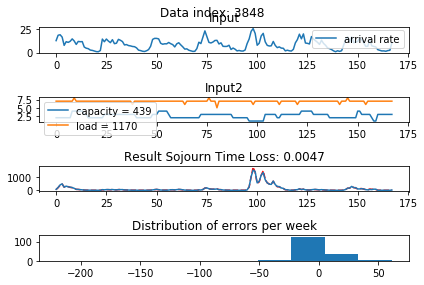

In [21]:
index = np.random.randint(len(test_set))
print(index)
predict_single = single_predict(test_set, m, index, plot=True, title="Result Sojourn Time")

0.010767299374467756
0.11289589
0.11289589
42281.902


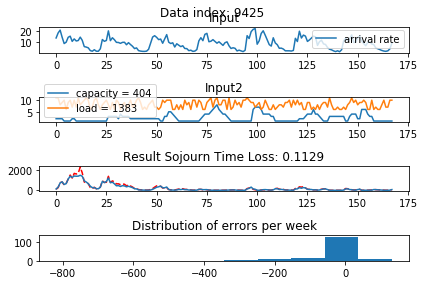

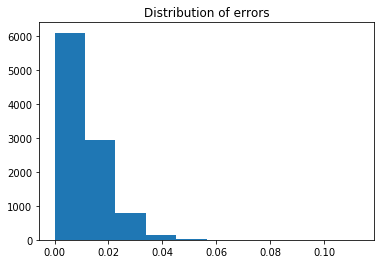

In [22]:
loss1 = 0
lossmax = 0
lossarray=np.zeros(len(test_set))
lossindex=0
for index in range(len(test_set)):
    output = single_predict(test_set, m, index, plot=False, title="Result Sojourn Time")
    sample = test_set[index]
    model_input = sample['inputs']
    truth = sample['sojourn_time']
    truth = truth.cpu().detach().numpy()
    loss1 += abs((np.sum(output) - np.sum(truth)) / np.sum(truth))
    if abs((np.sum(output) - np.sum(truth)) / np.sum(truth))>lossmax:
        lossmax =max(lossmax,abs((np.sum(output) - np.sum(truth)) / np.sum(truth)))
        lossindex=index
    lossarray[index]=abs((np.sum(output) - np.sum(truth)) / np.sum(truth))
print(loss1/len(test_set))
print(lossmax)
predict_single = single_predict(test_set, m, lossindex, plot=True, title="Result Sojourn Time")
fig, ax = plt.subplots(1, 1, sharex=False)
ax.set_title("Distribution of errors")
ax.hist(lossarray)
plt.show()

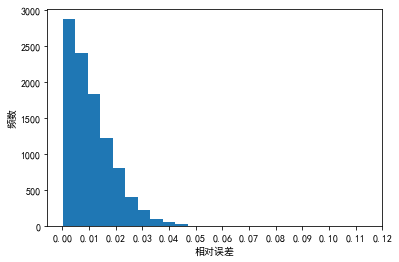

In [52]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置中文字符集
plt.rcParams['axes.unicode_minus'] = False # 设置负号正常显示
plt.hist(lossarray,bins=12)
plt.xticks(np.linspace(0,0.12,13))
plt.ylabel('频数')
plt.xlabel('相对误差')
plt.savefig('stable errors.png',dpi=300)
plt.show()

In [48]:
import matplotlib.font_manager as fm
fonts = fm.findSystemFonts()
for font in fonts:
    print(font)

C:\Windows\Fonts\LeelaUIb.ttf
C:\Windows\Fonts\seguibl.ttf
C:\Windows\Fonts\calibrili.ttf
C:\Windows\Fonts\segoescb.ttf
C:\Windows\Fonts\ROCKB.TTF
C:\Windows\Fonts\seguibli.ttf
C:\Windows\Fonts\GOTHIC.TTF
C:\Windows\Fonts\YuGothB.ttc
C:\Windows\Fonts\MATURASC.TTF
C:\Windows\Fonts\LBRITED.TTF
C:\Windows\Fonts\gadugib.ttf
C:\Windows\Fonts\STCAIYUN.TTF
C:\Windows\Fonts\arialbi.ttf
C:\Windows\Fonts\MAGNETOB.TTF
C:\Windows\Fonts\SitkaZ.ttc
C:\Windows\Fonts\sylfaen.ttf
C:\Windows\Fonts\PERB____.TTF
C:\Windows\Fonts\ariblk.ttf
C:\Windows\Fonts\LSANSD.TTF
C:\Windows\Fonts\FRAMDCN.TTF
C:\Windows\Fonts\STLITI.TTF
C:\Windows\Fonts\FZSTK.TTF
C:\Windows\Fonts\marlett.ttf
C:\Windows\Fonts\SitkaI.ttc
C:\Windows\Fonts\LHANDW.TTF
C:\Windows\Fonts\PRISTINA.TTF
C:\Windows\Fonts\BELLI.TTF
C:\Windows\Fonts\trebuc.ttf
C:\Windows\Fonts\segoeuil.ttf
C:\Windows\Fonts\SIMLI.TTF
C:\Windows\Fonts\courbi.ttf
C:\Windows\Fonts\impact.ttf
C:\Windows\Fonts\BSSYM7.TTF
C:\Windows\Fonts\HARLOWSI.TTF
C:\Windows\Fonts\IMPR

C:\Windows\Fonts\SCHLBKBI.TTF
C:\Windows\Fonts\OLDENGL.TTF
C:\Windows\Fonts\REFSAN.TTF
C:\Windows\Fonts\GOTHICBI.TTF
C:\Windows\Fonts\ARIALNI.TTF
C:\Windows\Fonts\ebrima.ttf
C:\Windows\Fonts\HTOWERTI.TTF
C:\Windows\Fonts\cambria.ttc
C:\Windows\Fonts\verdanaz.ttf
C:\Windows\Fonts\msyi.ttf
C:\Windows\Fonts\FZYTK.TTF
C:\Windows\Fonts\TCBI____.TTF
C:\Windows\Fonts\segoeuib.ttf
C:\Windows\Fonts\simsunb.ttf
C:\Windows\Fonts\BRLNSR.TTF
C:\Windows\Fonts\BOD_BI.TTF
C:\Windows\Fonts\COPRGTL.TTF
C:\Windows\Fonts\CALIFI.TTF
C:\Windows\Fonts\LBRITE.TTF
C:\Windows\Fonts\TCCEB.TTF
C:\Windows\Fonts\simsun.ttc
C:\Windows\Fonts\gadugi.ttf
C:\Windows\Fonts\Candarai.ttf
C:\Windows\Fonts\STXINGKA.TTF
C:\Windows\Fonts\constanz.ttf
C:\Windows\Fonts\RAGE.TTF
C:\Windows\Fonts\timesi.ttf
C:\Windows\Fonts\framdit.ttf
C:\Windows\Fonts\consolai.ttf
C:\Windows\Fonts\GARA.TTF
C:\Windows\Fonts\seguisb.ttf
C:\Windows\Fonts\Candarali.ttf
C:\Windows\Fonts\phagspab.ttf
C:\Windows\Fonts\PAPYRUS.TTF
C:\Windows\Fonts\TCCM__

In [ ]:
def predict_length(model, arrival, N, M):
    model.eval()
    inputs = np.concatenate((arrival, N, M)).reshape(1, FEATURE_NUMBER * T)
    model_input = torch.FloatTensor(inputs).to(device)
    model_input = model_input.view(1, FEATURE_NUMBER, SEQ_LEN).transpose(1, 2)
    output = model(model_input).detach().cpu().numpy()
    output=output[0,:,0]
    outcome=0
    for i in range(T):
        outcome+=output[i]/np.sum(arrival)
    return outcome/10

In [ ]:
arr_test = np.loadtxt("datatest/arr.csv", delimiter = ",")
N_test = np.loadtxt("datatest/doc.csv", delimiter = ",")
M_test=np.loadtxt("datatest/M.csv", delimiter = ",")
#st_test =10* np.loadtxt("datatest/wt.csv", delimiter = ",")

output = predict_length(model, arr_test, N_test,M_test)
print(output,np.sum(output))

In [ ]:
outcome = np.loadtxt("0724.csv", delimiter = ",")

fig, ax = plt.subplots(1, 1, sharex=False)
ax.set_title("Distribution of errors")
ax.hist(outcome)
plt.show()
print(np.percentile(outcome,92))

In [ ]:
output = predict_length(model, arr_test, N_test)

# plt.plot(st_test, label='truth')
# plt.plot(output, label = 'predict')
# plt.legend()
# plt.title("test")
# plt.show()

# count max range
r = np.zeros(output.shape)
for i in range(output.shape[0]):
  r[i] = np.abs(output[i] - st_test[i])

loss = (np.sum(st_test) - np.sum(output)) / np.sum(st_test)
print(loss)

fig, ax = plt.subplots(3, 1, sharex=False)
fig.suptitle('Data index: %d' % 0)
ax[0].plot(arr_test, label='arrival rate')
ax[0].plot(N_test, label="capacity = %d" % np.sum(N_test))
ax[0].set_title('Input')
ax[0].legend()
            
ax[1].plot(st_test, 'r--', label='truth')
ax[1].plot(output, label='predict (max range: %.2f)' % (np.max(r)))
ax[1].set_title('Loss: %.4f' % (loss))
ax[1].legend()
            
ax[2].set_title("Distribution of errors")
ax[2].hist(output-st_test)
fig.tight_layout()
plt.show()